In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd

simworldname = 'simulationWorld2.xml' #ENVIROMENT
groundtruth = '28jun2.csv' #AGENT'S MOVEMENTS
motion_readings = '28Jun2_motion_events.txt'
# groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
 
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)

In [60]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# sensor_readings = open(motion_readings, "r")
sensor_readings = open(motion_readings, "r").readlines()

dataset_times = []
dataset_readings = []
for i in range(0,len(sensor_readings)):
    time = sensor_readings[i].split(';')[0]
    sensor_array = sensor_readings[i].split(';')[1]
    dataset_times.append(int(time))
    dataset_readings.append(sensor_array)

dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']
with open(groundtruth, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    line = 0
    for row in reader:
        new_row = []
        if (reader.line_num != 1):
            ind = find_nearest(dataset_times[1:], int(row[0]))
            dataset = np.vstack((dataset, [float(row[0]), float(row[4]), float(row[5]), dataset_readings[line]]))
            line = line + 1

TypeError: object of type '_csv.reader' has no len()

In [3]:
dataset

array([['time', 'gt(x)', 'gt(y)', 'motion_readings'],
       ['1498670641.0', '1.197742', '5.402001', '0000000000000000000000'],
       ['1498670642.0', '1.198065', '5.401716', '0000000000000000000000'],
       ...,
       ['1498677300.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677303.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677318.0', '3.4', '3.45', '0000000000000000010000']],
      dtype='<U32')

In [4]:
motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
motions_sensor_data = {}

sr_matrix = np.zeros([1, 14])
for i in range(1,len(dataset)):
    sensor_array = dataset[i][3]
    sr_row = []
    for j in range(0,len(sensor_array)):
        if (motions_order[j] <= 14):
            sr_row.append(int(sensor_array[j]))

    sr_matrix = np.vstack((sr_matrix,sr_row))

i = 0
for sensor in motions_order:
    if (sensor <= 14):
        motions_sensor_data[sensor] = []
        motions_sensor_data[sensor] = sr_matrix[:, i]
        i = i + 1
        
for sensor in motion_sensors:
    new_readings = []
    new_readings.append(motions_sensor_data[sensor][0])
    for i in range(1, len(motions_sensor_data[sensor])):
        if (new_readings[len(new_readings) - 1] == motions_sensor_data[sensor][i]):
            new_readings.append(0)
        else:
            new_readings.append(1)

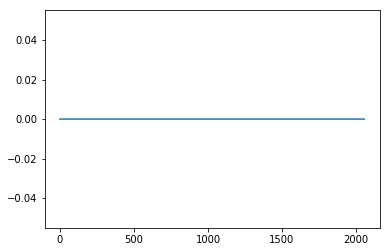

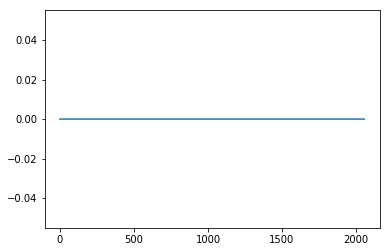

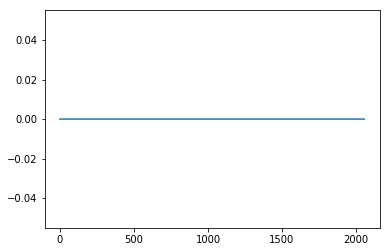

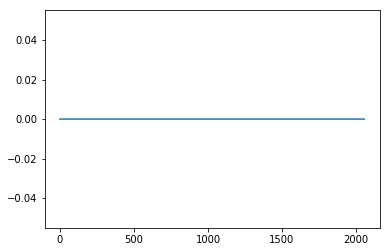

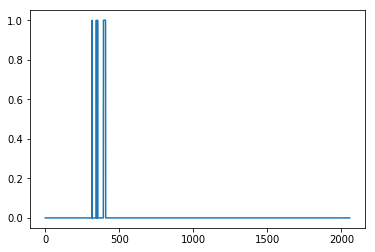

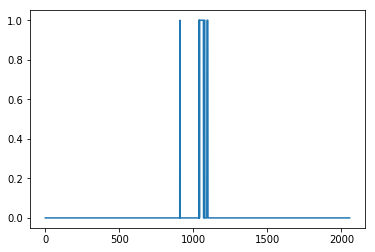

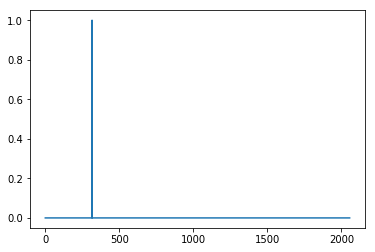

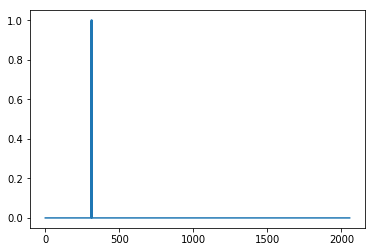

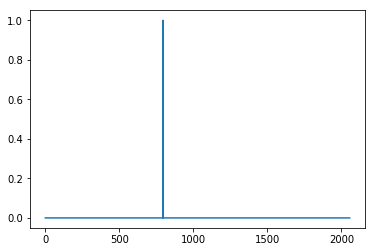

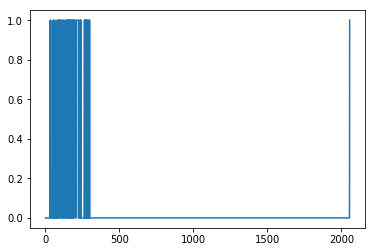

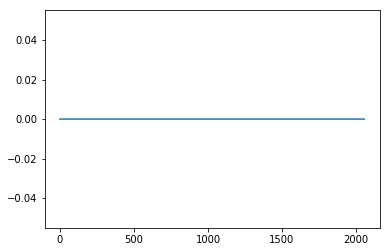

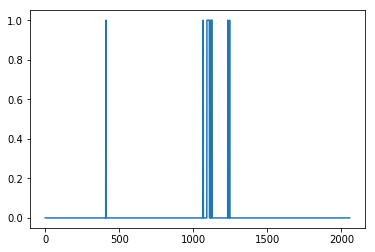

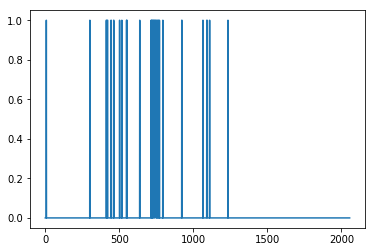

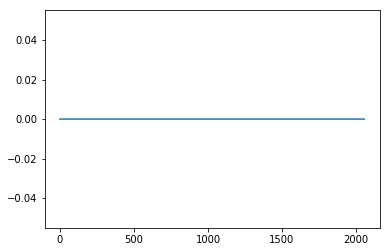

In [5]:
import matplotlib.pyplot as plt

for i in motion_sensors:
    plt.plot(list(range(0,len(motions_sensor_data[i]))), motions_sensor_data[i])
    plt.show()

In [6]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    
    '''
        This fucntion uses an 2D gaussian, that means: X~(x, mean, covarianceMatrix)
        Input:
        x = [xOracle, yOracle] (Actually we don't care about it anymore)
        mean = [xSimulator, ySimulator]
        covarianceMatrix= | r  0 | , where r is the circle radious
                          | 0  r |

        Returns: cdf of the normal distribution
        
    '''
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        # print("real: ", real_localization)
        # print("simu: ", simulated_localization)
              
        return probCdf
    
"""
System's sensors
All this classes are childrens from Sensor Class
"""
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        # self.sensing_area = (str(element.find('radius').text))
        self.sensing_area = (str(120))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist
    
   # def distanceToMeasure(self, dist):
     #   mp = self.RSSI + (10*n*math.log10(dist)
    #    return mp
    

In [7]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [8]:
class GridMap:
    map = ""

In [9]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [10]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

root = xml.etree.ElementTree.parse(simworldname).getroot()

grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
grid2 = np.copy(grid_map)

# print(grid2)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            #Choose the kind of sensor we have
            if(str(sensor.find('type').text) == 'RFID_Reader'):
                this_sensor = RFID_Reader(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                this_sensor = MotionSensorBinary(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                this_sensor = MotionSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                this_sensor = PressureSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'BeaconSensor'):
                this_sensor = BeaconSensor(sensor)
                
            sensors_list.append(this_sensor)
            print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y + " " + this_sensor.sensor_id)
            
            # print(sensors_list[len(sensors_list) - 1])

BeaconSensor 479 405 sensorBC1
PressureSensorAnalog 479 405 sensorPS1
MotionSensorBinary 455 405 sensor1
MotionSensorBinary 479 284 sensor2
MotionSensorBinary 509 101 sensor3
MotionSensorBinary 183 389 sensor4
MotionSensorBinary 271 225 sensor5
MotionSensorBinary 91 225 sensor6
MotionSensorBinary 466 894 sensor7
MotionSensorBinary 426 626 sensor8
MotionSensorBinary 122 861 sensor9
MotionSensorBinary 244 1003 sensor10
MotionSensorBinary 215 711 sensor11
MotionSensorBinary 183 577 sensor12
MotionSensorBinary 574 527 sensor13
MotionSensorBinary 574 688 sensor14


In [11]:
############################################
####         LOCALIZATION CLASS         ####
############################################
simulated_sensor_readings = []

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

          
        
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                                 
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):
                #finds the inferred an real locations, and what sensors were fired
#         inferred_location, real_location, fired_sensors = self.getLocations(event.timestamp, event)    
        
        # k = 0
        # i = len(fired_sensors2)
        
        # if(i > 0):
        #     i -= 1
        
        # while(i >= 0):         
        #     current_sensor = fired_sensors2[i]
            #get the probability from the gaussian filter
        #     probi = current_sensor.GaussianFiredSensor(inferred_location, real_location)
            
            # COMMENTED OUT FOR EXPERIMENTS
            # if(probi < 0.015):
                # del fired_sensors2[i]
        #     i -= 1
            #print(probi)
                
        # fired_sensors = fired_sensors2
        
        
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        

        
        self.SimulateSensorReading(fired_sensors) 
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        #Bruno's code here
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    circ = Circle((int(float(sensor.x)/10), int(float(sensor.y)/10)), int(float(sensor.sensing_area)/10))
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
            
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)

        # plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        # plt.show()
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        # print(dist)
    
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        print("infered loc:")
        print(inferred_location)
        print("real loc:")
        print(real_location)
        
        xlim=(0, 200)
        ylim=(0, 200)
        
        
        p1 = plt.scatter(real_location[0], real_location[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(inferred_location[0], inferred_location[1], marker='s', color='r')
        
        plt.legend([p1, p2], ['Real Location', 'Estimated Location'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        # print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()
        
        return np.linalg.norm(inferred_location - real_location)
        
    def SimulateSensorReading(self, fs):
        sensor_bins = [0] * 14
        
        for sensor in fs:
            if (sensor.sensor_type == 'MotionSensorBinary'):
                snum = int(sensor.sensor_id.replace('sensor',''))
                sensor_bins[motion_sensors.index(snum)] = 1
                
        simulated_sensor_readings.append(sensor_bins)
        print(len(simulated_sensor_readings))
    
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        #print("ponto: ", point, "time: ", time)
        return point
    
    """
    I'm implementing a randomic action fiture for the sensors, causing false-positive events. Basically, 
    to choose WHICH sensor will be deployed, I get an random number between [0 - (X - 1)], where X is the length 
    of the sensor list. To choose WHEN the sensor is deployed, I'll define a variable called "control = 123", and
    create a list of random 10 numbers between [0 - 150], everytime the list contains whe variable control, we
    switch to the random event.
    """
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        # COMMENTED OUT FOR EXPERIMENTS
        # listControl = random.sample(range(0, 150), 10)
        # control = 123
        
        # if(control in listControl):  
        #     rand = randint(0, len(sensors_list) - 1)
        #     current_sensor = sensors_list[rand]
        #     fired_sensors2.append(current_sensor)
        
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [12]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [13]:
#Debug function, sees what kind of activity we have
def typeAction(type):
    if(type == "Sleep"):
        print(type + "ENTREI")

    if(type == "walk"):
        print(type + "ENTREI")
        
    if(type == "Water"):
        print(type + "ENTREI")
        
    if(type == "Wash"):
        print(type + "ENTREI")
        
    if(type == "Entertainment"):
        print(type + "ENTREI")
        
    if(type == "Exercise"):
        print(type + "ENTREI")

    if(type == "Clean"):
        print(type + "ENTREI")
        
    if(type == "Eat"):
        print(type + "ENTREI")
        
    if(type == "Sit"):
        print(type + "ENTREI")

In [14]:
"""
Function to read the path in the csv file and turn it on an event.
The event is composed of: (sensor Id, data, hash, source, time)
Everytime that a sensor finds
"""
def readFileCSV():             
    for i in range(1, len(dataset)):
        no_event_flag = 1
        xtrace = float(dataset[i][1])
        ytrace = float(dataset[i][2])
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        timetoadd = int(round(float(dataset[i][0])))
        
        if loc not in oracle['location'] and timetoadd not in oracle['time']:

            oracle['location'].append(loc)
            oracle['time'].append(timetoadd) 
        
        for sensor in sensors_list:
            # print(sensor.sensor_type)
            # if(sensor.sensor_type == "BeaconSensor"):
                # no_event_flag = 0
                # event = Event()
                # event.RSSI = sensor.RSSI #RSSI, just for beacons
                # event.accelerometer = sensor.accelerometer #if it's moving or not - jsut for beacon
                # event.objectAtt = sensor.object #Object where the sensor is
                
                # event.RSSI = 0 #RSSI, just for beacons
                # event.objectAtt = "" #Object where the sensor is
                # event.accelerometer = False #if it's moving or not - jsut for beacon
                # continue
                
            # elif(sensor.sensor_type == "PressureSensorAnalog"):
                # continue
                # no_event_flag = 0
                # event.objectAtt = sensor.object #Object where the sensor is
            
            if (sensor.sensor_type == "MotionSensorBinary"):    
                circ = Circle((int(int(sensor.x) / 10), int(int(sensor.y) / 10)), int(int(sensor.sensing_area) / 10))
                if (circ.contains_point([x, y])):
                    no_event_flag = 0
                    event = Event()
                    event.sensor = sensor.sensor_id #SensorId that created the event
                    event.data = "TRUE"  #data
                    event.hash = "|hash|" #hash
                    event.source = "xmlFile" #where is coming from
                    event.timestamp = int(round(float(dataset[i][0]))) #timestamp
                    event.sensorType = sensor.sensor_type #type of sensor

                    run_localization(event)
                    
            # else:
                # sensor_bins = [0] * 14
                # simulated_sensor_readings.append(sensor_bins)    
            
        if (no_event_flag == 1):
            sensor_bins = [0] * 14
            simulated_sensor_readings.append(sensor_bins)
        no_event_flag = 0
        
        

        

289
start!
infered loc:
[45.         40.05357143]
real loc:
[41.8 42.6]


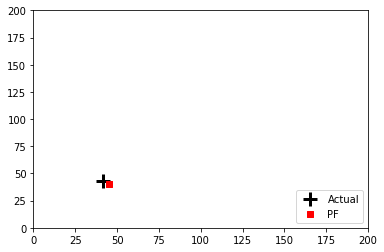

291
infered loc:
[55.69047619 68.07142857]
real loc:
[60. 65.]


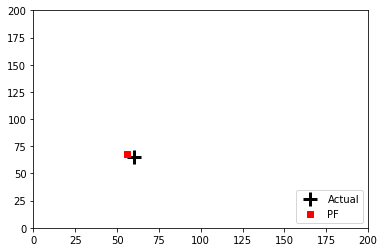

292
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


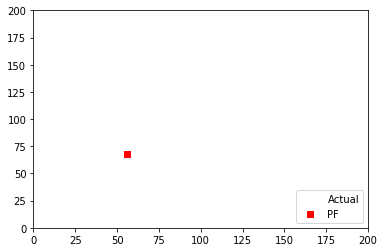

293
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


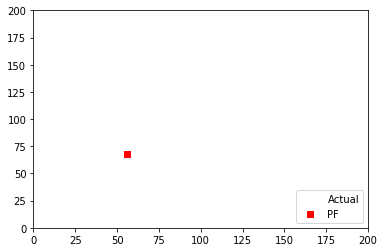

294
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


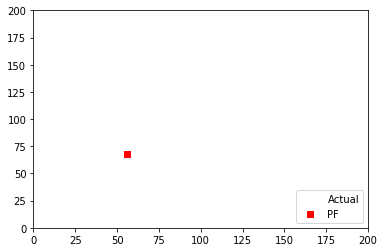

295
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


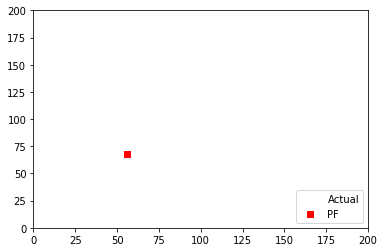

296
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


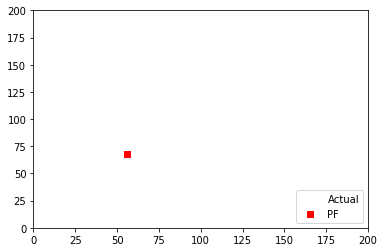

297
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


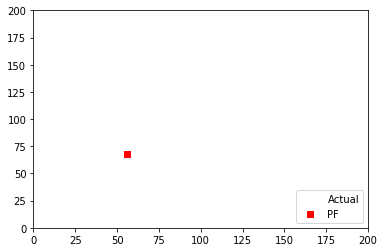

298
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


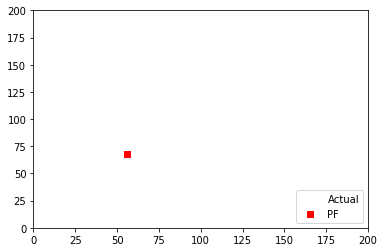

299
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


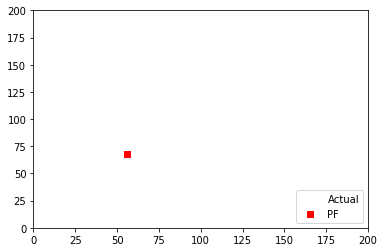

300
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


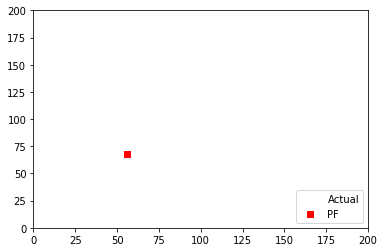

314
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


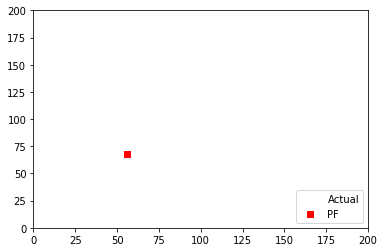

315
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


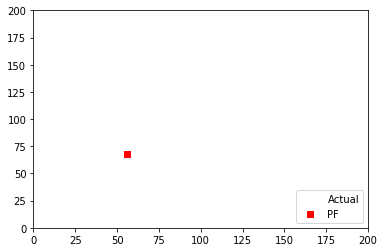

316
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


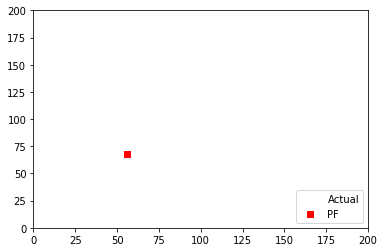

317
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


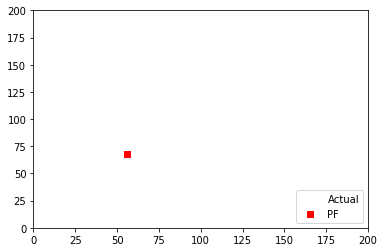

318
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


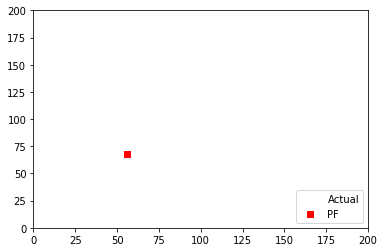

319
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


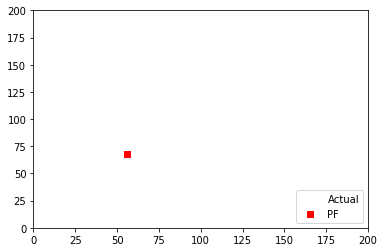

320
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


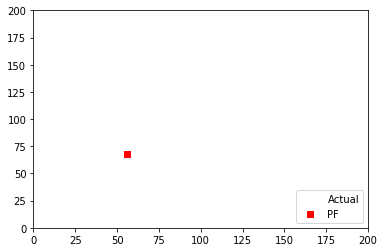

321
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


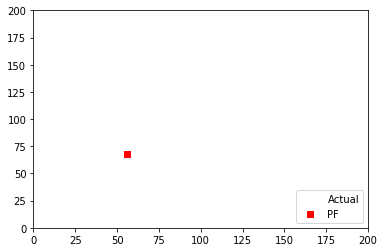

322
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


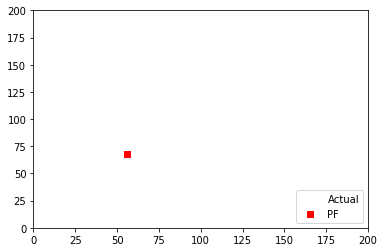

323
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


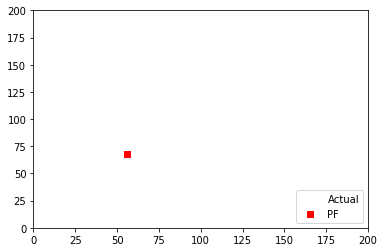

324
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


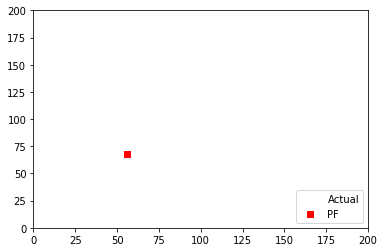

325
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


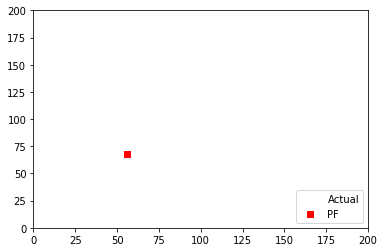

326
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


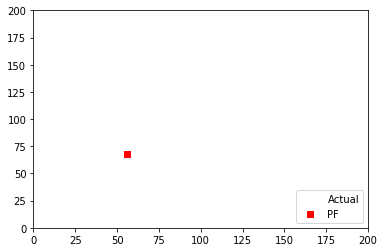

327
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


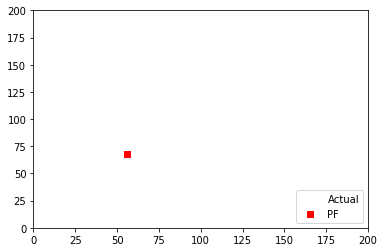

328
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


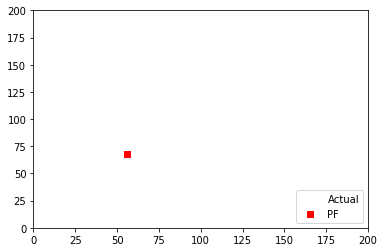

329
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


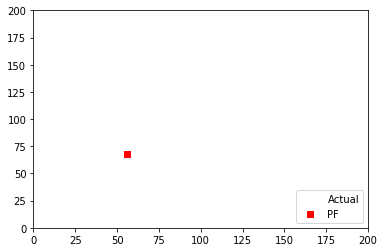

330
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


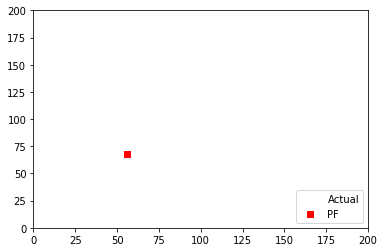

331
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


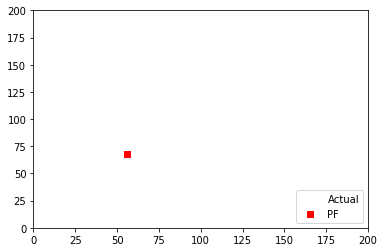

332
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


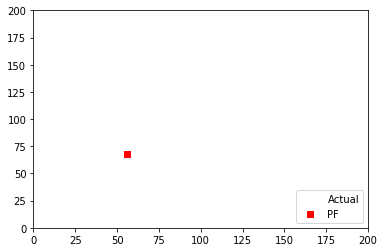

333
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


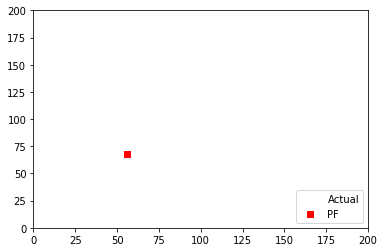

334
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


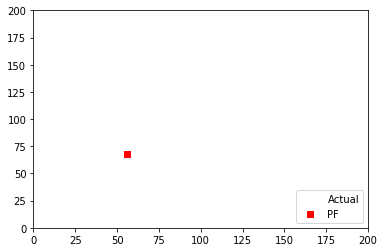

335
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


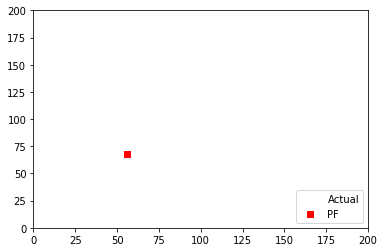

336
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


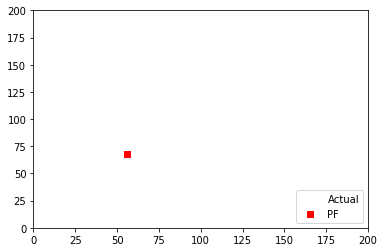

337
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


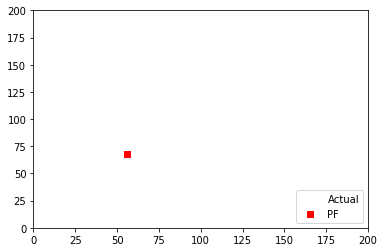

338
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


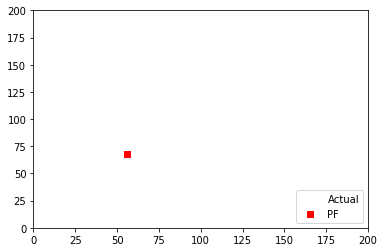

339
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


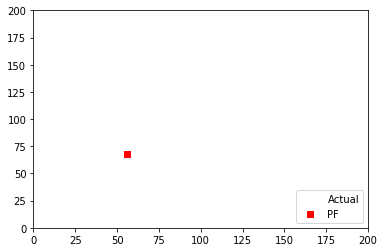

340
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


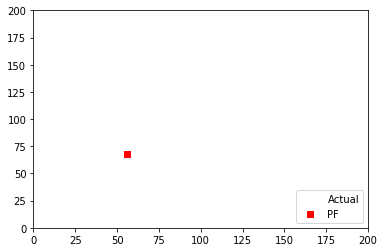

341
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


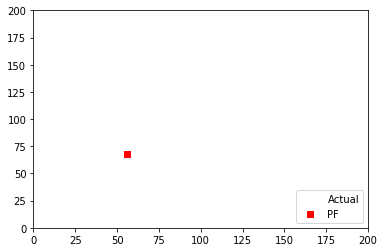

342
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


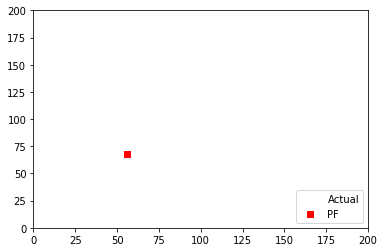

343
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


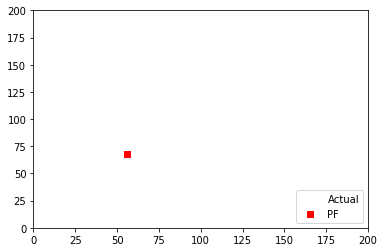

344
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


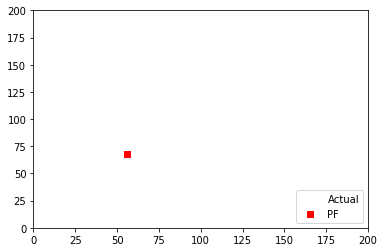

345
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


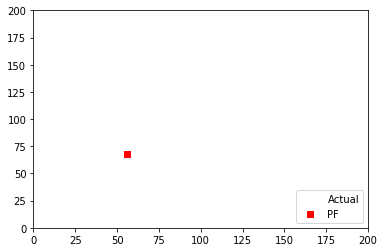

346
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


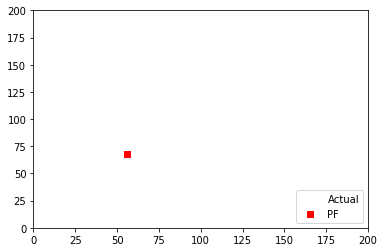

347
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


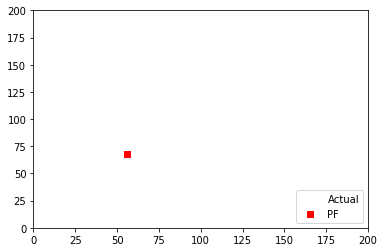

348
infered loc:
[55.69047619 68.07142857]
real loc:
[61.33333 68.     ]


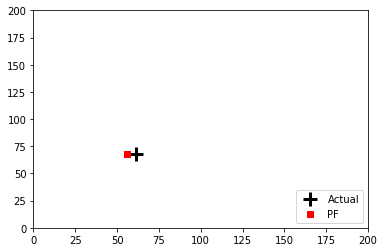

362
infered loc:
[55.69047619 68.07142857]
real loc:
[nan nan]


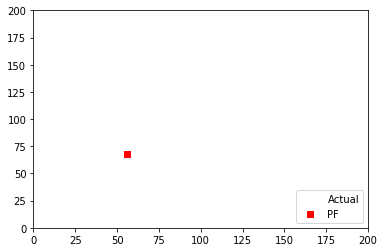

363
infered loc:
[55.69047619 52.07142857]
real loc:
[60. 49.]


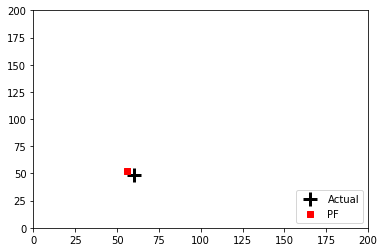

365
infered loc:
[42.         62.05357143]
real loc:
[45.      66.33333]


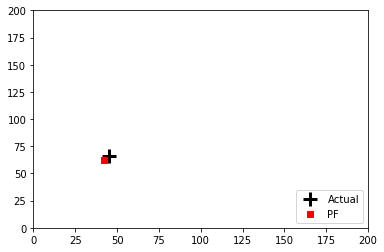

377
infered loc:
[42.         62.05357143]
real loc:
[44.86364 66.49091]


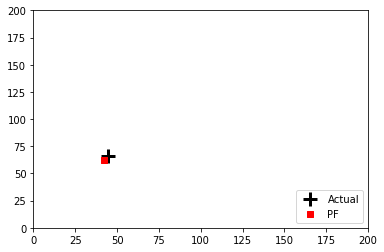

378
infered loc:
[42.         62.05357143]
real loc:
[45.27273 66.01818]


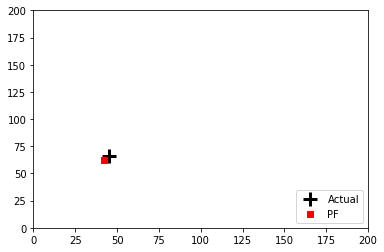

379
infered loc:
[42.         62.05357143]
real loc:
[45.68182 65.54545]


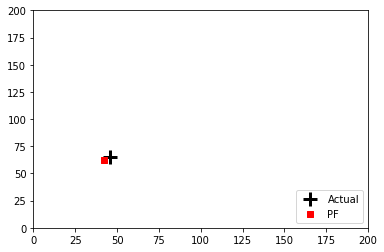

380
infered loc:
[42.         62.05357143]
real loc:
[46.09091 65.07273]


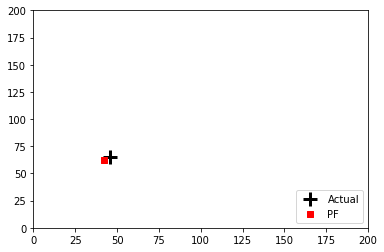

381
infered loc:
[42.         62.05357143]
real loc:
[46.5 64.6]


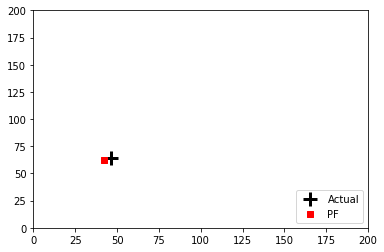

382
infered loc:
[42.         62.05357143]
real loc:
[46.90909 64.12727]


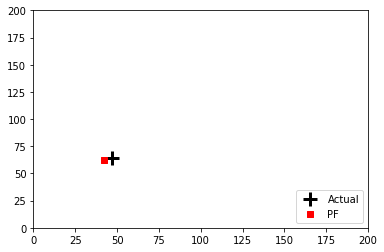

383
infered loc:
[42.         62.05357143]
real loc:
[47.31818 63.65455]


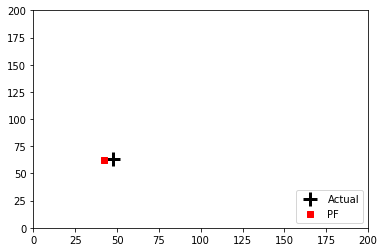

393
infered loc:
[55.69047619 52.07142857]
real loc:
[55.5 54.2]


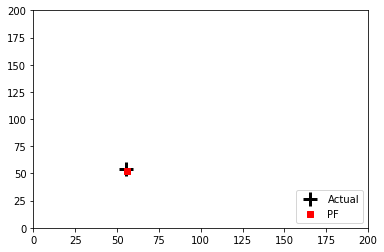

394
infered loc:
[55.69047619 52.07142857]
real loc:
[55.90909 53.72727]


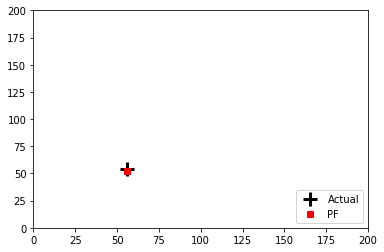

395
infered loc:
[55.69047619 52.07142857]
real loc:
[56.31818 53.25455]


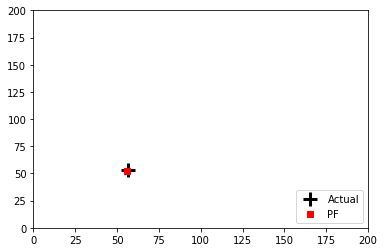

396
infered loc:
[55.69047619 52.07142857]
real loc:
[56.72727 52.78182]


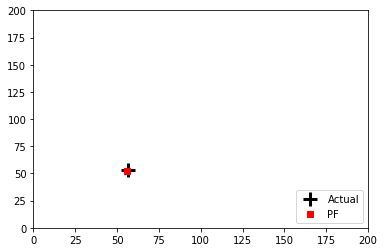

397
infered loc:
[55.69047619 52.07142857]
real loc:
[57.13636 52.30909]


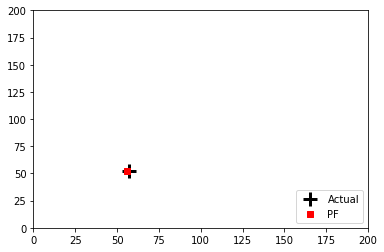

398
infered loc:
[55.69047619 52.07142857]
real loc:
[57.54545 51.83636]


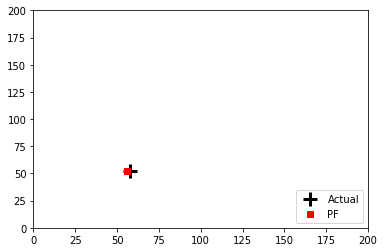

399
infered loc:
[55.69047619 52.07142857]
real loc:
[57.95455 51.36364]


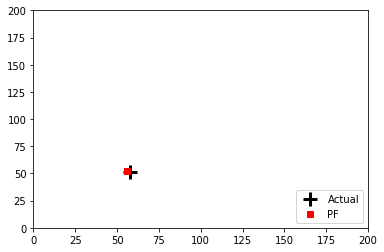

400
infered loc:
[55.69047619 52.07142857]
real loc:
[58.36364 50.89091]


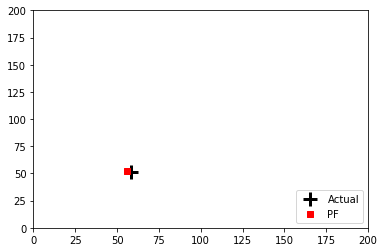

401
infered loc:
[55.69047619 52.07142857]
real loc:
[58.77273 50.41818]


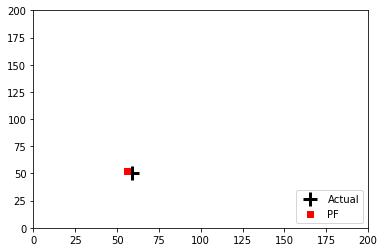

402
infered loc:
[55.69047619 52.07142857]
real loc:
[59.18182 49.94545]


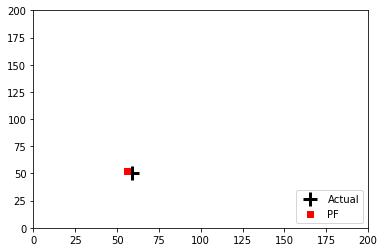

414
infered loc:
[24.         97.20408163]
real loc:
[ 25. 102.]


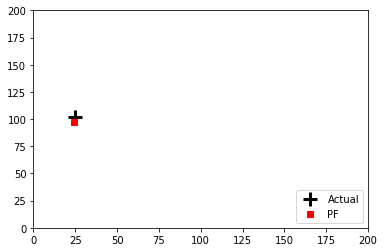

415
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


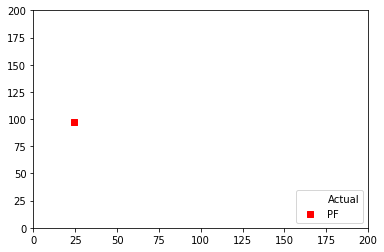

416
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


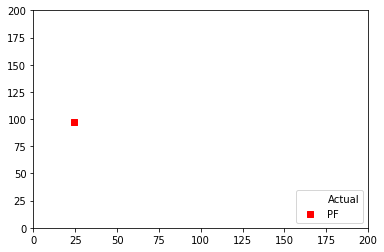

417
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


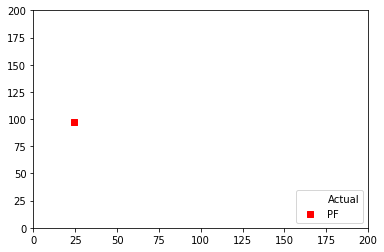

418
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


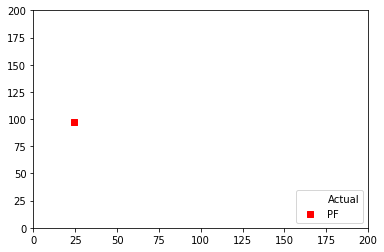

419
infered loc:
[24.         97.20408163]
real loc:
[ 18.5 102. ]


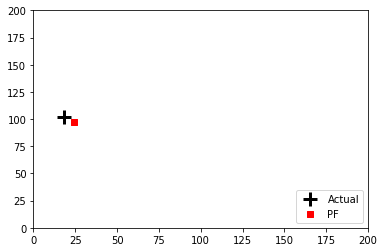

420
infered loc:
[24.         97.20408163]
real loc:
[ 21.75 102.  ]


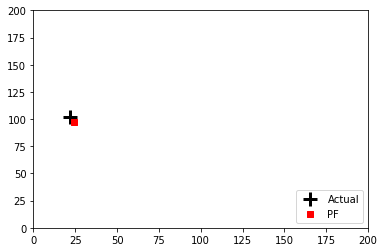

421
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


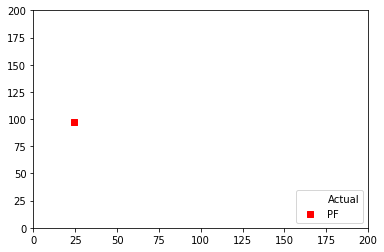

452
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


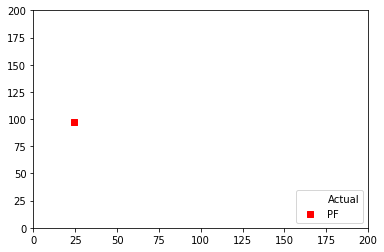

453
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


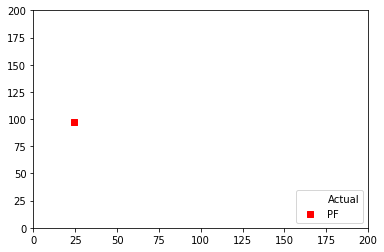

454
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


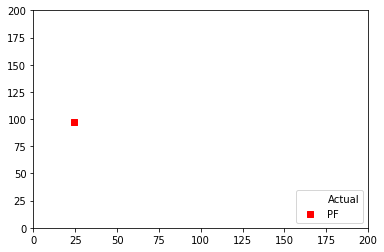

455
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


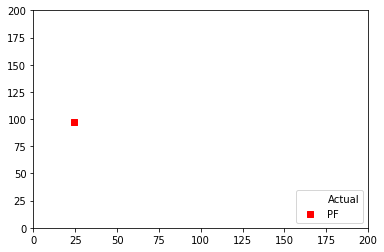

456
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


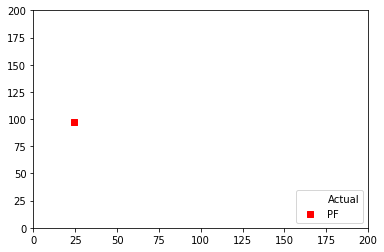

542
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


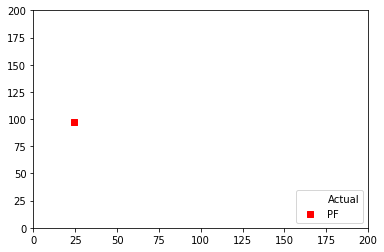

543
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


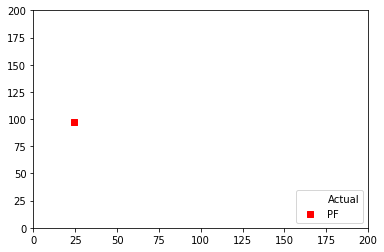

544
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


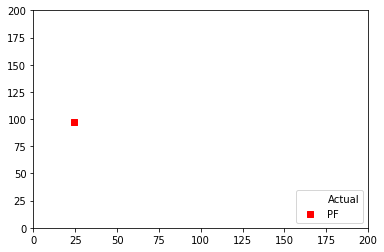

545
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


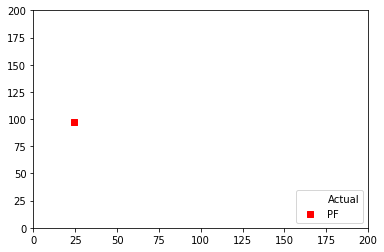

546
infered loc:
[24.         97.20408163]
real loc:
[20.7 95.8]


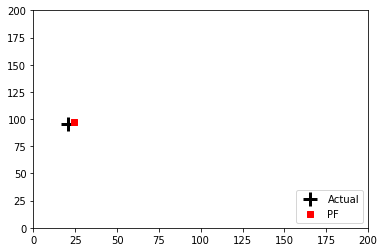

625
infered loc:
[21.         71.05357143]
real loc:
[21.33333 69.33333]


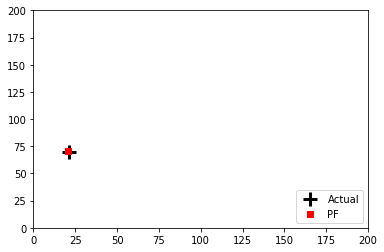

651
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


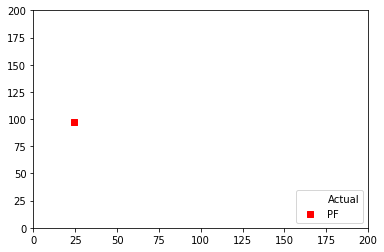

675
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


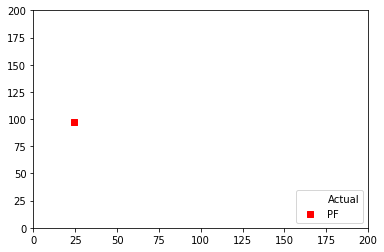

676
infered loc:
[24.         97.20408163]
real loc:
[nan nan]


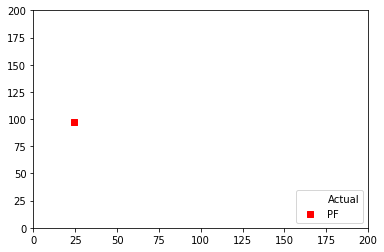

688
infered loc:
[24.         97.20408163]
real loc:
[25.9 95.8]


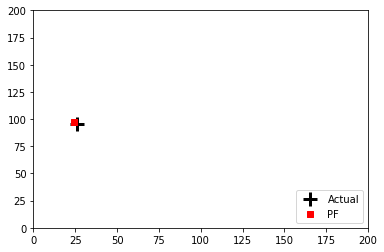

705
infered loc:
[21.         71.05357143]
real loc:
[17.25 68.5 ]


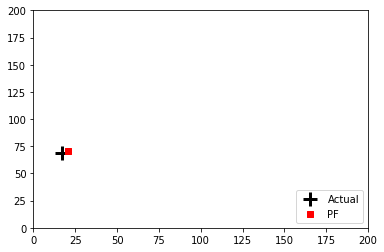

715
infered loc:
[21.         71.05357143]
real loc:
[16.08333 68.2619 ]


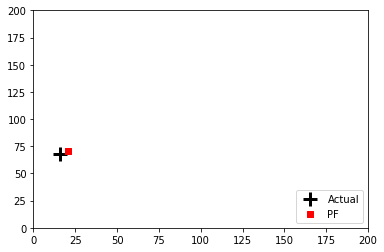

716
infered loc:
[21.         71.05357143]
real loc:
[17.83333 68.61905]


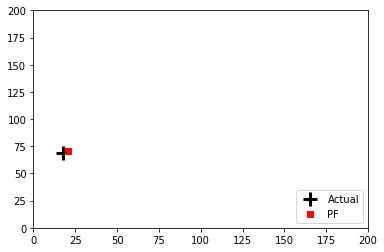

717
infered loc:
[21.         71.05357143]
real loc:
[26.58333 70.40476]


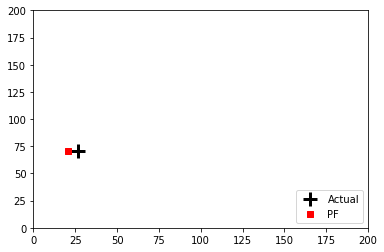

719
infered loc:
[21.         71.05357143]
real loc:
[nan nan]


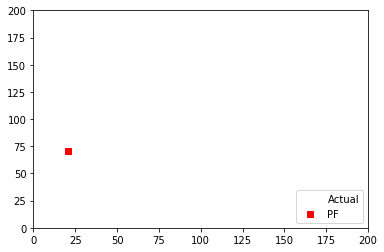

724
infered loc:
[21.         71.05357143]
real loc:
[19.7 69. ]


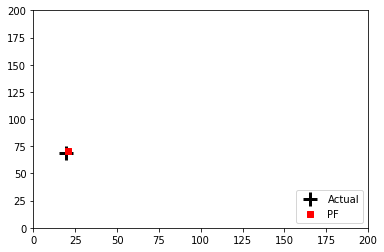

764
infered loc:
[24.         97.20408163]
real loc:
[ 18.98148 102.     ]


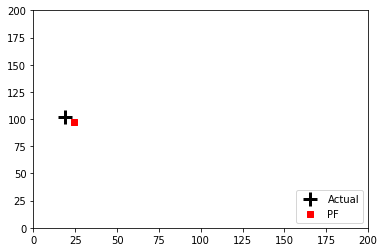

765
infered loc:
[24.         97.20408163]
real loc:
[ 20.42593 102.     ]


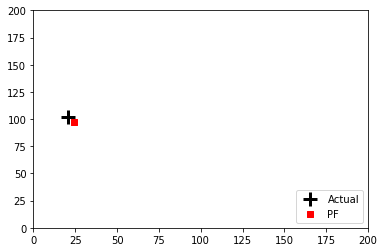

766
infered loc:
[24.         97.20408163]
real loc:
[ 21.14815 102.     ]


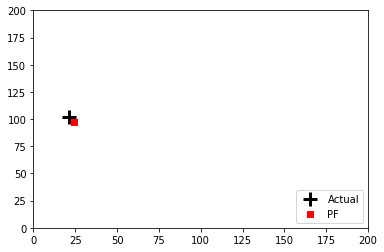

767
infered loc:
[24.         97.20408163]
real loc:
[ 21.87037 102.     ]


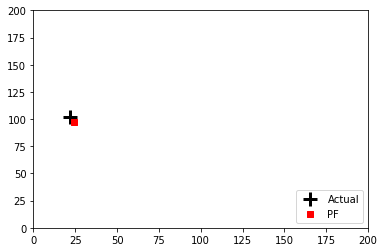

768
infered loc:
[24.         97.20408163]
real loc:
[ 22.59259 102.     ]


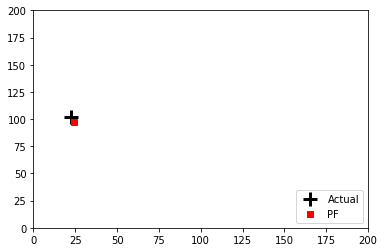

769
infered loc:
[24.         97.20408163]
real loc:
[ 23.31481 102.     ]


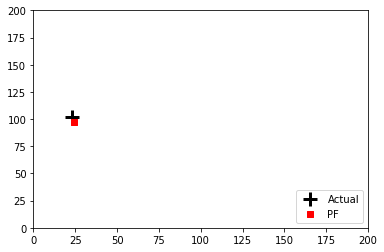

770
infered loc:
[24.         97.20408163]
real loc:
[ 24.03704 102.     ]


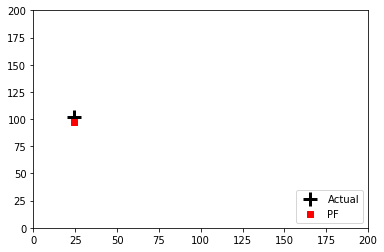

772
infered loc:
[18.         57.05357143]
real loc:
[23. 54.]


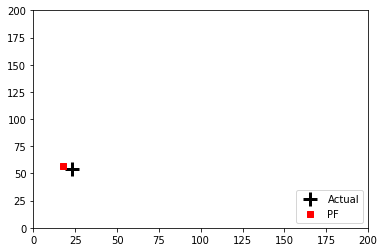

773
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


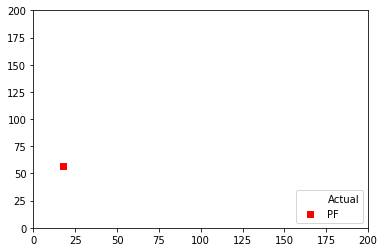

774
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


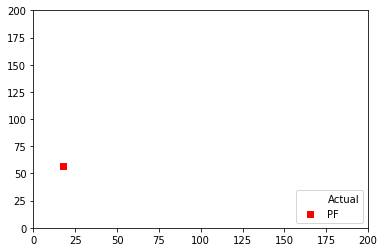

775
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


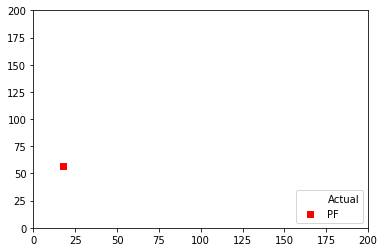

777
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


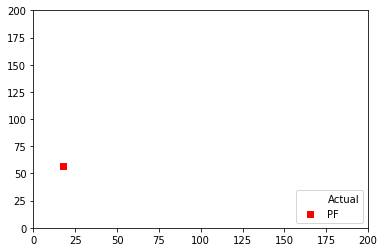

778
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


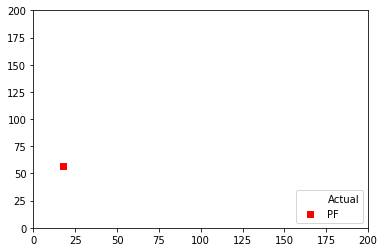

782
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


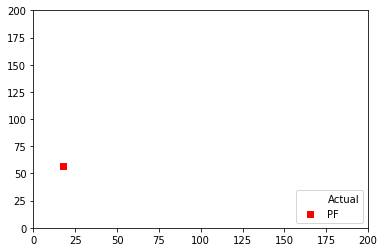

783
infered loc:
[18.         57.05357143]
real loc:
[17. 58.]


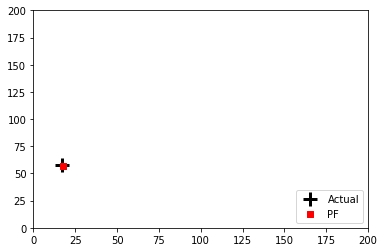

787
infered loc:
[18.         57.05357143]
real loc:
[18.5 57. ]


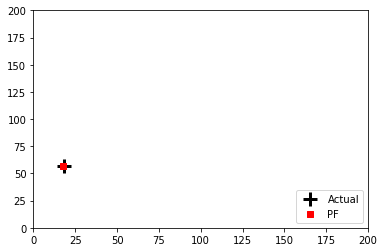

788
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


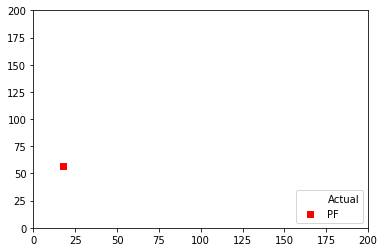

789
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


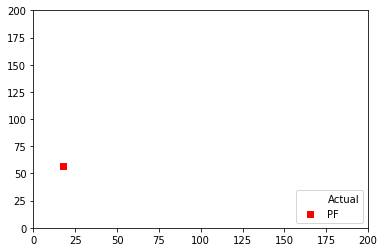

790
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


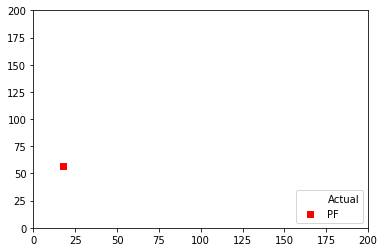

791
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


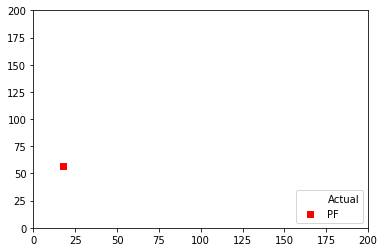

792
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


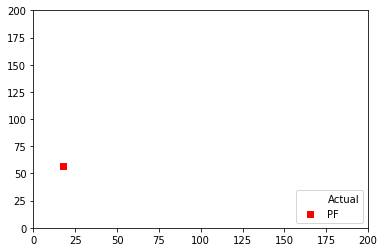

793
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


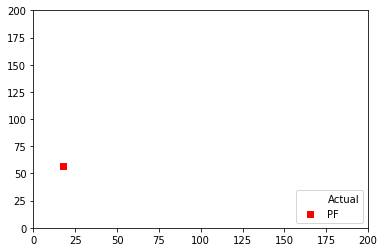

794
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


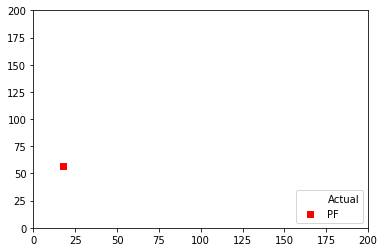

795
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


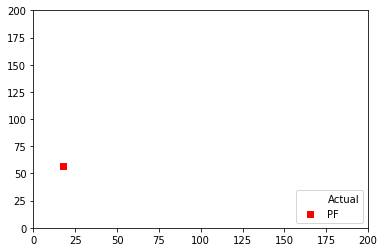

796
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


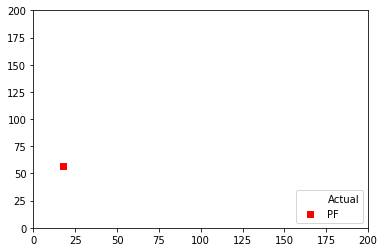

797
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


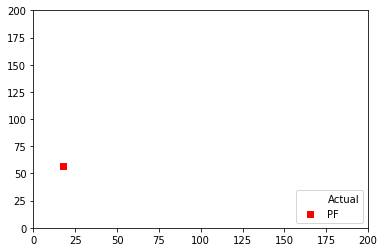

798
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


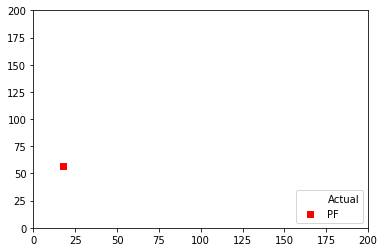

799
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


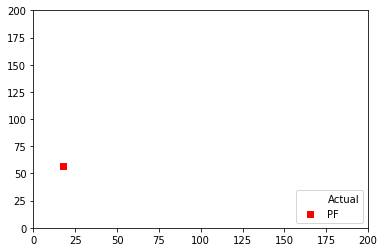

800
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


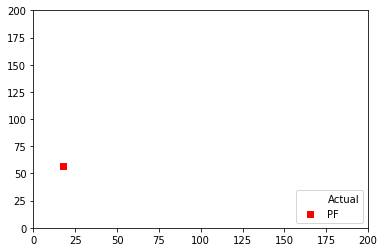

801
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


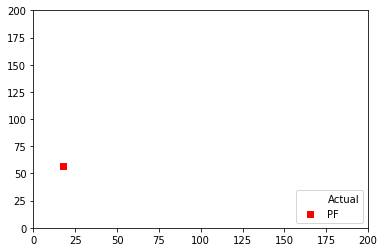

802
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


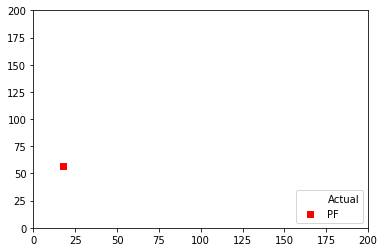

803
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


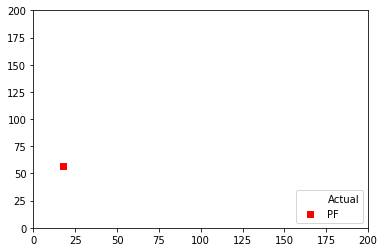

804
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


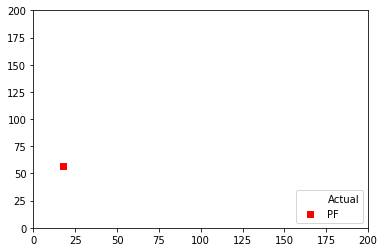

805
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


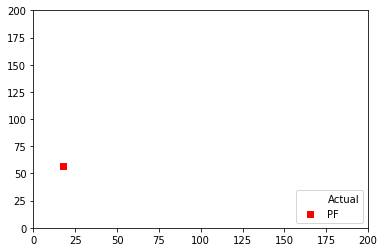

806
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


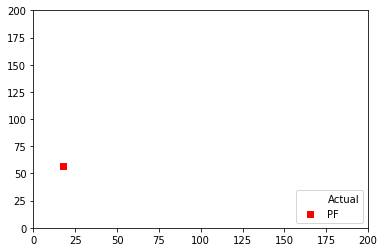

807
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


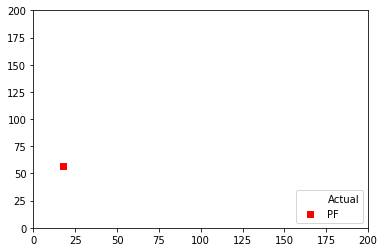

808
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


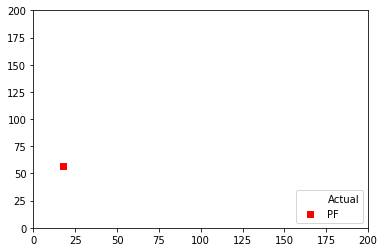

809
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


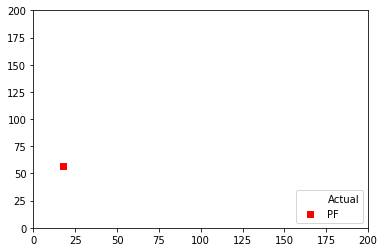

810
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


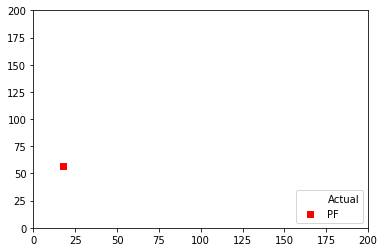

811
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


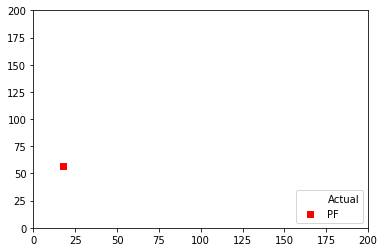

812
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


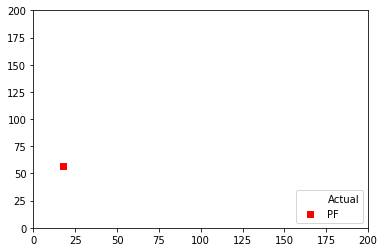

813
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


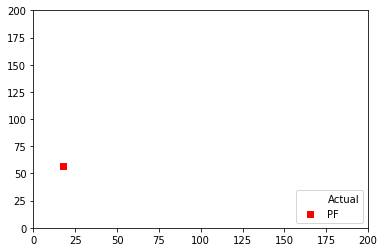

814
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


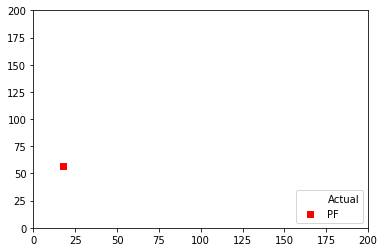

815
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


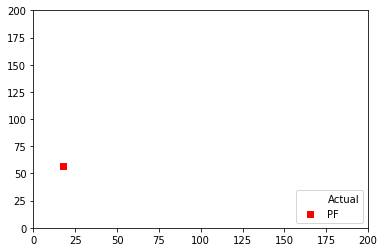

816
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


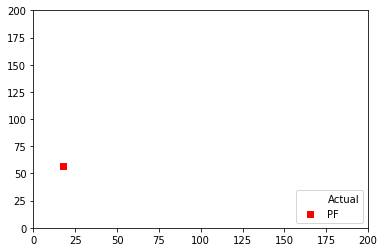

817
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


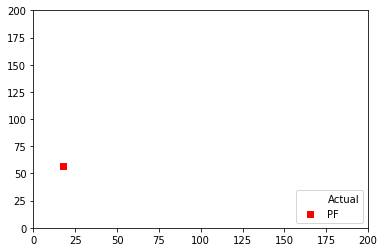

818
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


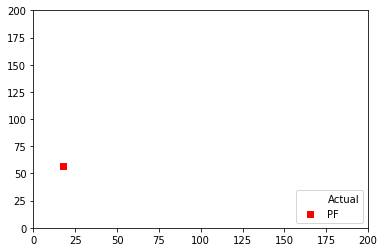

819
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


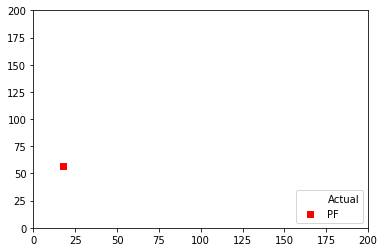

820
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


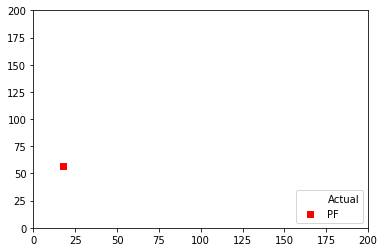

821
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


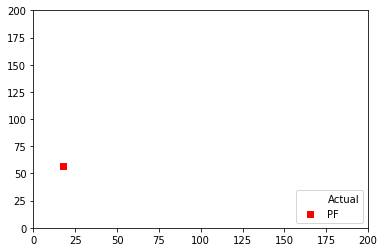

822
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


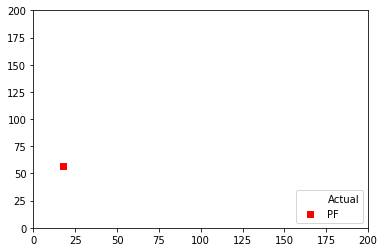

823
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


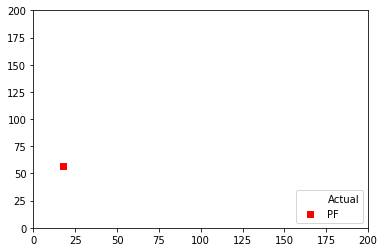

824
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


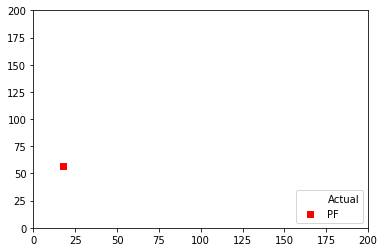

825
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


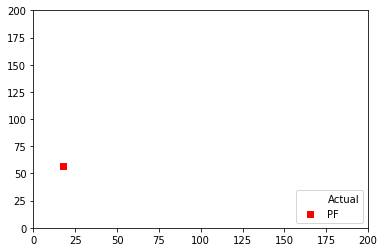

826
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


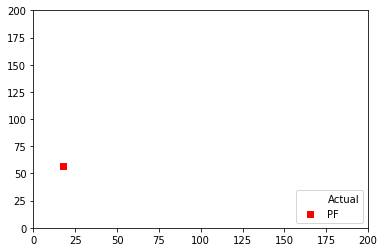

827
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


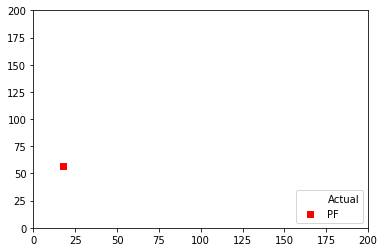

828
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


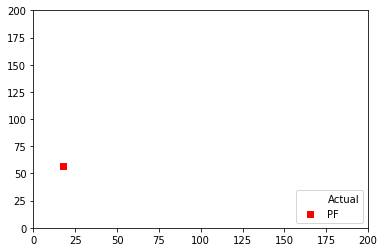

829
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


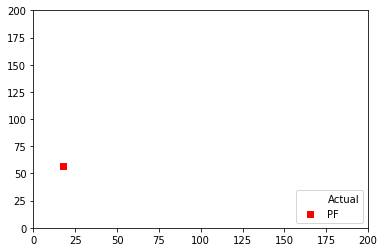

830
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


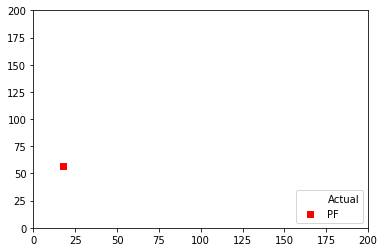

831
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


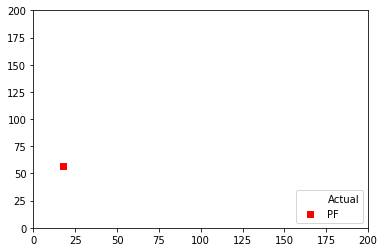

832
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


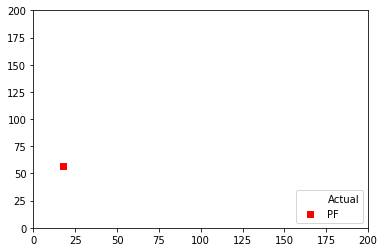

833
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


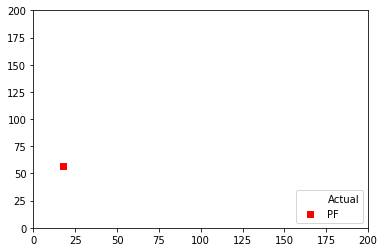

834
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


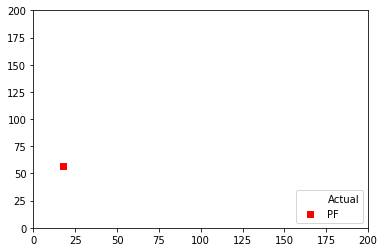

835
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


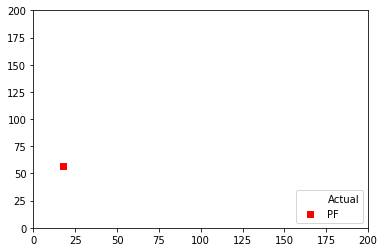

836
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


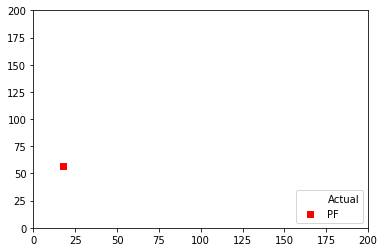

837
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


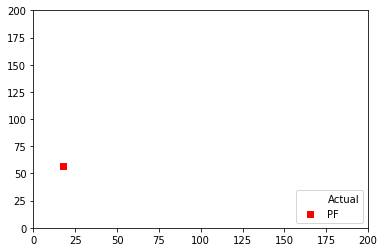

838
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


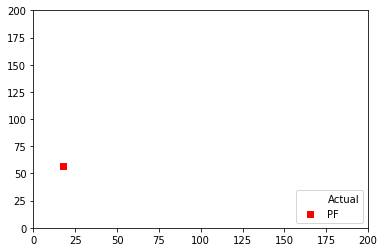

839
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


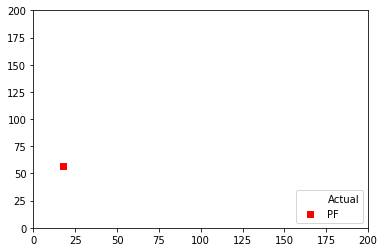

840
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


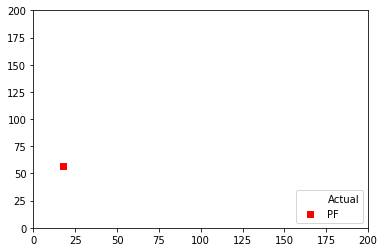

841
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


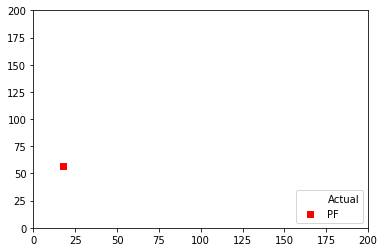

842
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


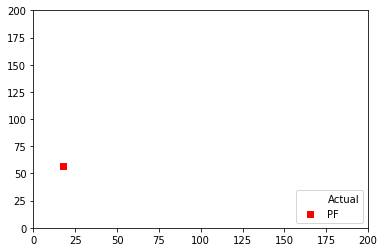

843
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


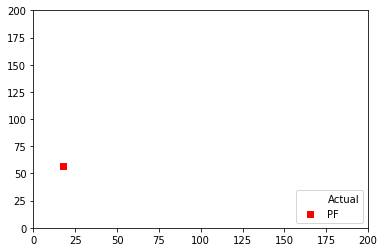

844
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


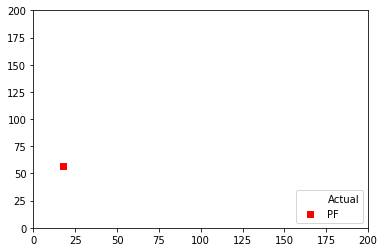

845
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


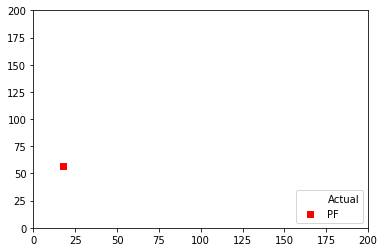

846
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


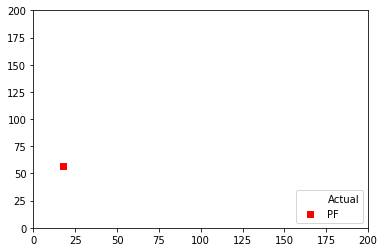

847
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


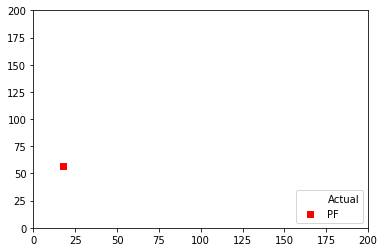

848
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


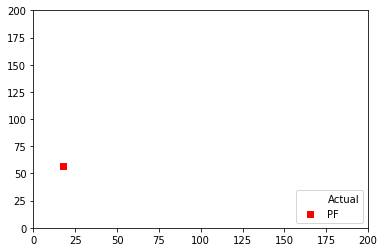

849
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


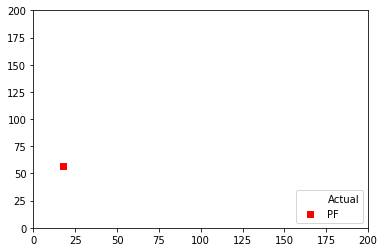

850
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


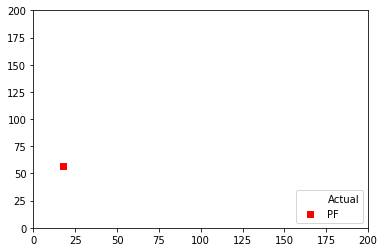

851
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


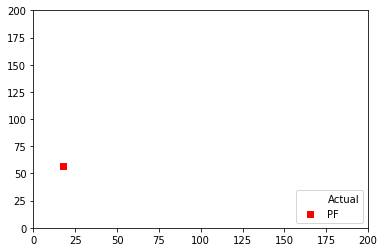

852
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


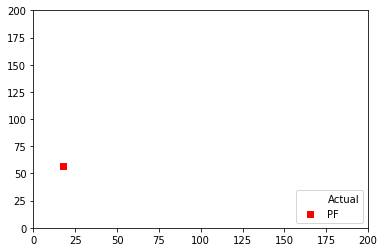

853
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


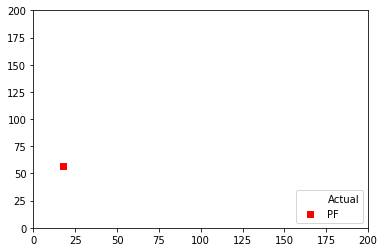

854
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


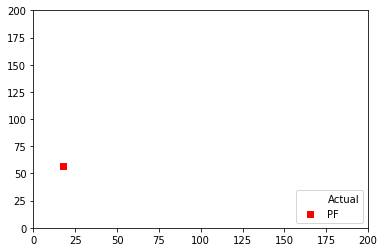

855
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


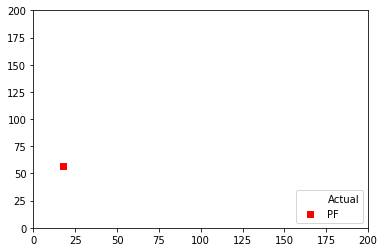

856
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


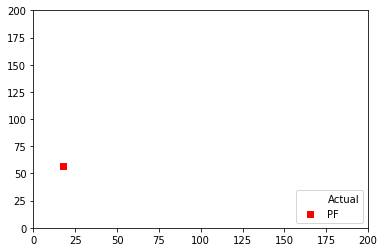

857
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


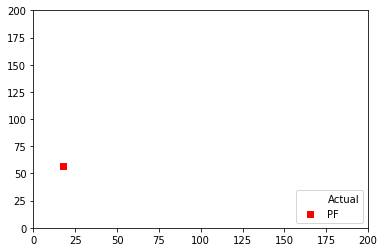

858
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


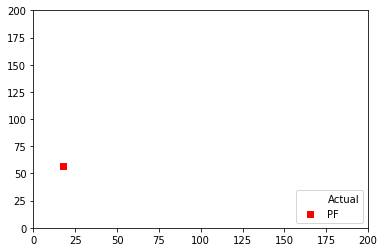

859
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


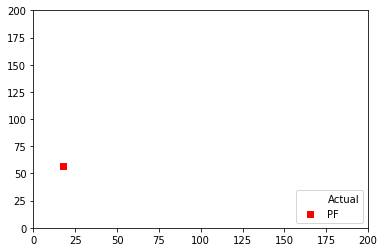

860
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


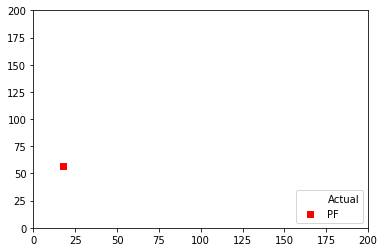

861
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


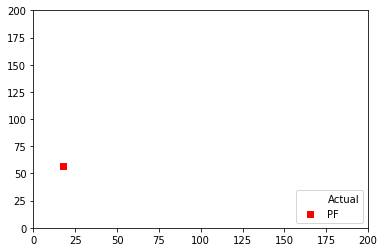

862
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


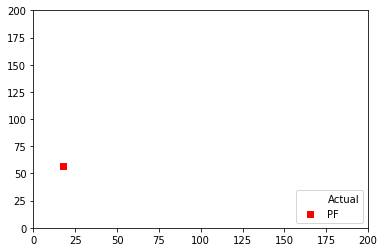

863
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


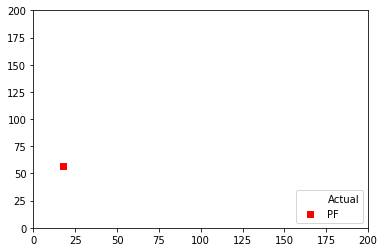

864
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


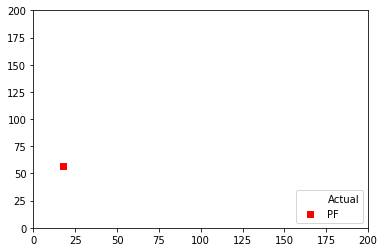

865
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


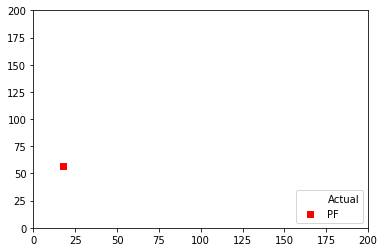

866
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


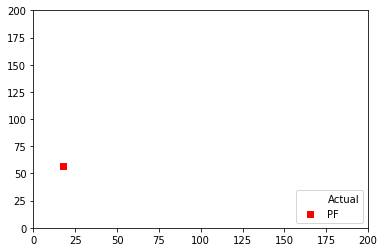

867
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


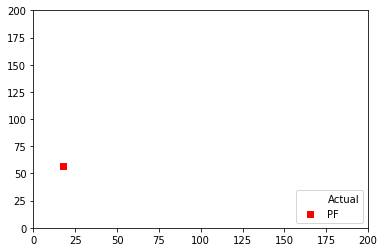

868
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


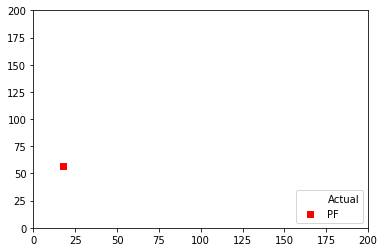

869
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


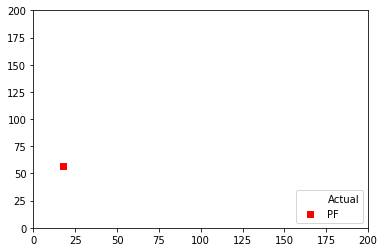

870
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


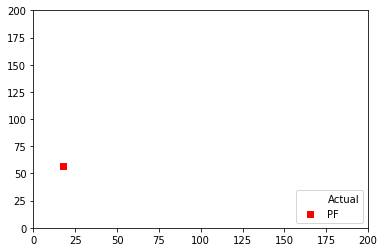

871
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


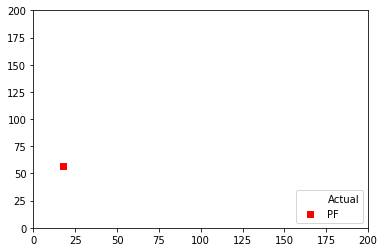

872
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


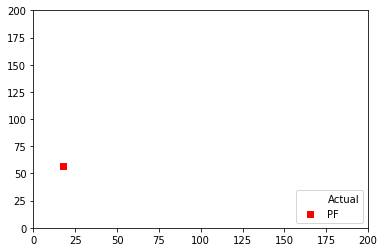

873
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


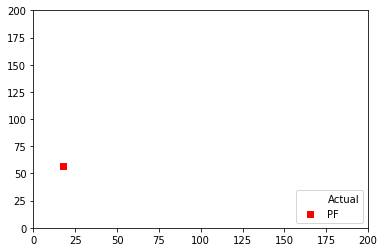

874
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


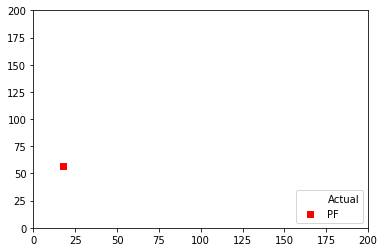

875
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


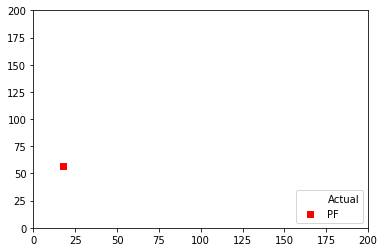

876
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


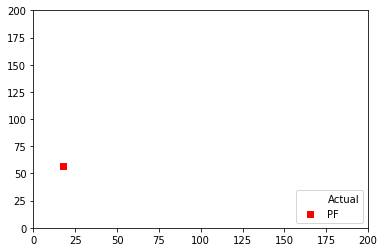

877
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


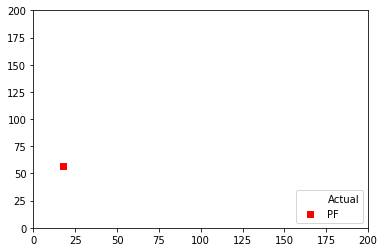

878
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


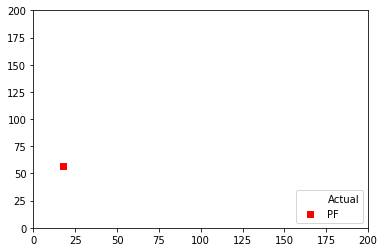

879
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


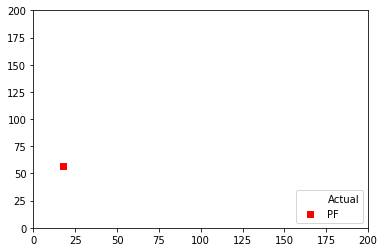

880
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


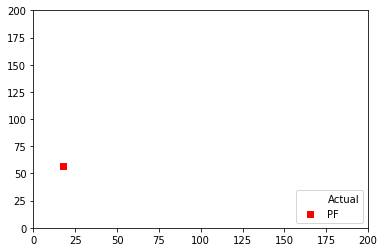

881
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


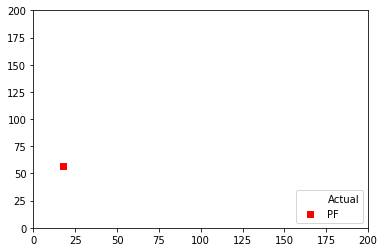

882
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


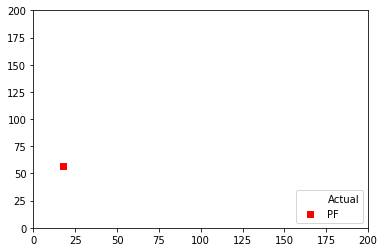

883
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


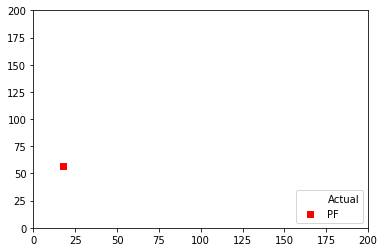

884
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


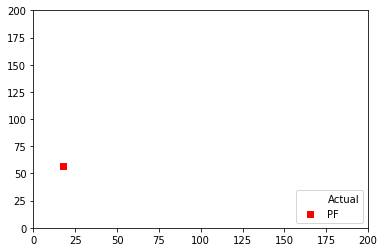

885
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


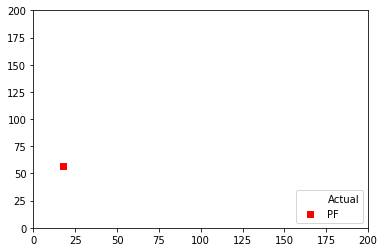

886
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


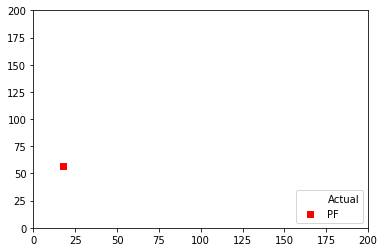

887
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


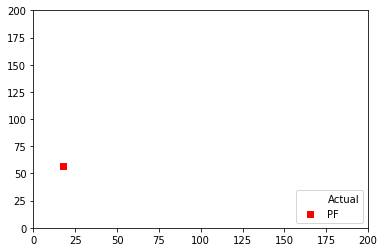

888
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


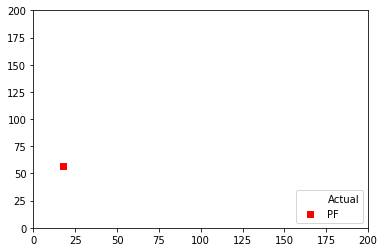

889
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


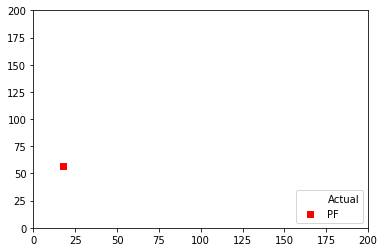

902
infered loc:
[21.         71.05357143]
real loc:
[21.5 75. ]


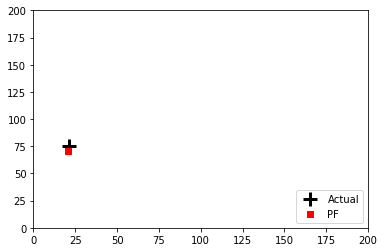

1042
infered loc:
[12.         86.05357143]
real loc:
[ 8.6 86. ]


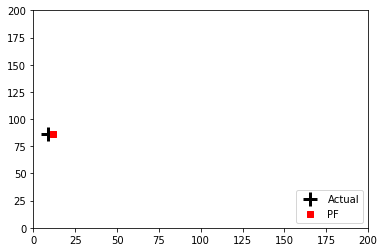

1044
infered loc:
[21.         71.05357143]
real loc:
[15.8 70. ]


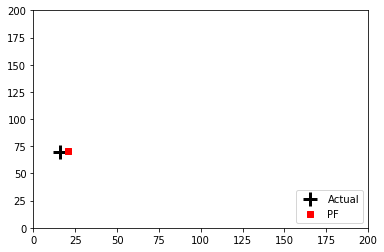

1045
infered loc:
[18.         57.05357143]
real loc:
[19.4 62. ]


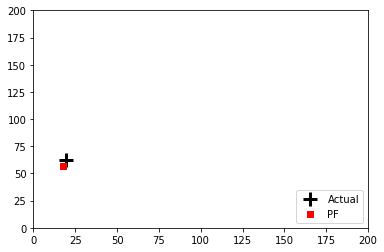

1046
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


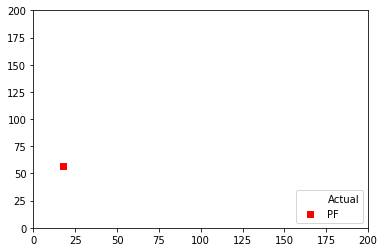

1214
infered loc:
[12.         86.05357143]
real loc:
[13.66667 84.83333]


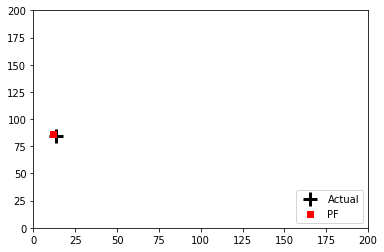

1240
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


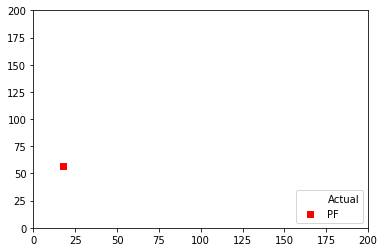

1241
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


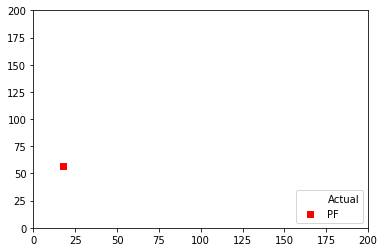

1242
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


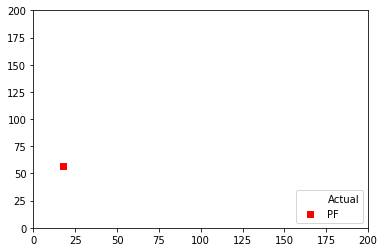

1243
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


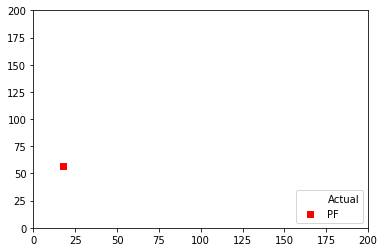

1244
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


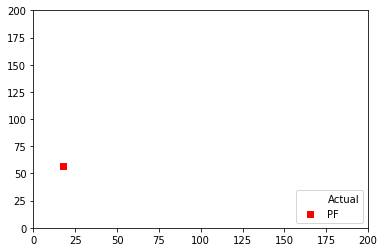

1245
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


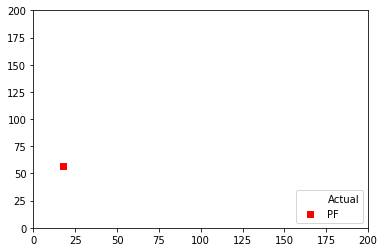

1246
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


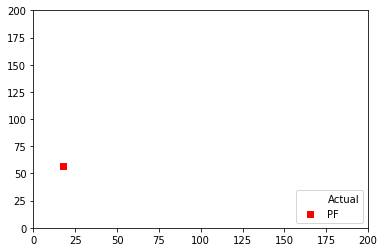

1247
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


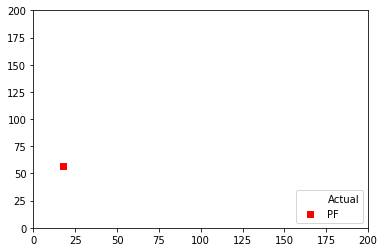

1248
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


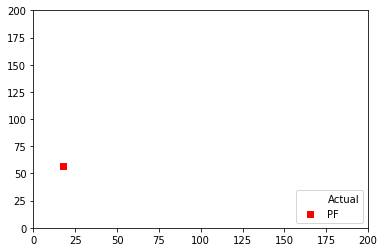

1249
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


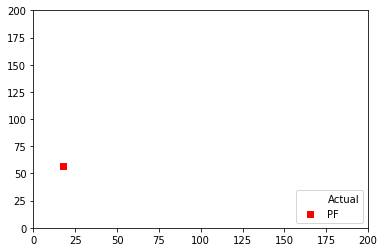

1250
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


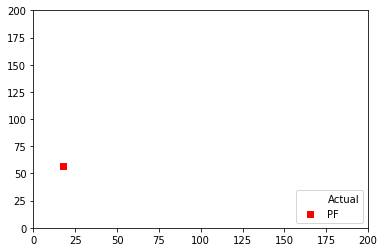

1251
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


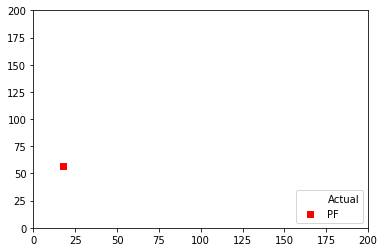

1252
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


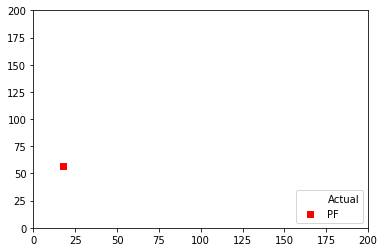

1253
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


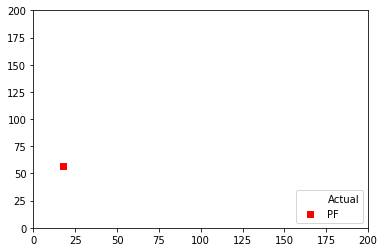

1254
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


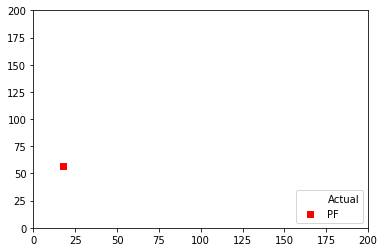

1255
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


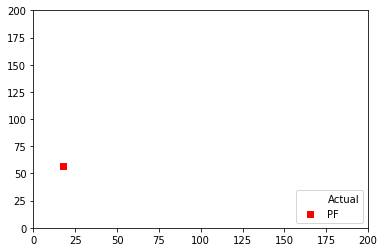

1256
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


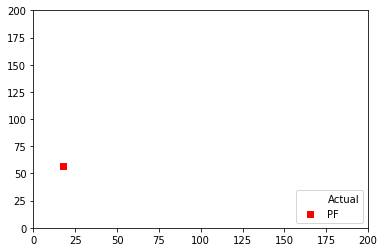

1257
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


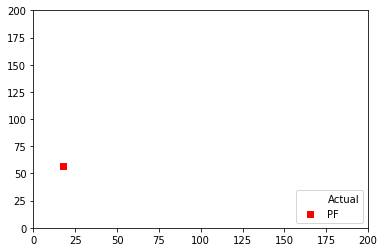

1258
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


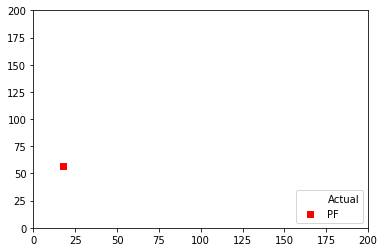

1259
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


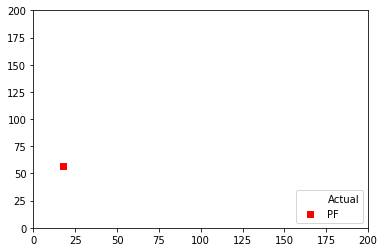

1260
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


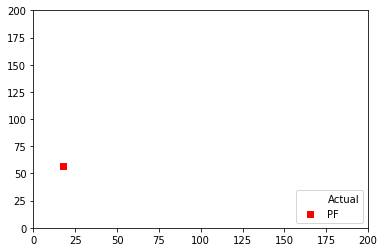

1261
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


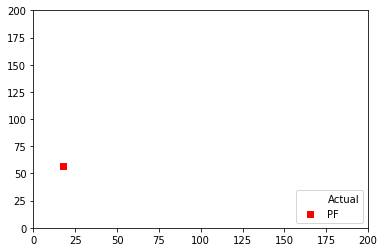

1262
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


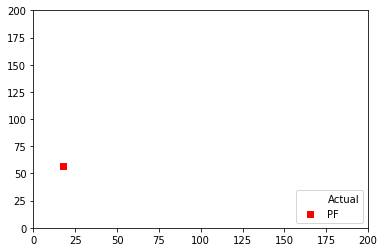

1263
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


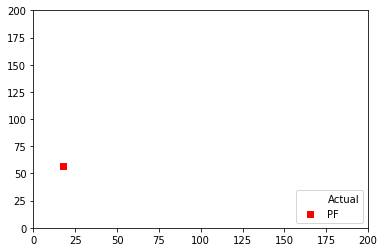

1264
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


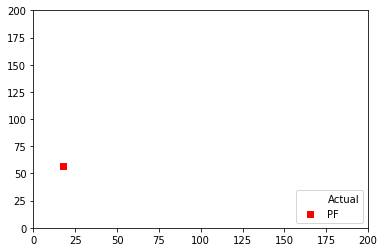

1265
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


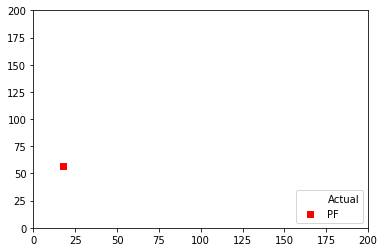

1266
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


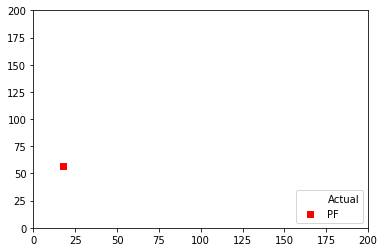

1267
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


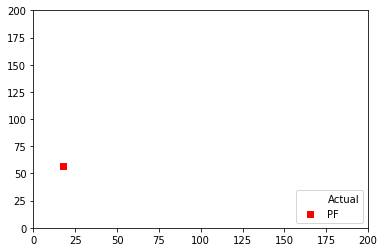

1268
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


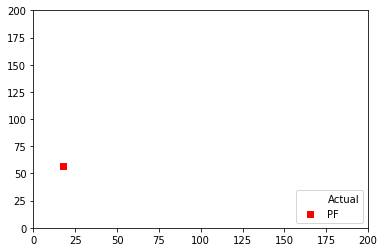

1269
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


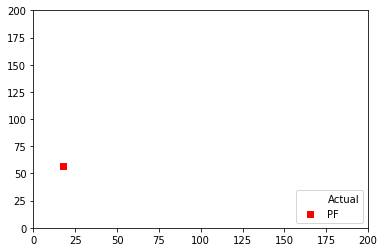

1270
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


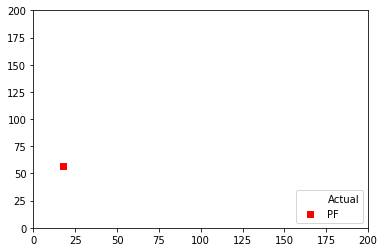

1271
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


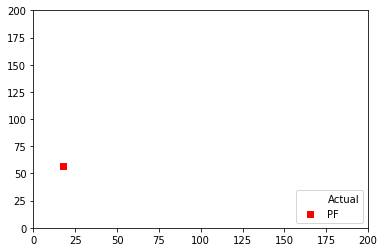

1272
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


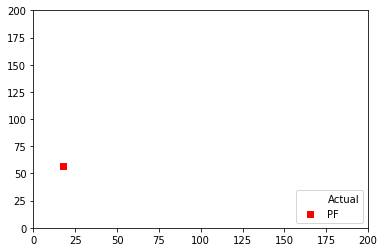

1273
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


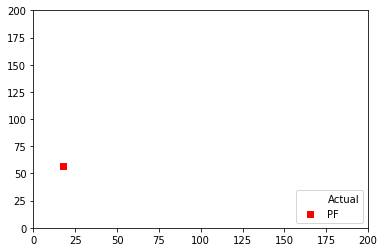

1274
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


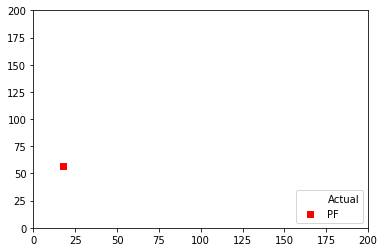

1275
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


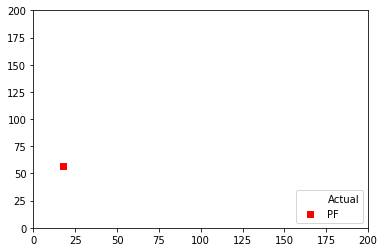

1276
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


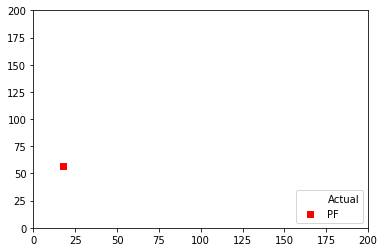

1277
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


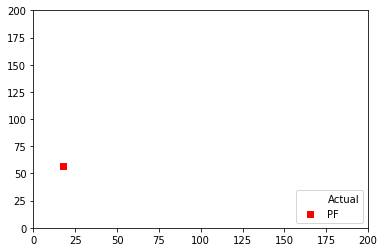

1278
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


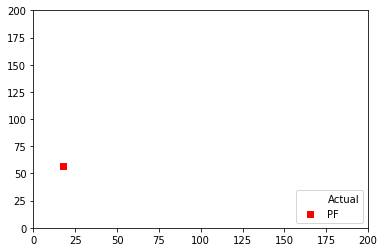

1279
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


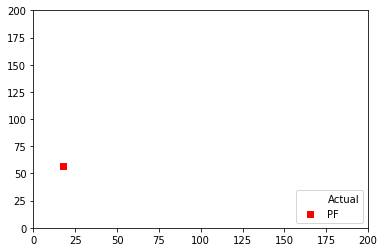

1280
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


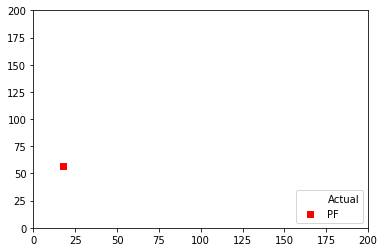

1281
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


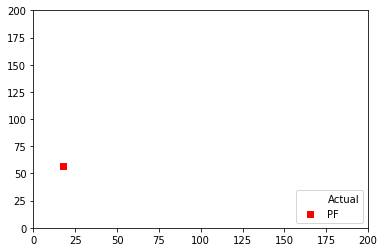

1282
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


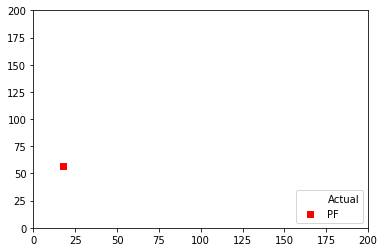

1283
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


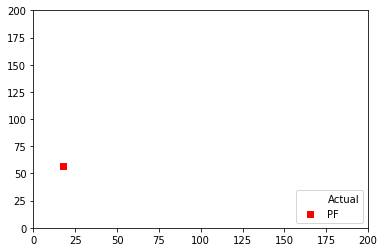

1284
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


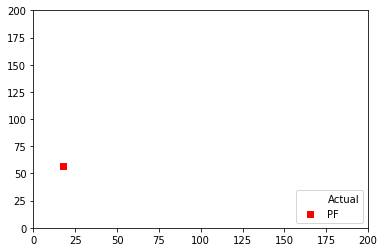

1285
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


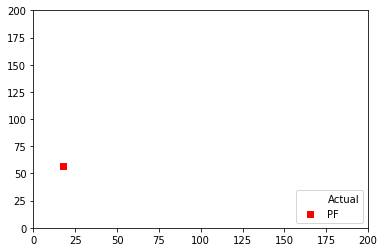

1286
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


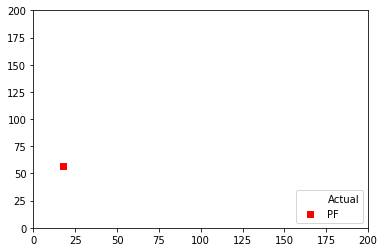

1287
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


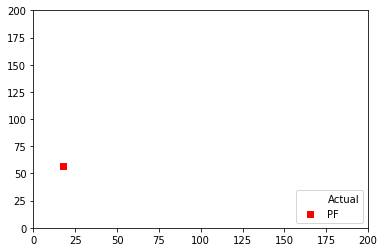

1288
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


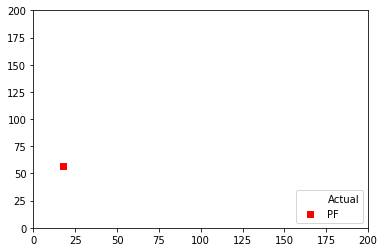

1289
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


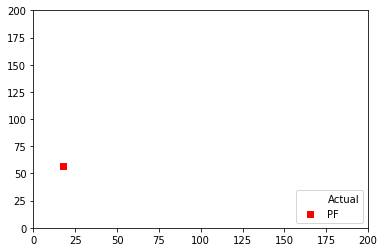

1290
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


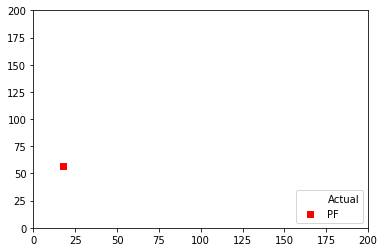

1291
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


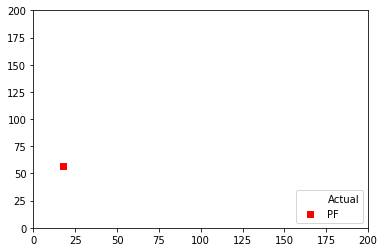

1292
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


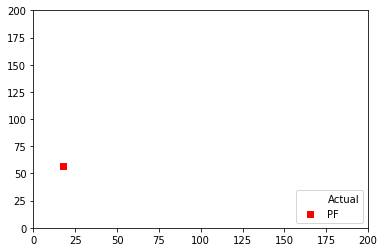

1293
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


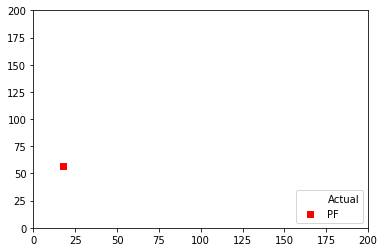

1294
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


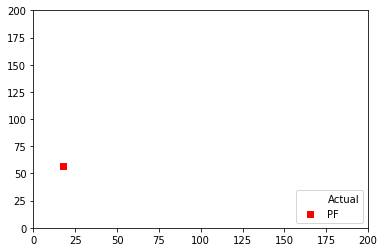

1295
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


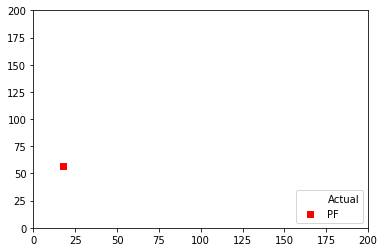

1296
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


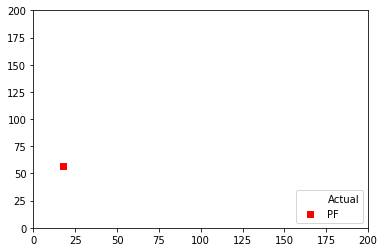

1297
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


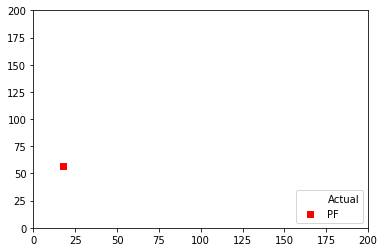

1298
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


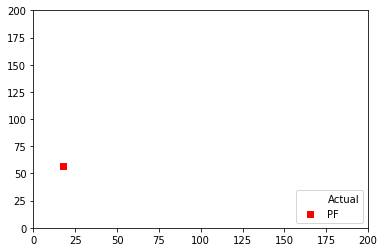

1299
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


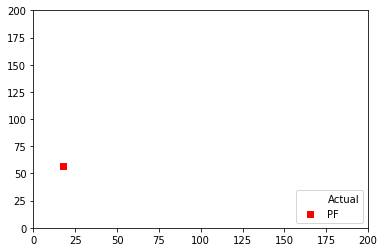

1300
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


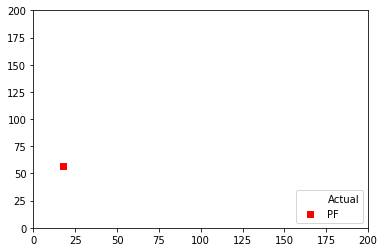

1301
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


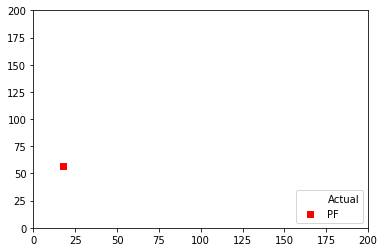

1302
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


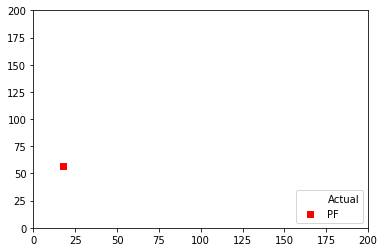

1303
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


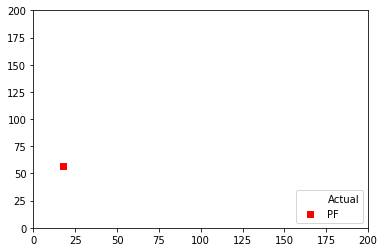

1304
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


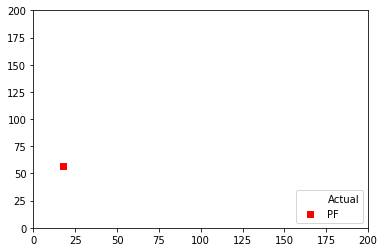

1305
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


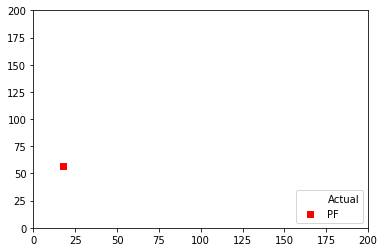

1306
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


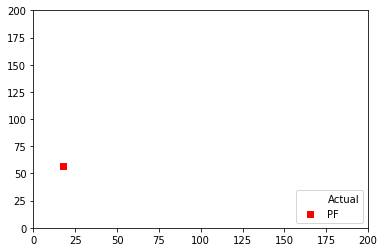

1307
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


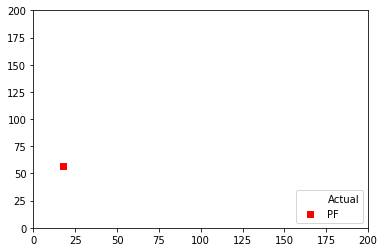

1308
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


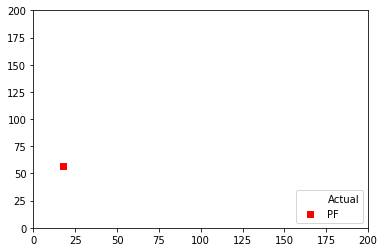

1309
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


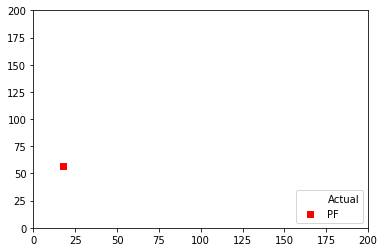

1310
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


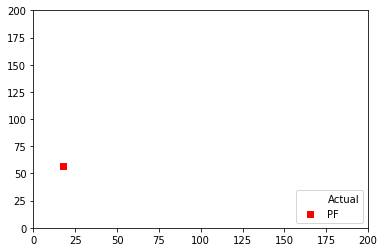

1311
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


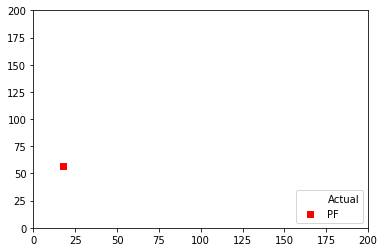

1312
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


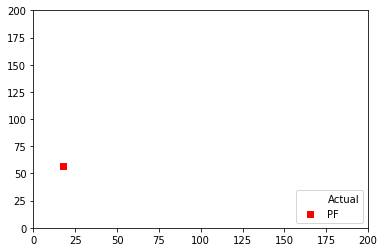

1313
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


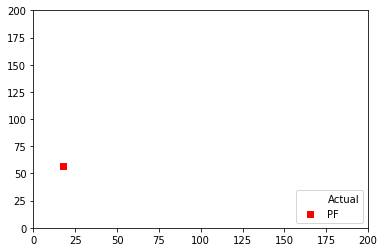

1314
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


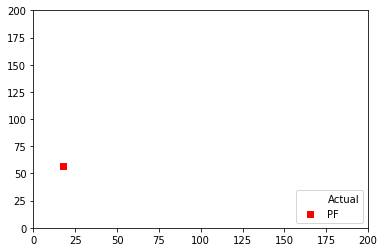

1315
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


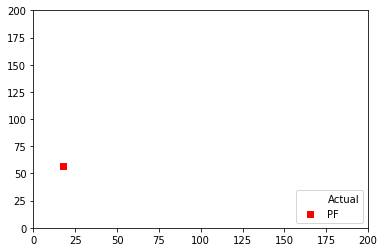

1316
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


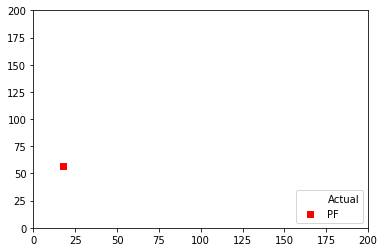

1317
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


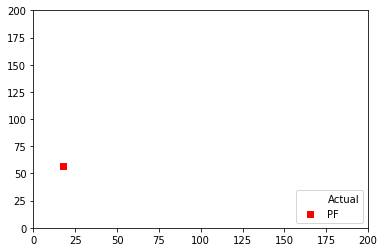

1318
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


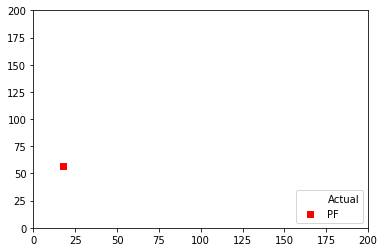

1319
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


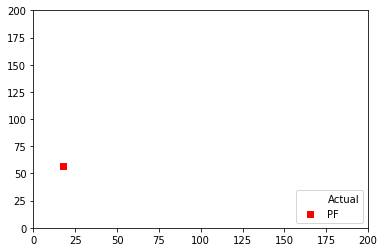

1320
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


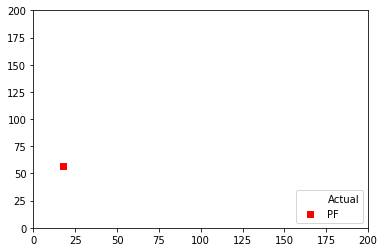

1321
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


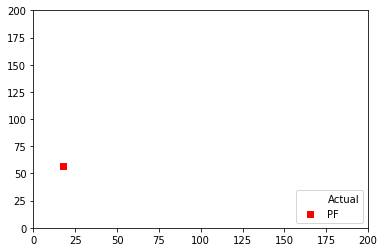

1322
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


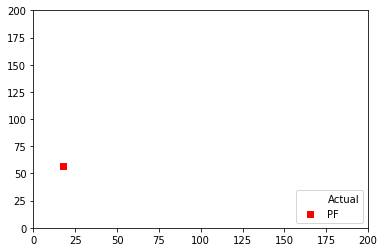

1323
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


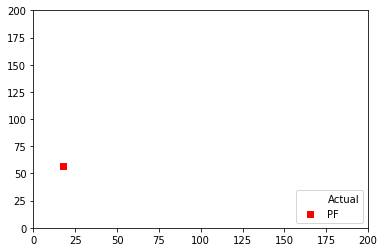

1324
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


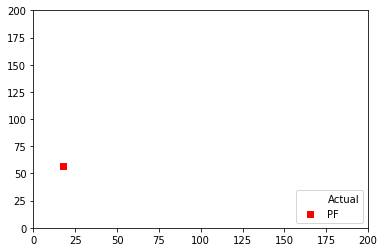

1325
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


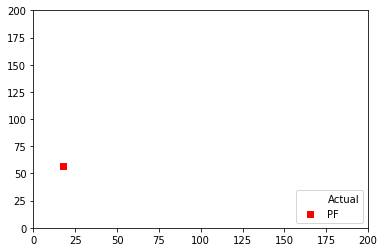

1326
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


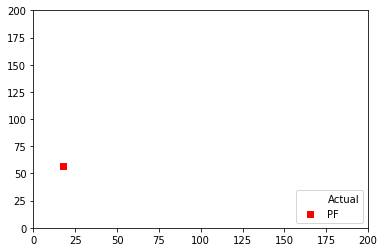

1327
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


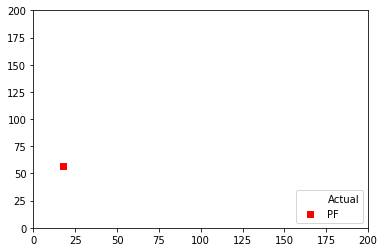

1328
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


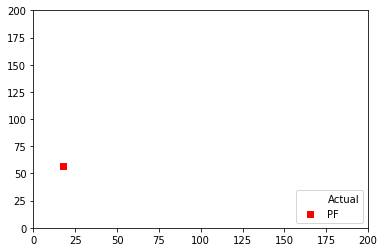

1329
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


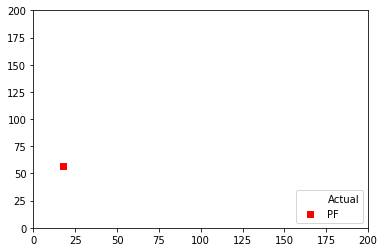

1330
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


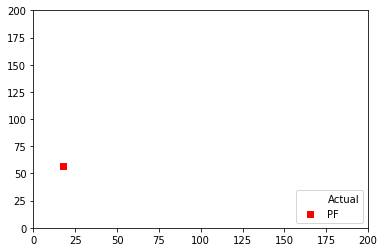

1331
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


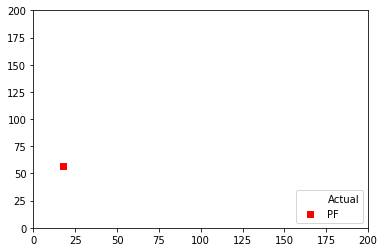

1332
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


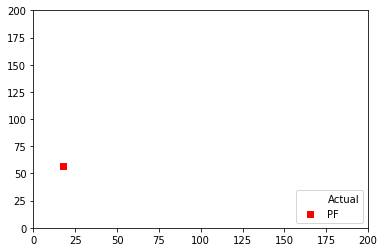

1333
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


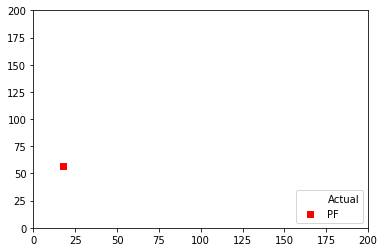

1334
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


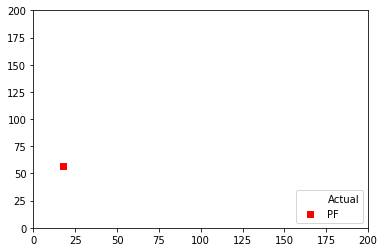

1335
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


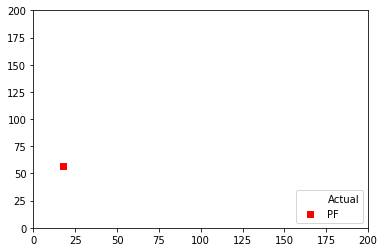

1336
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


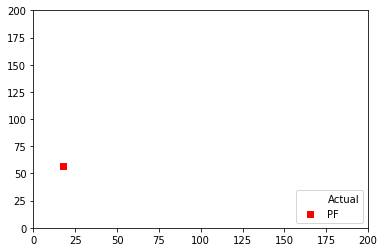

1337
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


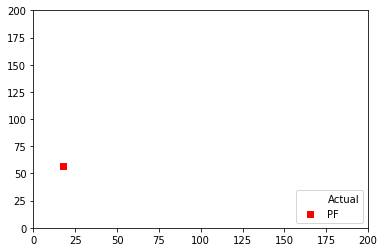

1338
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


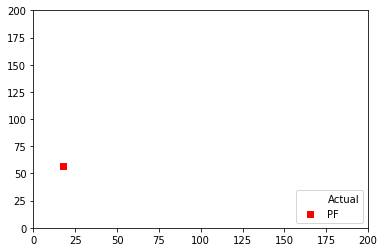

1339
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


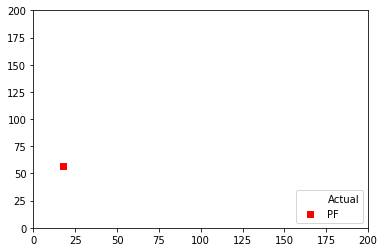

1340
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


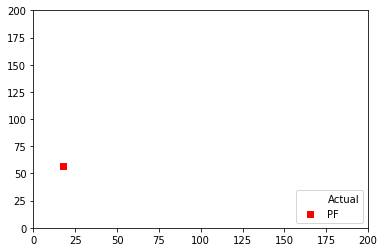

1341
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


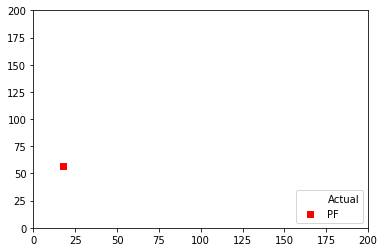

1342
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


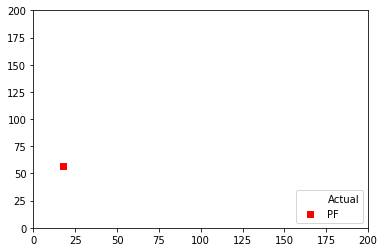

1343
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


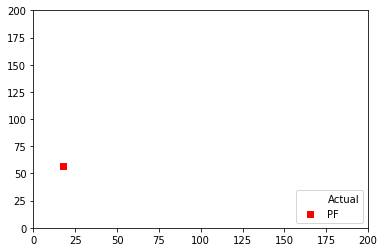

1344
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


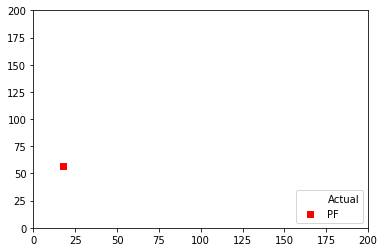

1345
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


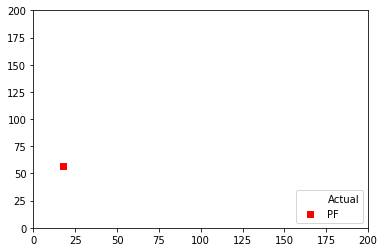

1346
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


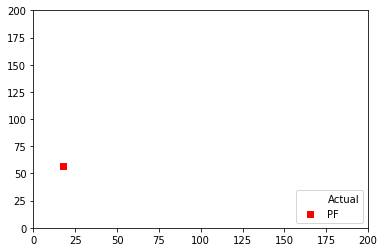

1347
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


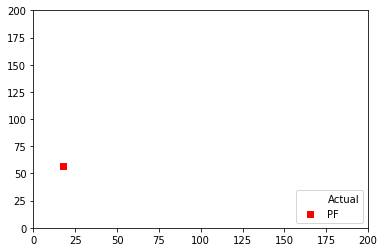

1348
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


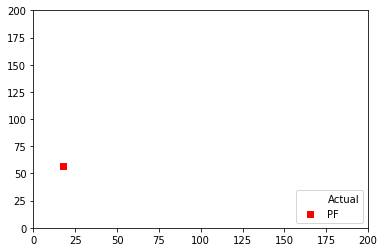

1349
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


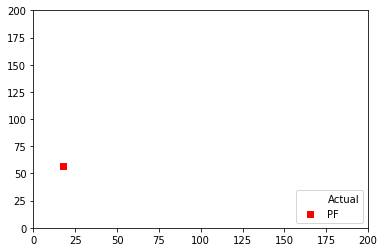

1350
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


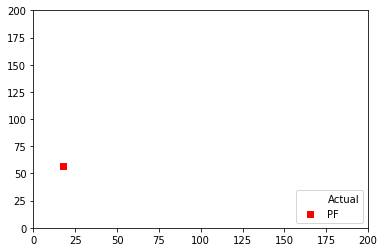

1351
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


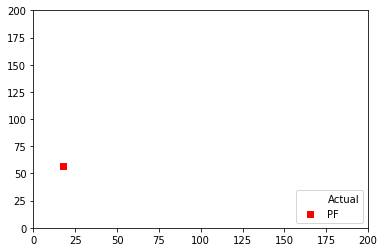

1352
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


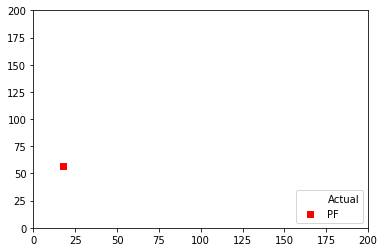

1353
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


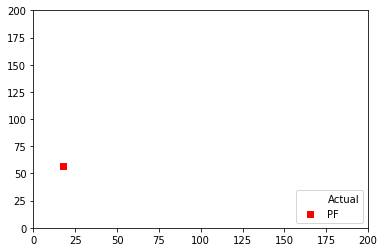

1354
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


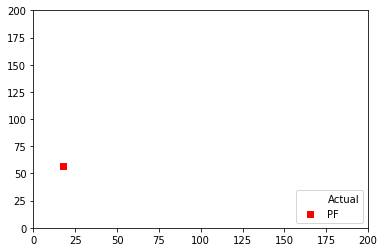

1355
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


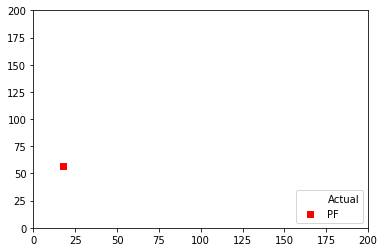

1356
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


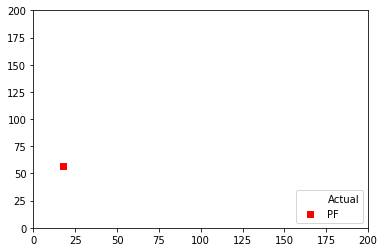

1357
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


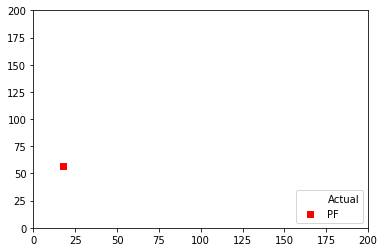

1358
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


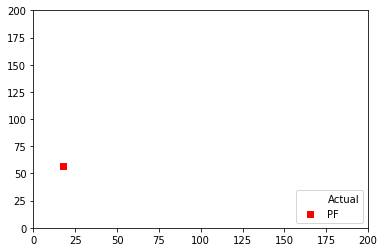

1359
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


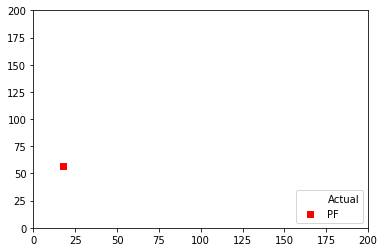

1360
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


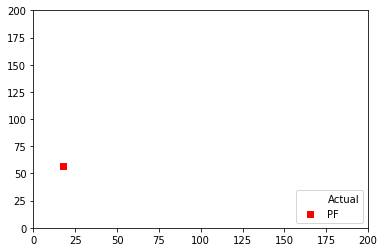

1361
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


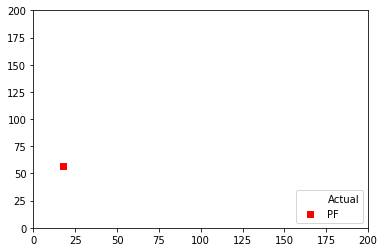

1362
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


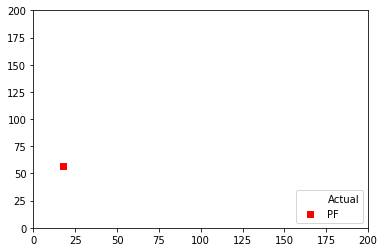

1363
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


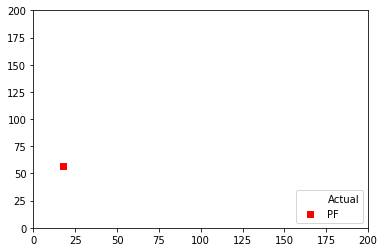

1364
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


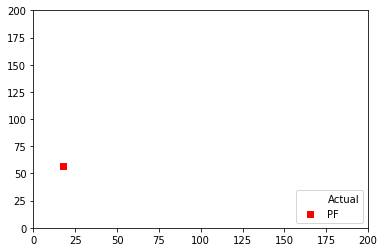

1365
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


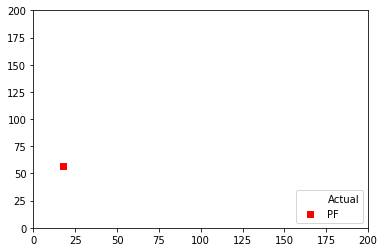

1366
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


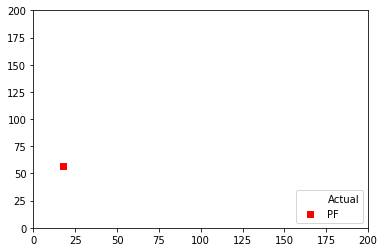

1367
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


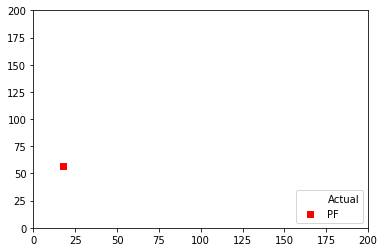

1368
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


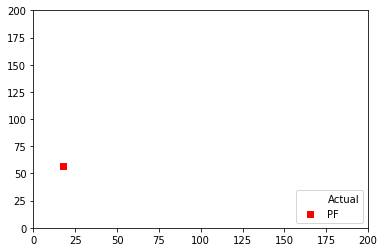

1369
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


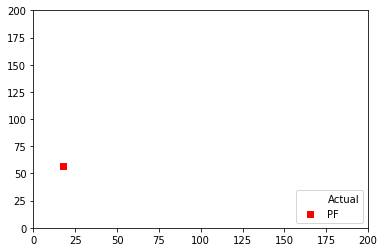

1370
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


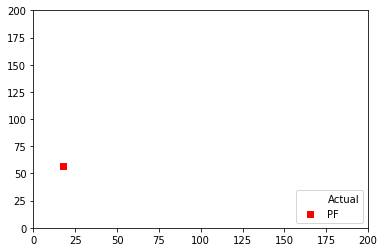

1371
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


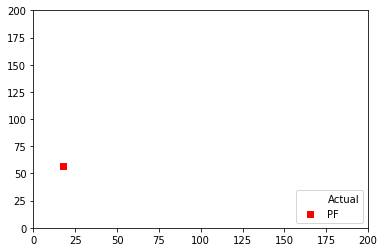

1372
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


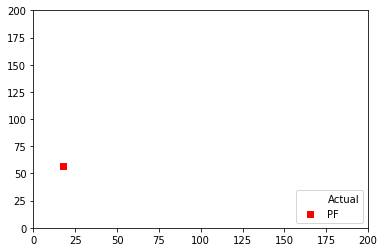

1373
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


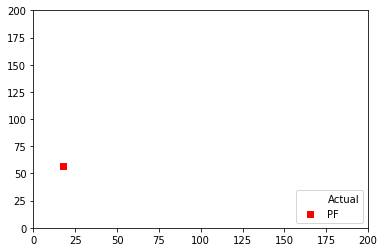

1374
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


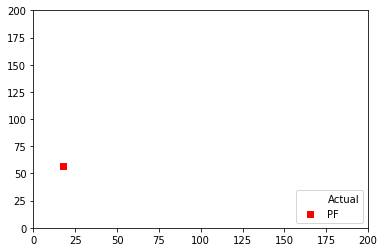

1375
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


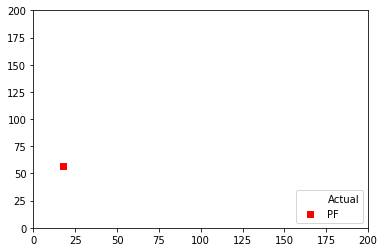

1376
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


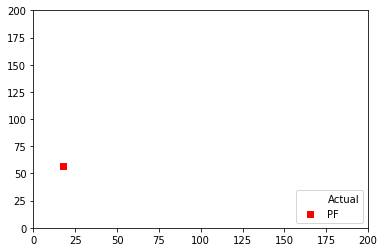

1377
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


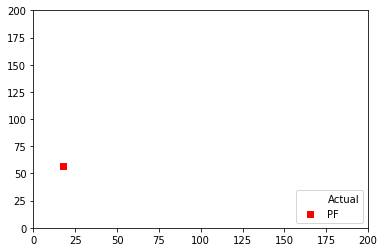

1378
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


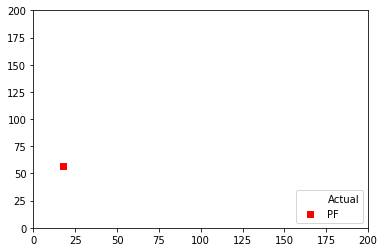

1379
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


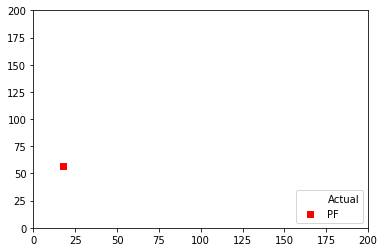

1380
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


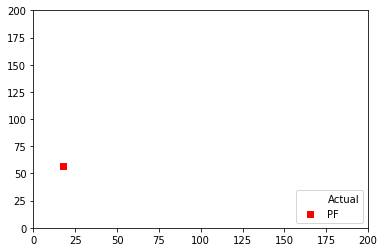

1381
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


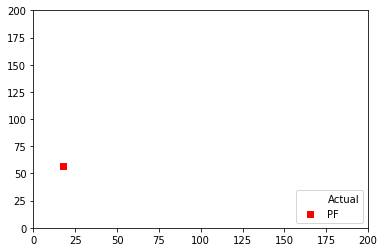

1382
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


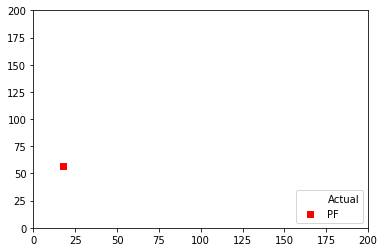

1383
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


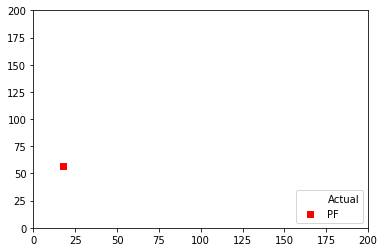

1384
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


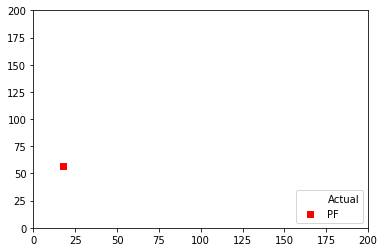

1385
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


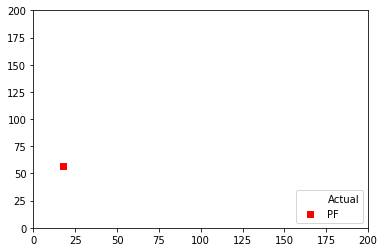

1386
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


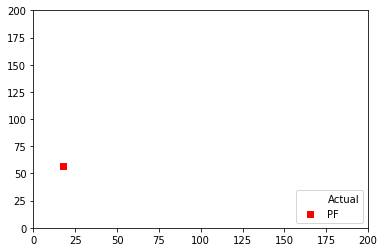

1387
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


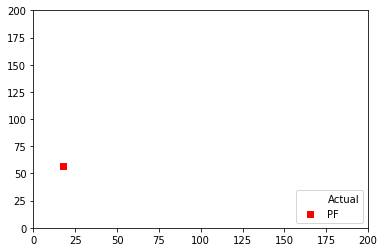

1388
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


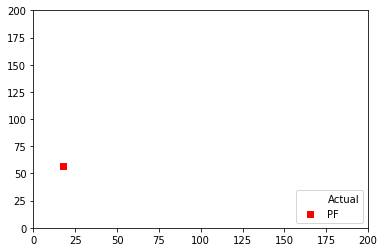

1389
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


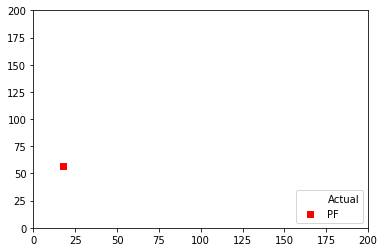

1390
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


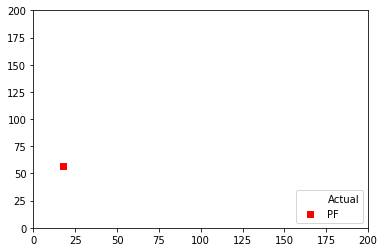

1391
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


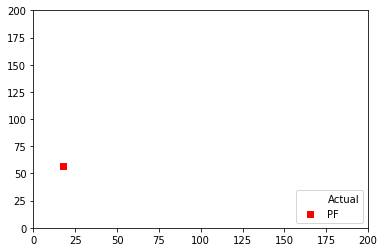

1392
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


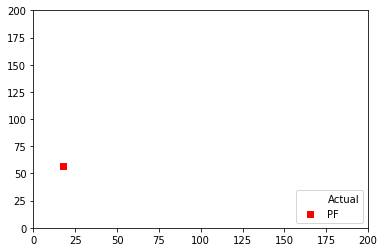

1393
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


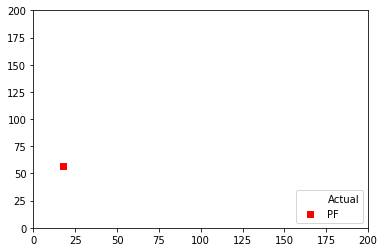

1394
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


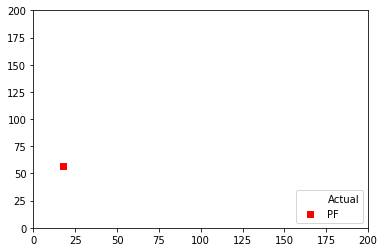

1395
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


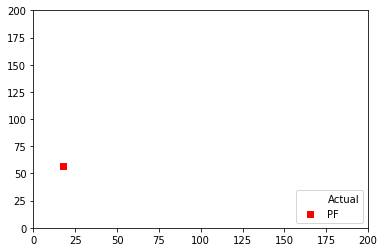

1396
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


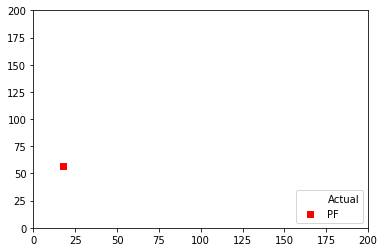

1397
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


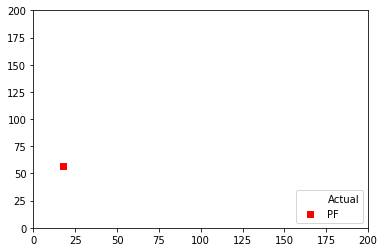

1398
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


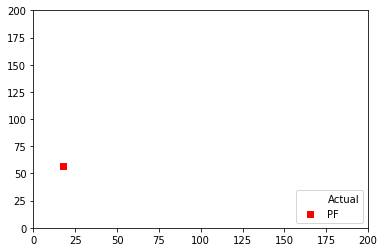

1399
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


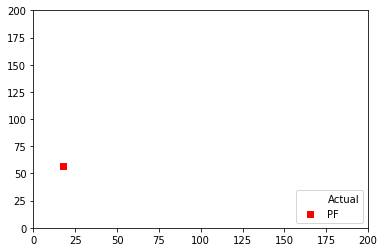

1400
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


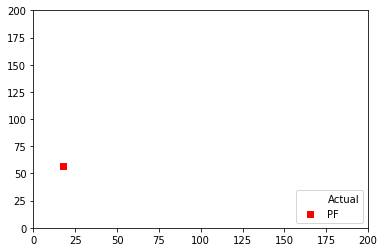

1401
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


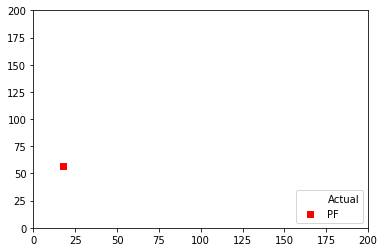

1402
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


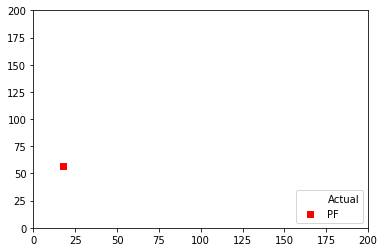

1403
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


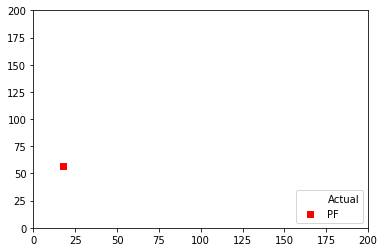

1404
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


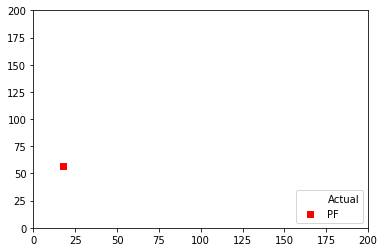

1405
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


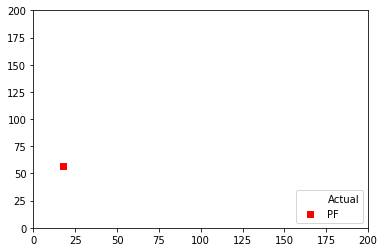

1406
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


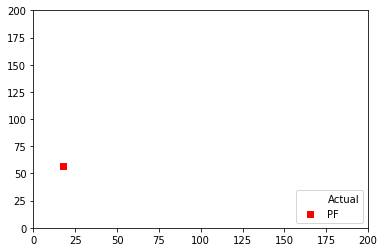

1407
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


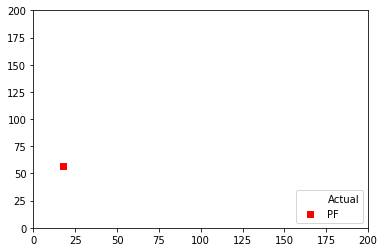

1408
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


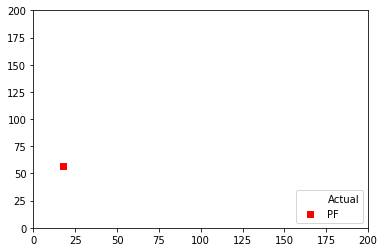

1409
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


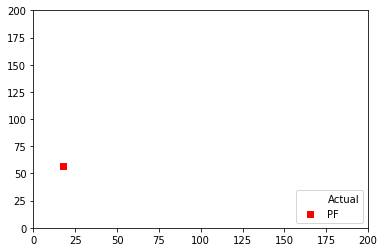

1410
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


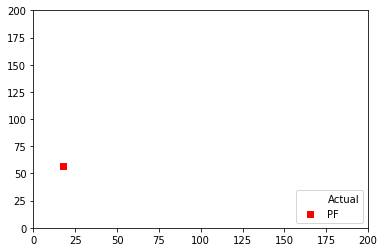

1411
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


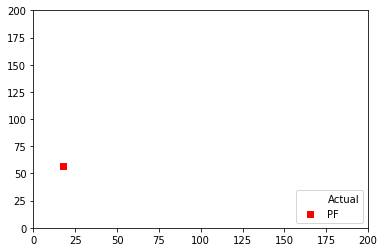

1412
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


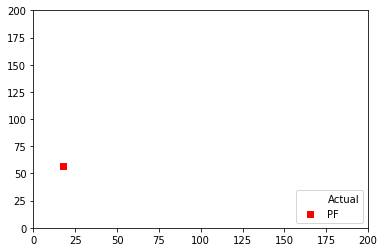

1413
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


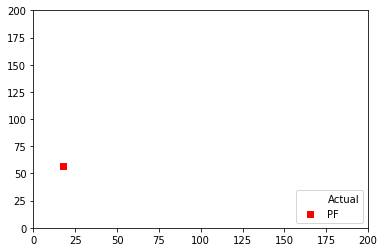

1414
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


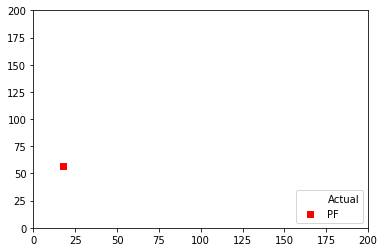

1415
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


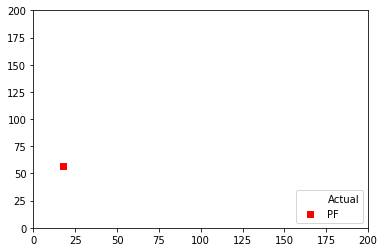

1416
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


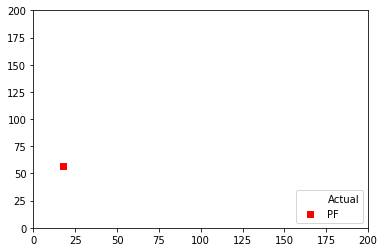

1417
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


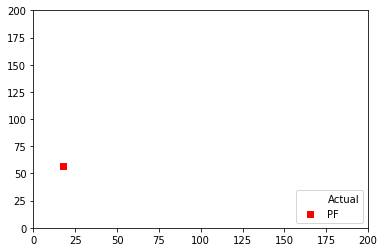

1418
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


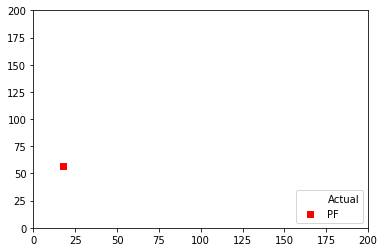

1419
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


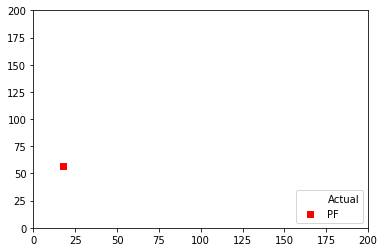

1420
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


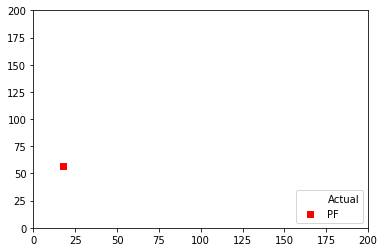

1421
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


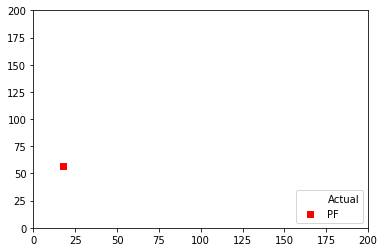

1422
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


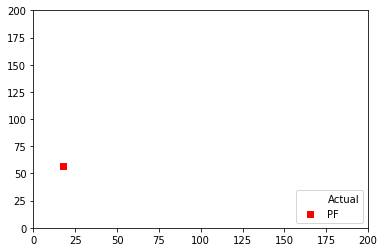

1423
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


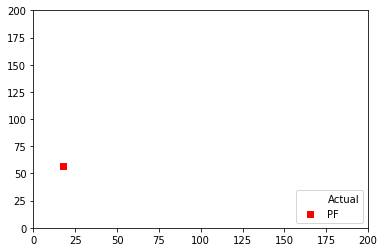

1424
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


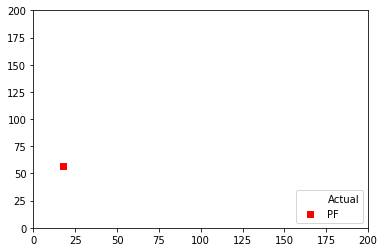

1425
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


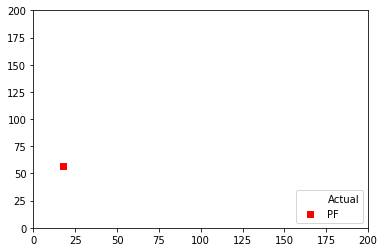

1426
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


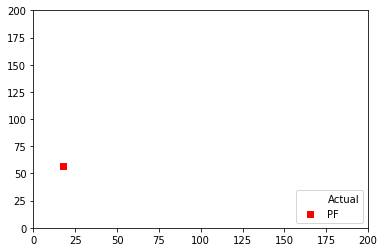

1427
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


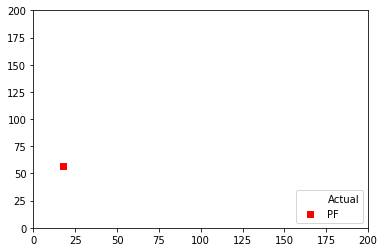

1428
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


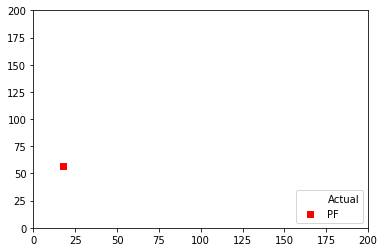

1429
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


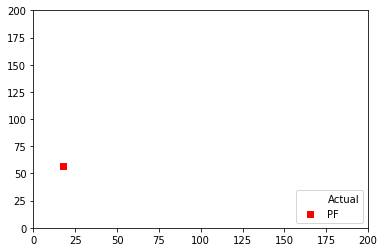

1430
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


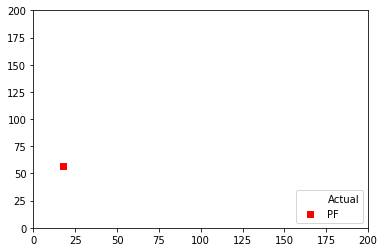

1431
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


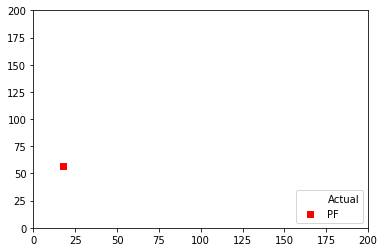

1432
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


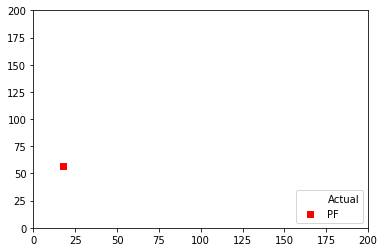

1433
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


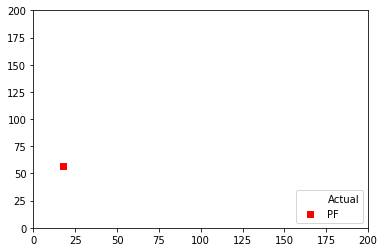

1434
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


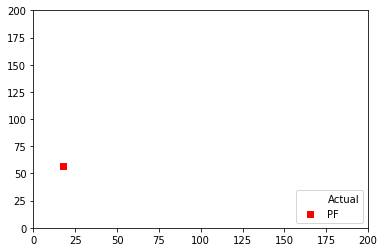

1435
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


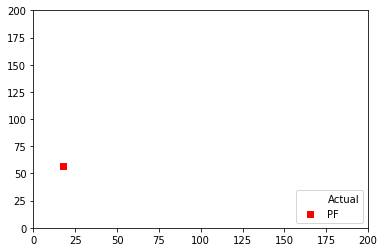

1436
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


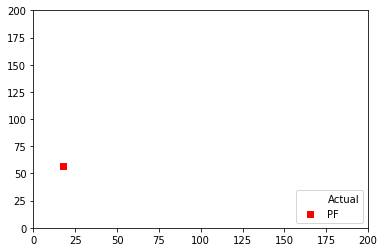

1437
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


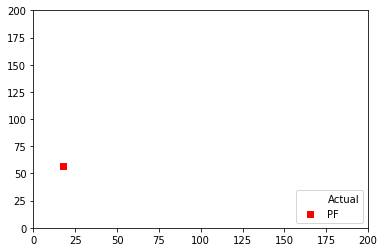

1438
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


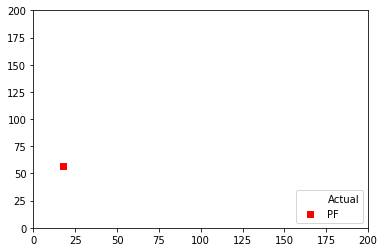

1439
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


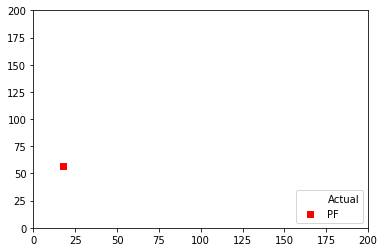

1440
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


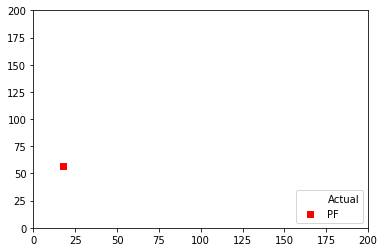

1441
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


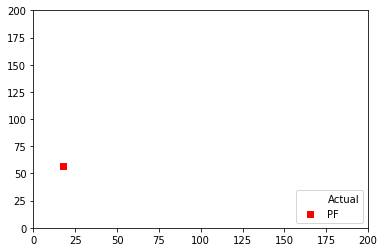

1442
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


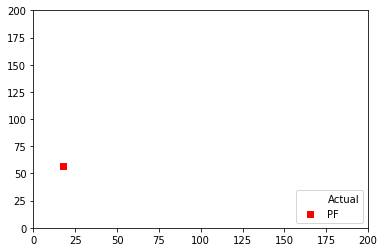

1443
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


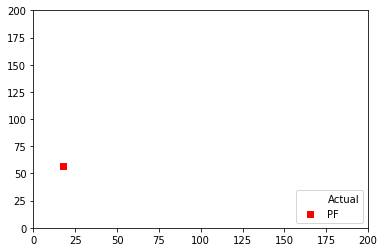

1444
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


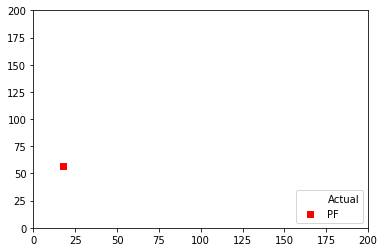

1445
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


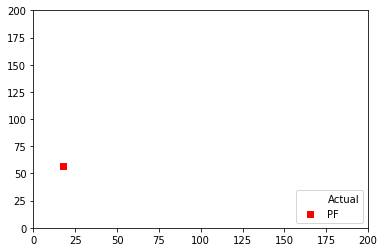

1446
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


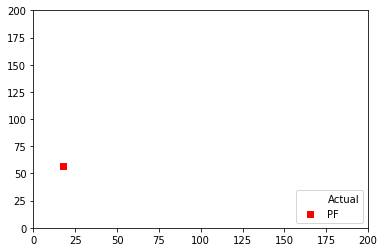

1447
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


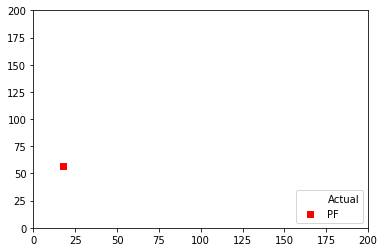

1448
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


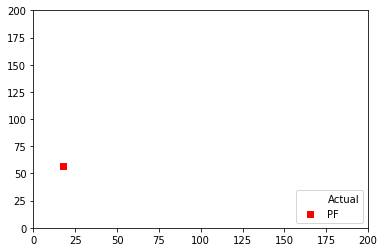

1449
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


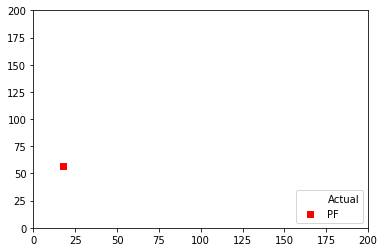

1450
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


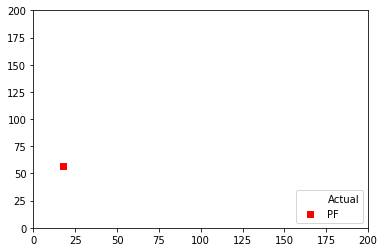

1451
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


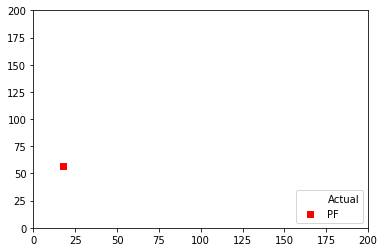

1452
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


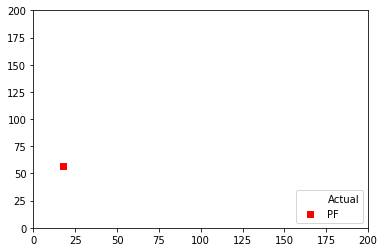

1453
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


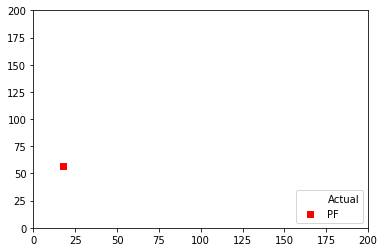

1454
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


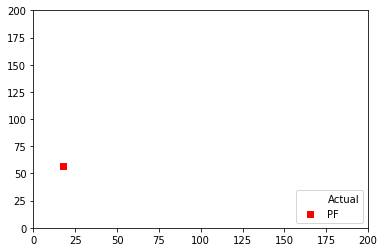

1455
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


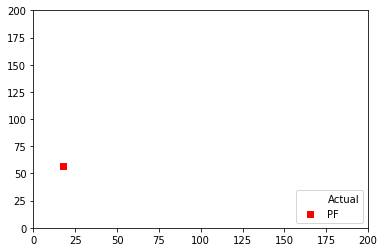

1456
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


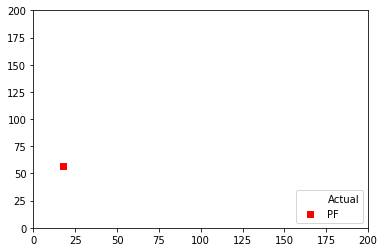

1457
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


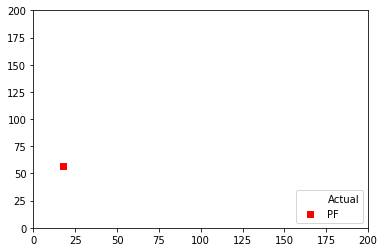

1458
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


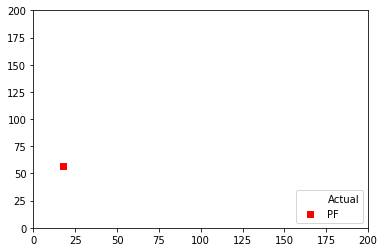

1459
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


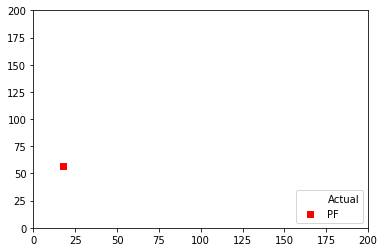

1460
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


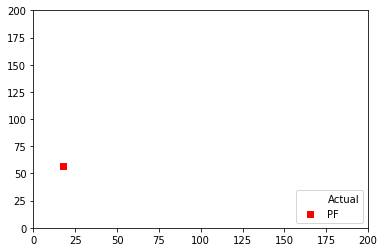

1461
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


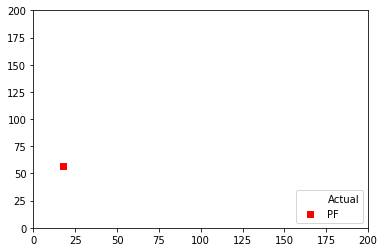

1462
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


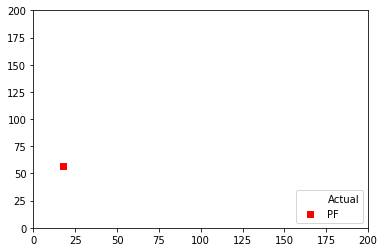

1463
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


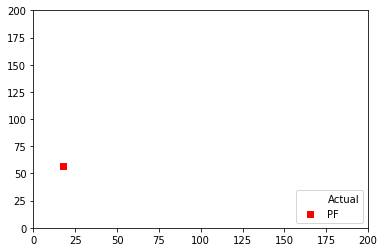

1464
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


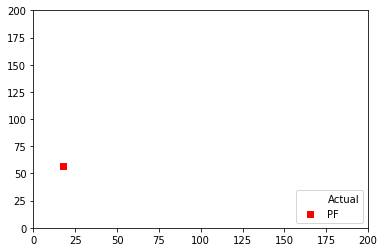

1465
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


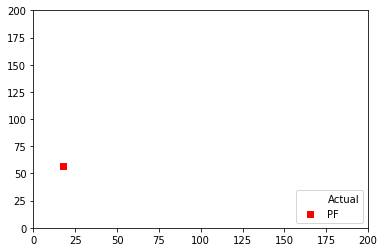

1466
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


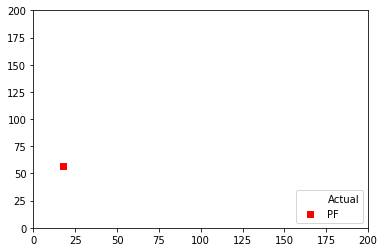

1467
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


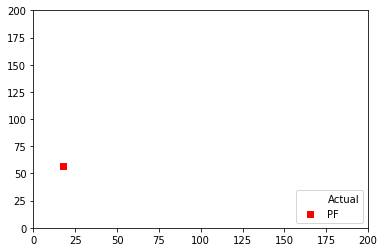

1468
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


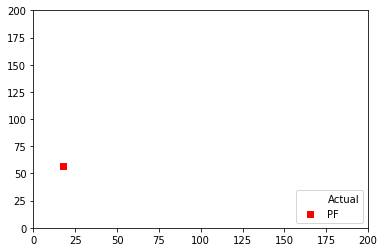

1469
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


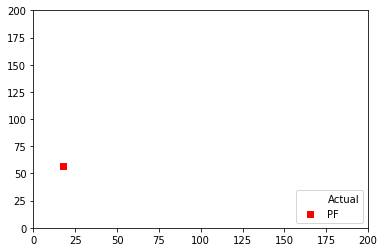

1470
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


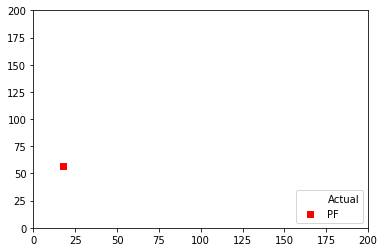

1471
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


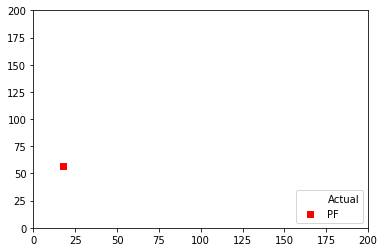

1472
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


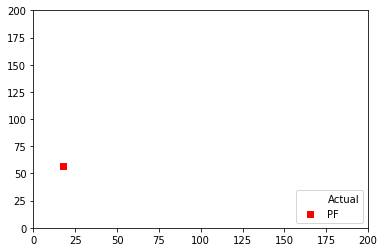

1473
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


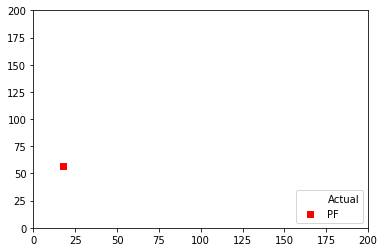

1474
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


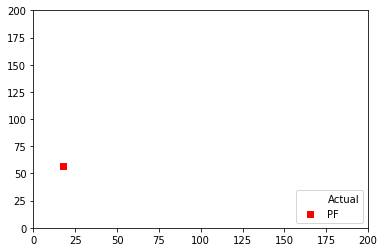

1475
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


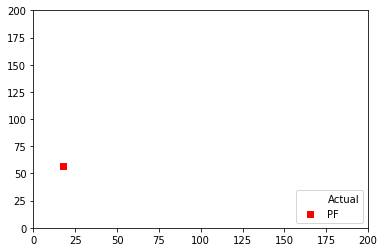

1476
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


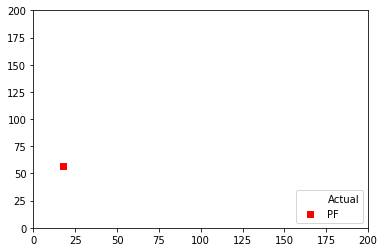

1477
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


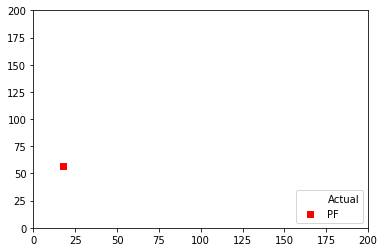

1478
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


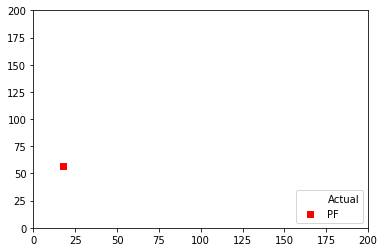

1479
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


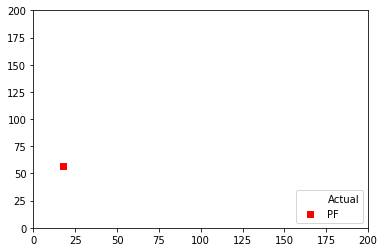

1480
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


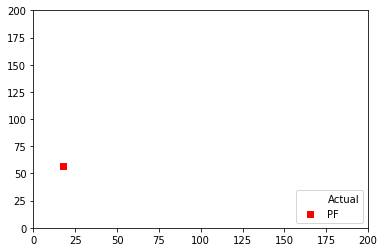

1481
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


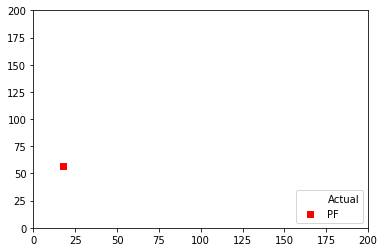

1482
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


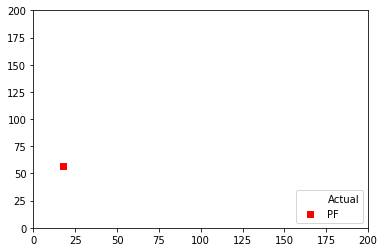

1483
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


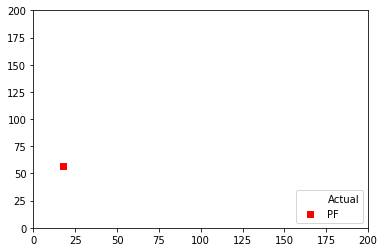

1484
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


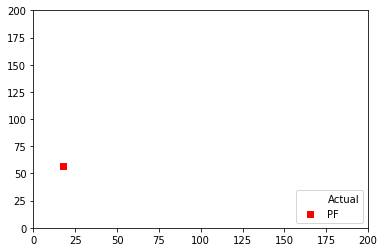

1485
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


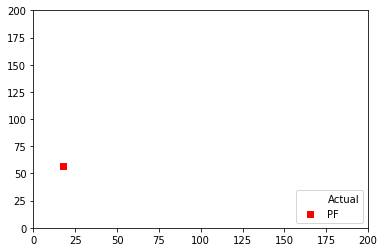

1486
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


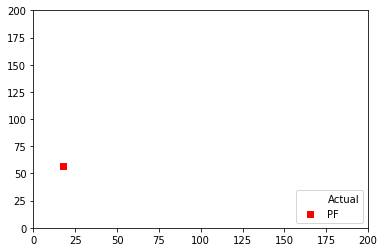

1487
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


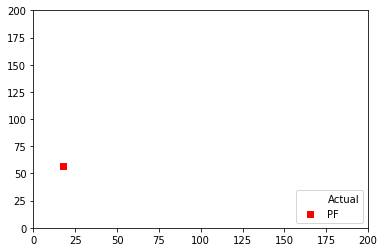

1488
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


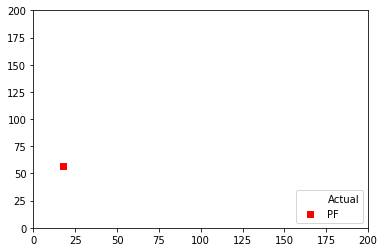

1489
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


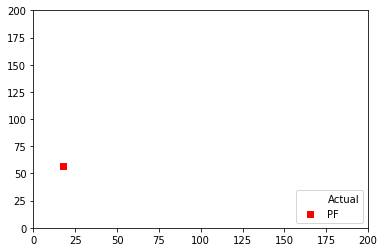

1490
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


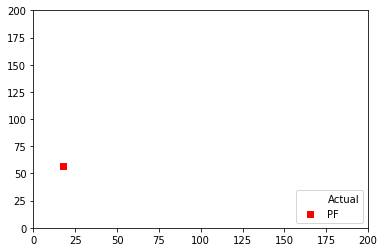

1491
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


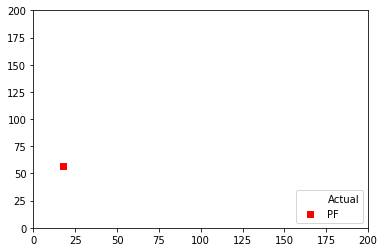

1492
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


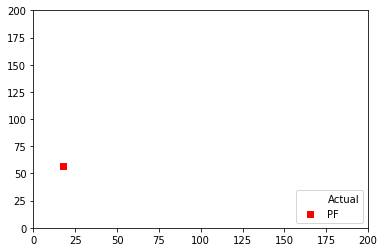

1493
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


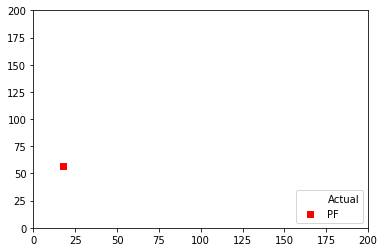

1494
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


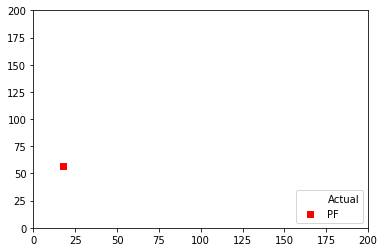

1495
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


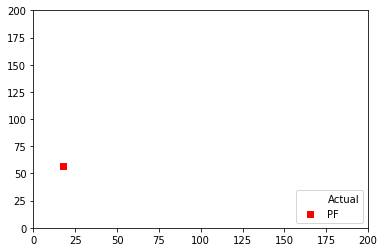

1496
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


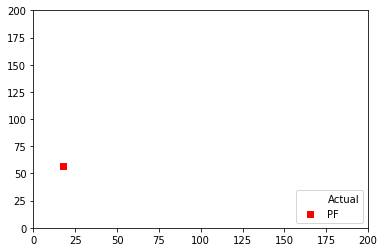

1497
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


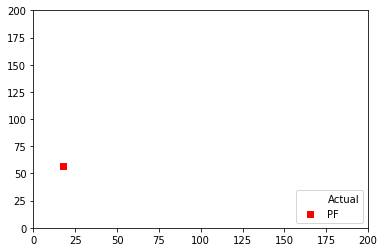

1498
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


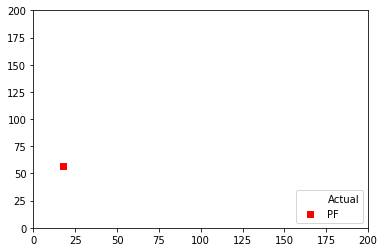

1499
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


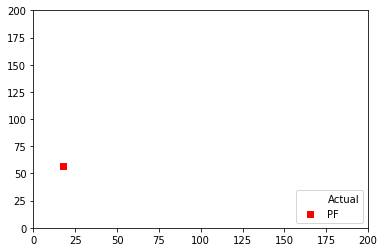

1500
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


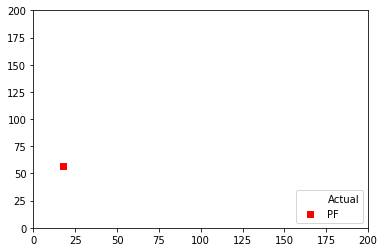

1501
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


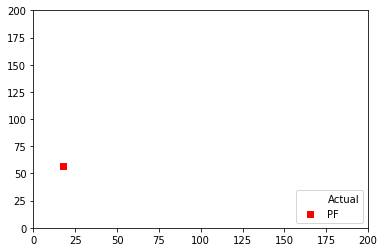

1502
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


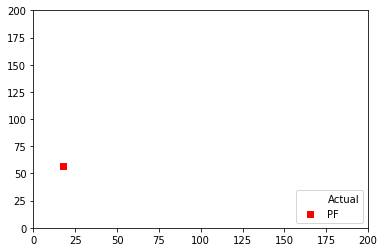

1503
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


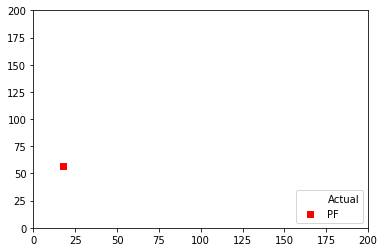

1504
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


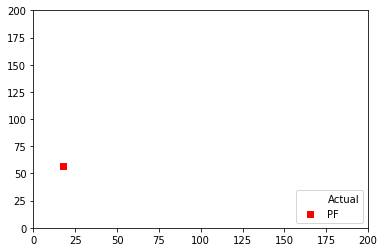

1505
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


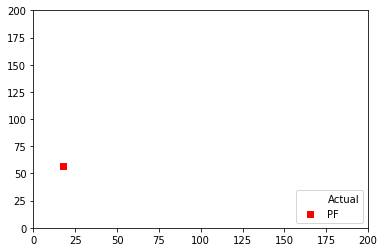

1506
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


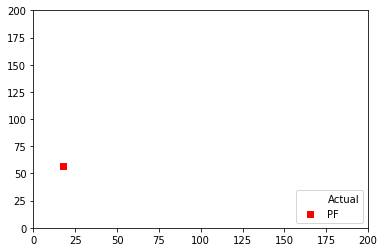

1507
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


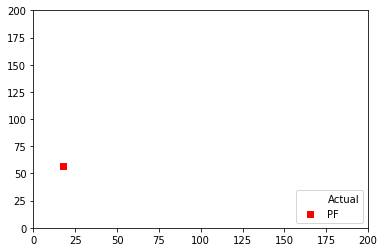

1508
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


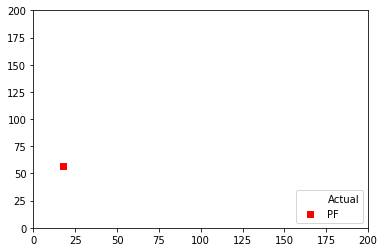

1509
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


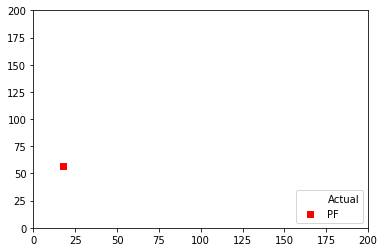

1510
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


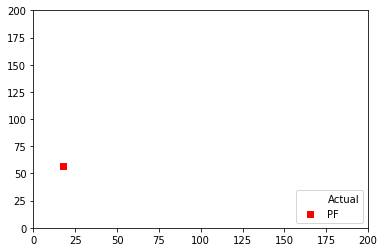

1511
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


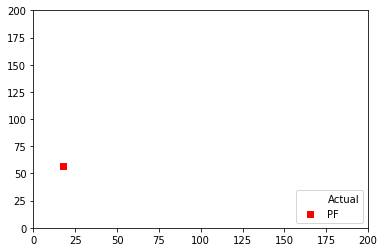

1512
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


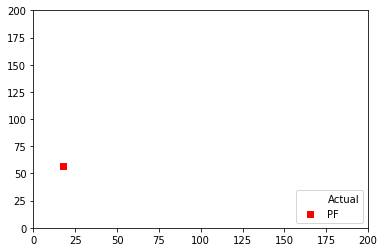

1513
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


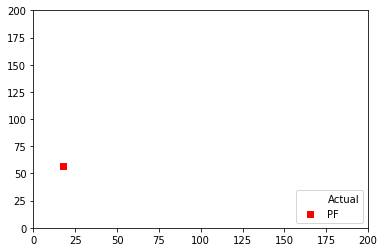

1514
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


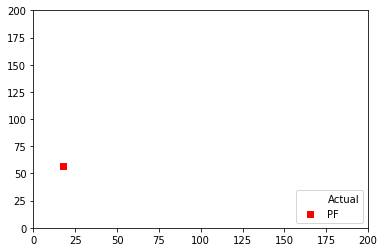

1515
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


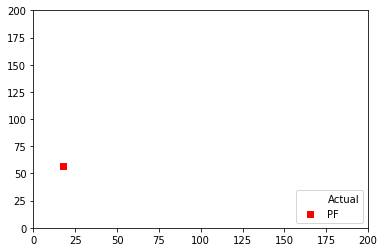

1516
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


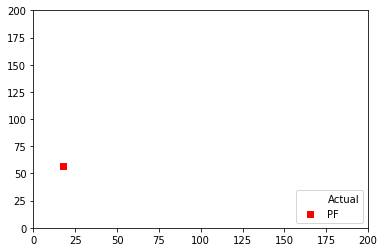

1517
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


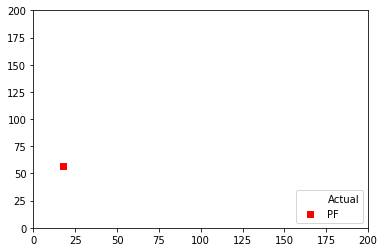

1518
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


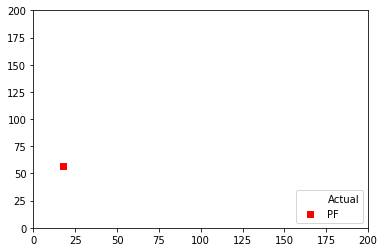

1519
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


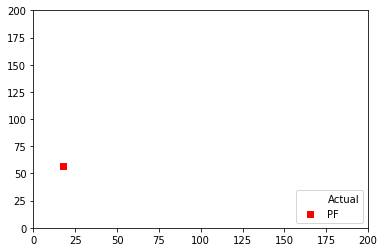

1520
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


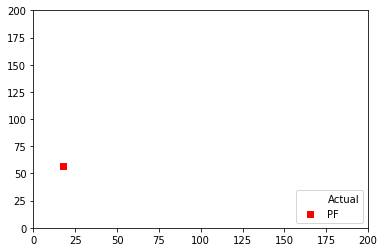

1521
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


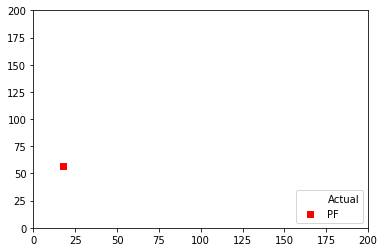

1522
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


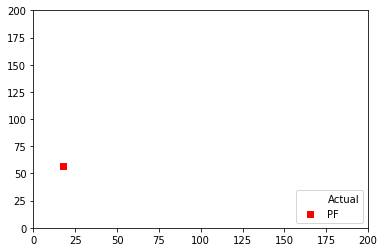

1523
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


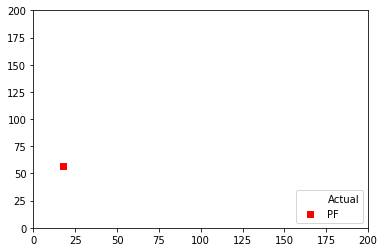

1524
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


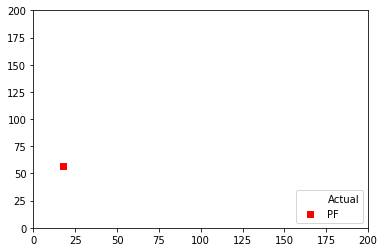

1525
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


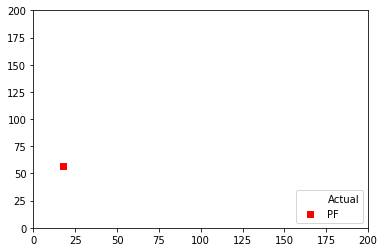

1526
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


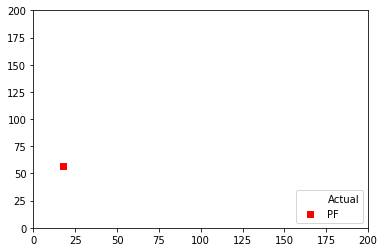

1527
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


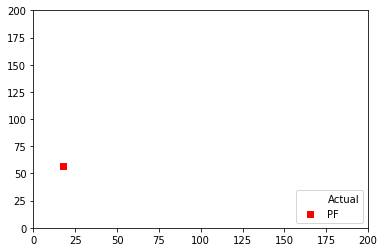

1528
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


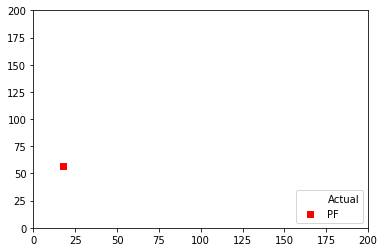

1529
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


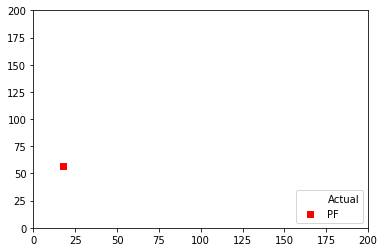

1530
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


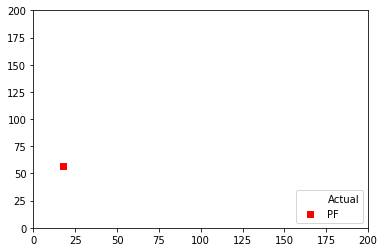

1531
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


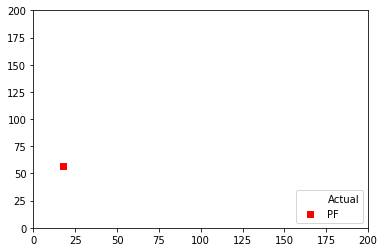

1532
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


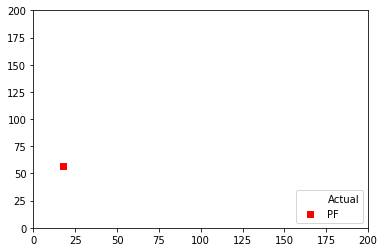

1533
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


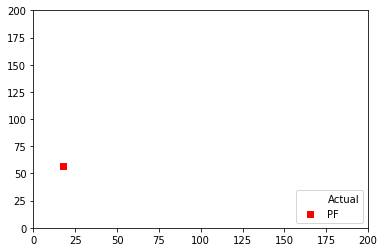

1534
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


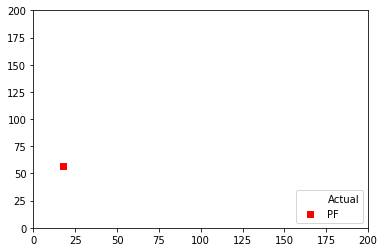

1535
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


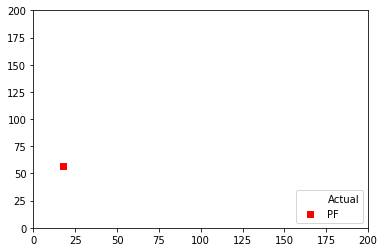

1536
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


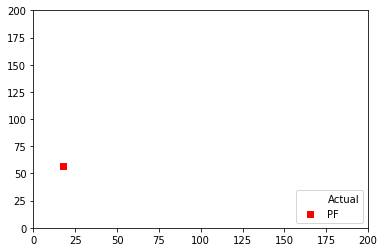

1537
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


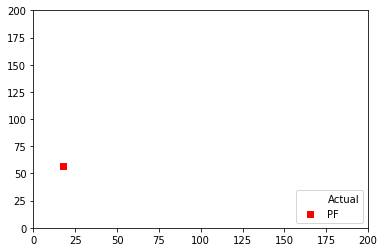

1538
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


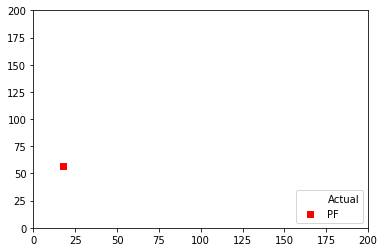

1539
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


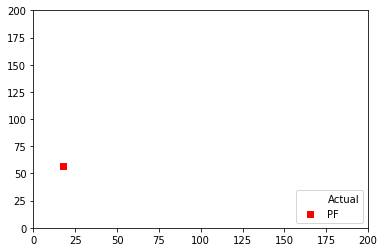

1540
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


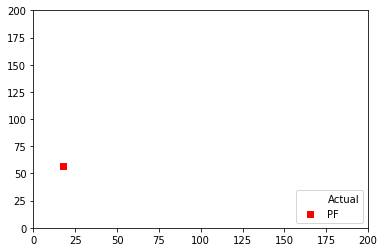

1541
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


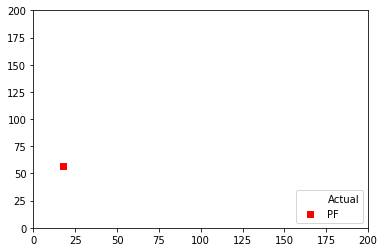

1542
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


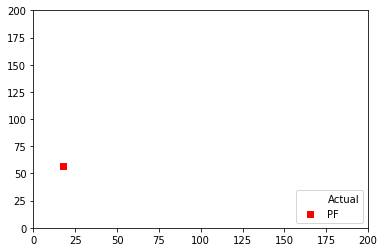

1543
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


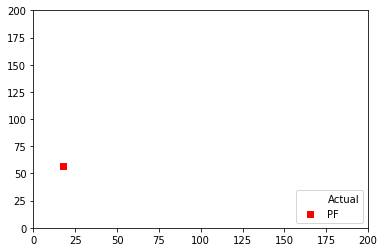

1544
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


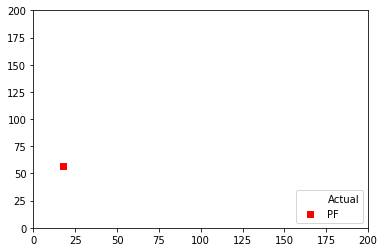

1545
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


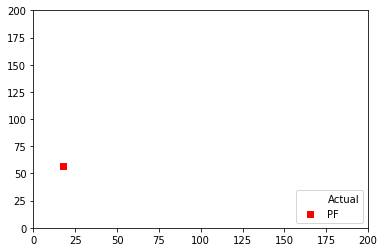

1546
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


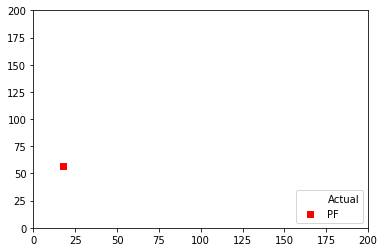

1547
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


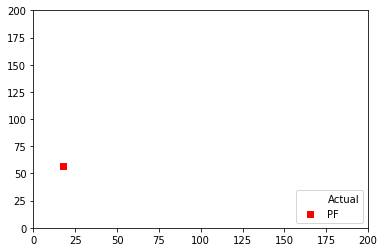

1548
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


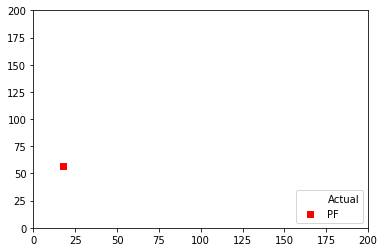

1549
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


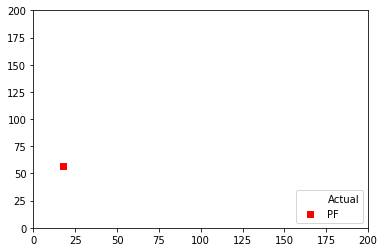

1550
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


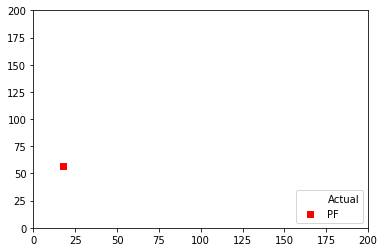

1551
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


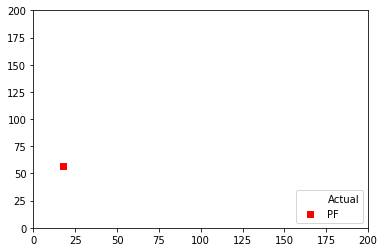

1552
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


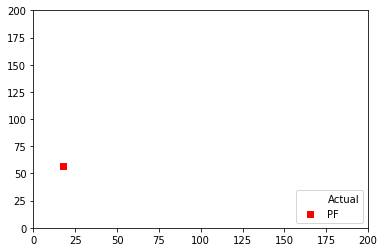

1553
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


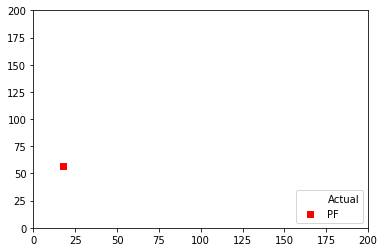

1554
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


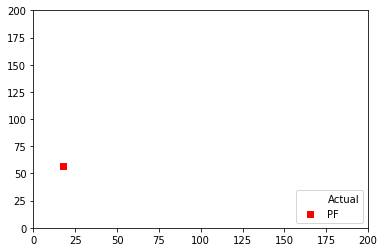

1555
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


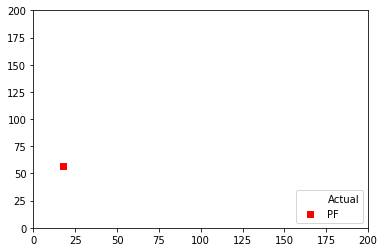

1556
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


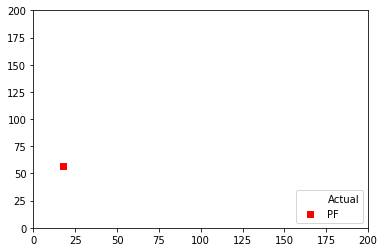

1557
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


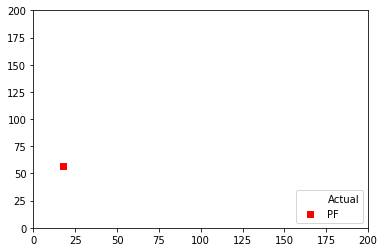

1558
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


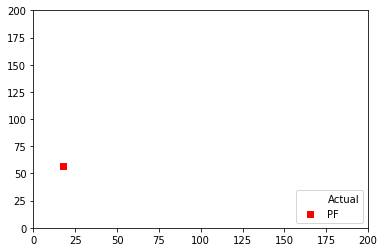

1559
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


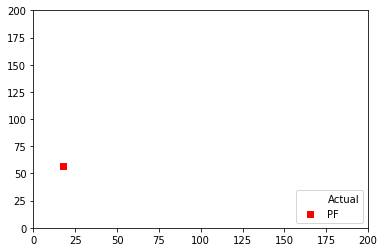

1560
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


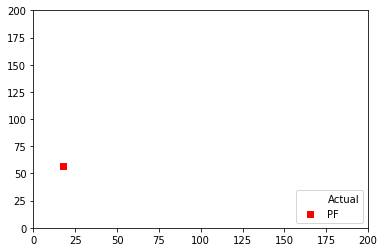

1561
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


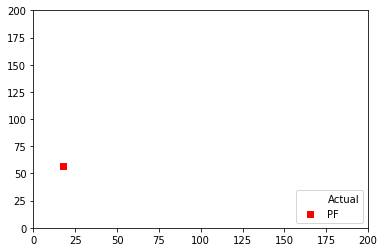

1562
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


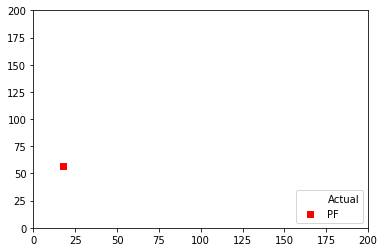

1563
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


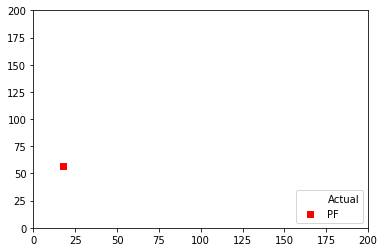

1564
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


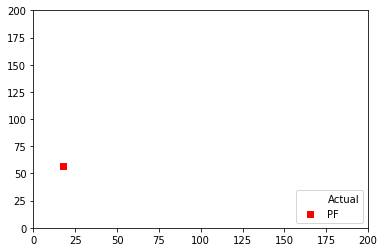

1565
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


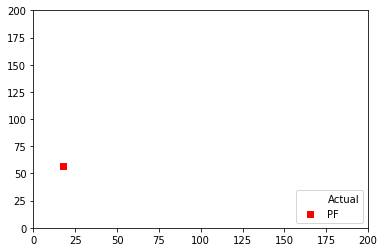

1566
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


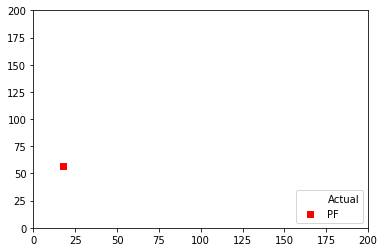

1567
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


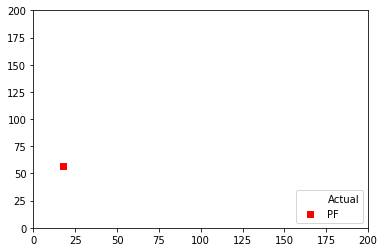

1568
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


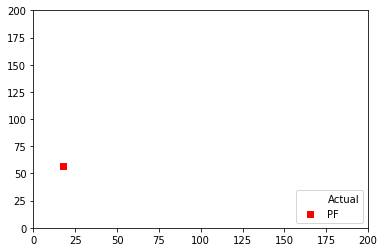

1569
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


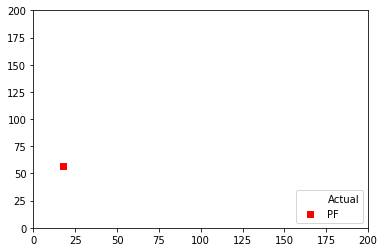

1570
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


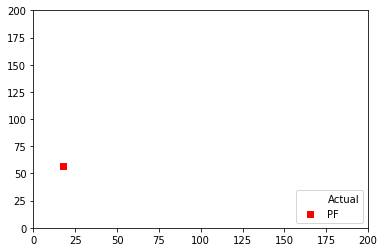

1571
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


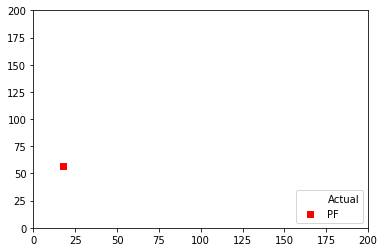

1572
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


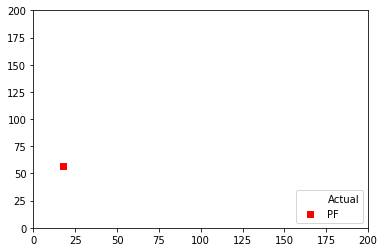

1573
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


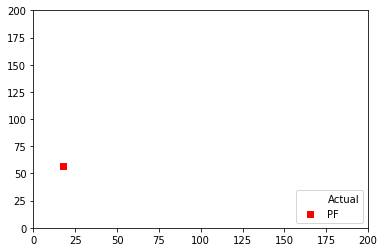

1574
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


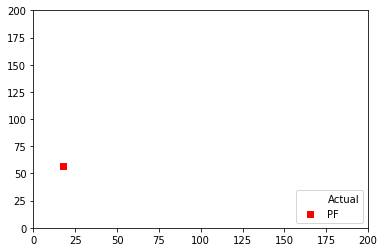

1575
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


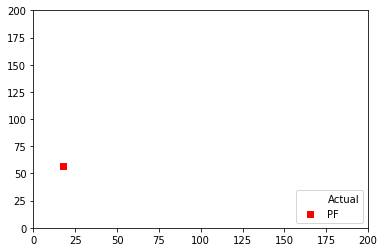

1576
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


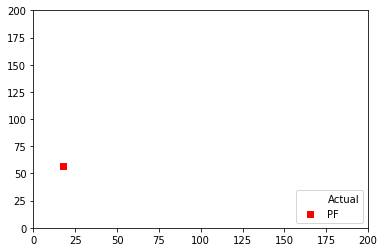

1577
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


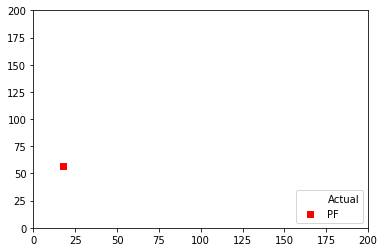

1578
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


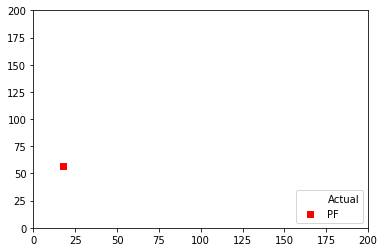

1579
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


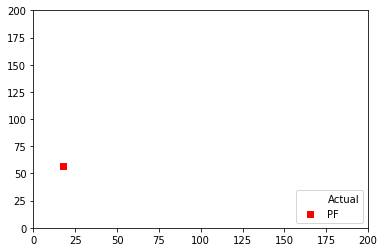

1580
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


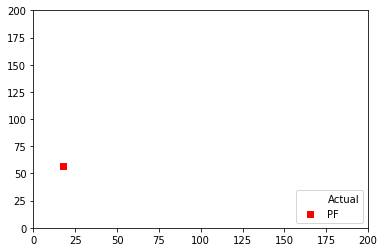

1581
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


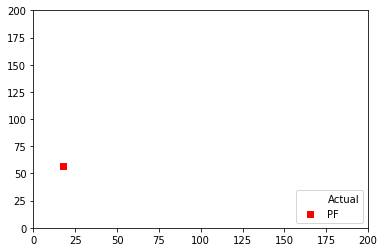

1582
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


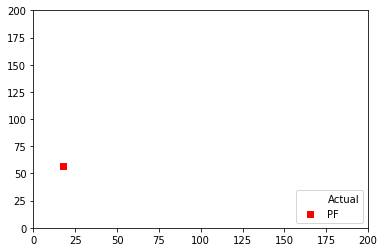

1583
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


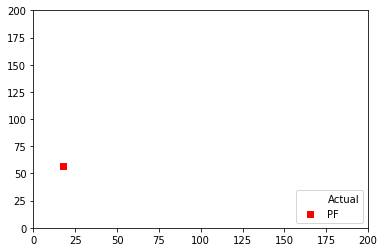

1584
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


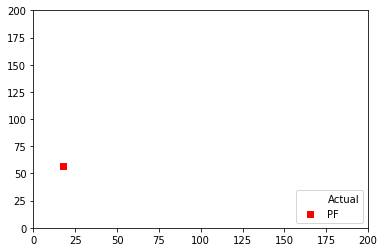

1585
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


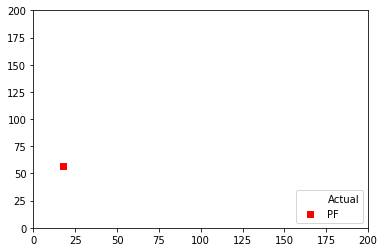

1586
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


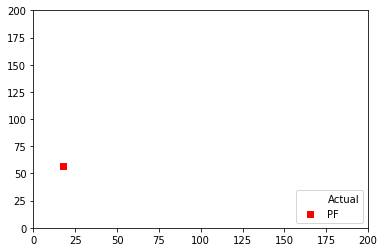

1587
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


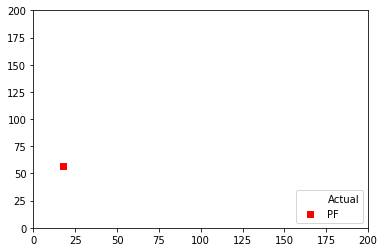

1588
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


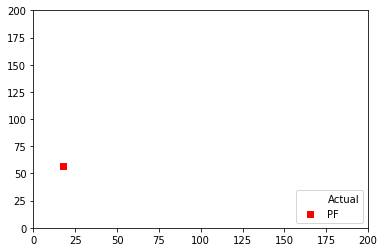

1589
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


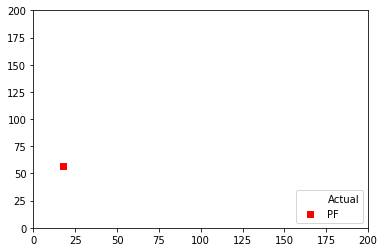

1590
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


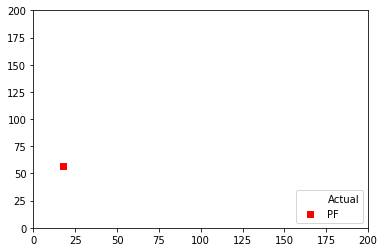

1591
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


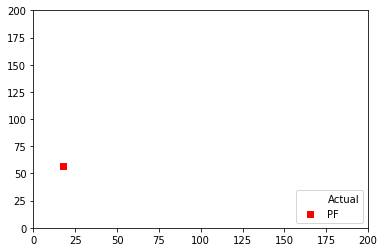

1592
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


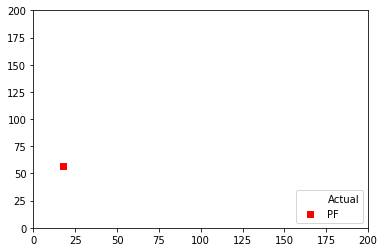

1593
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


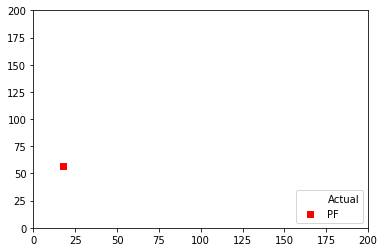

1594
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


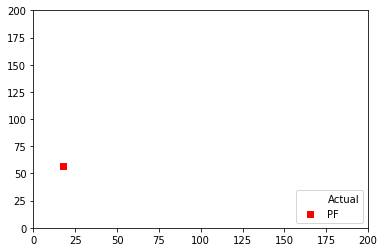

1595
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


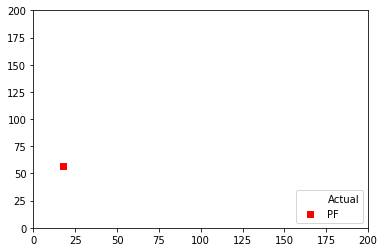

1596
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


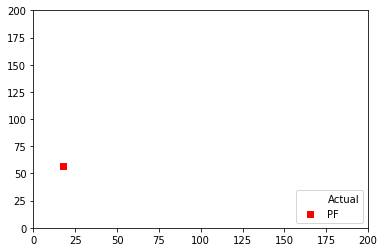

1597
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


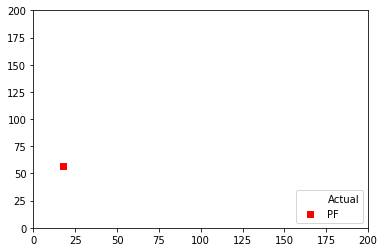

1598
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


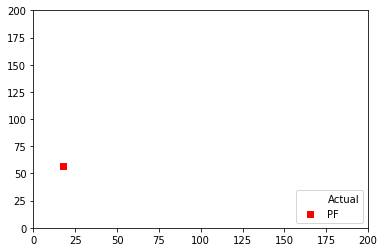

1599
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


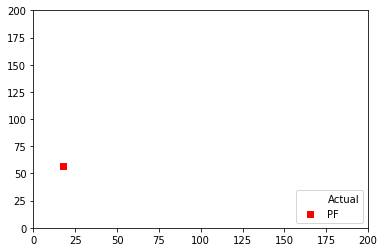

1600
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


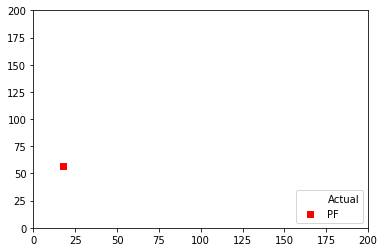

1601
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


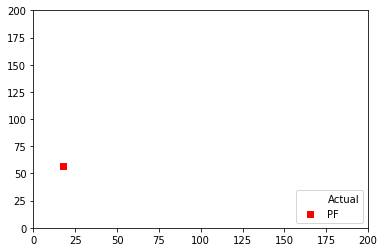

1602
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


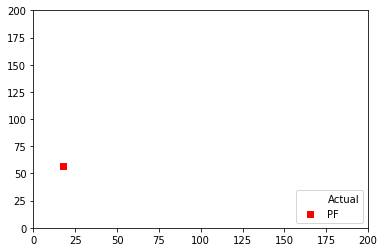

1603
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


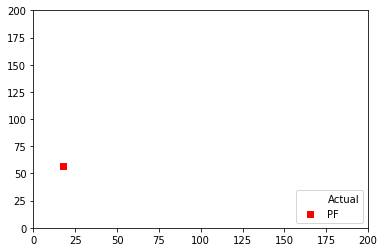

1604
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


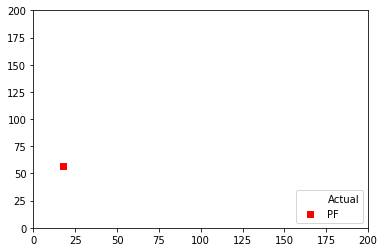

1605
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


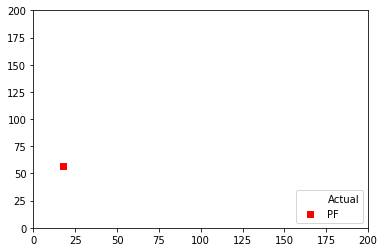

1606
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


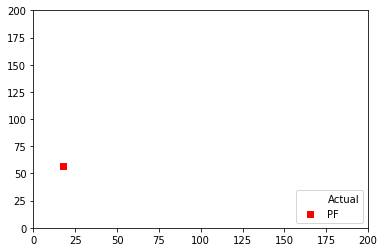

1607
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


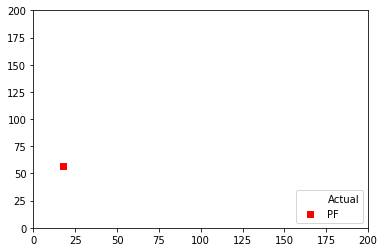

1608
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


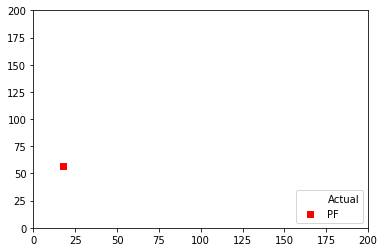

1609
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


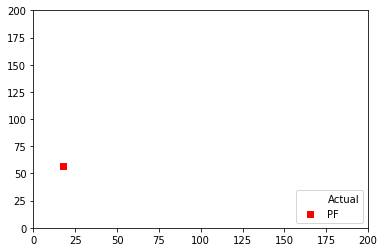

1610
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


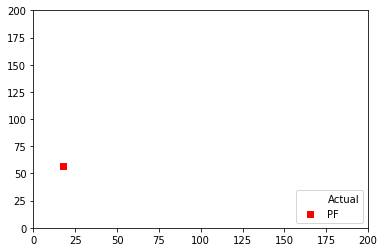

1611
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


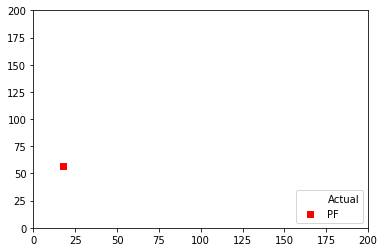

1612
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


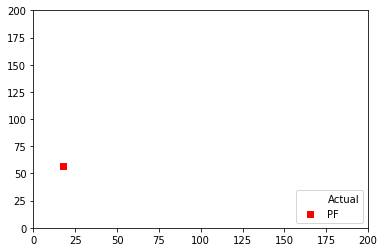

1613
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


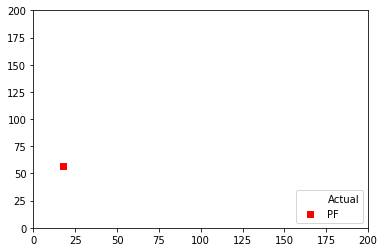

1614
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


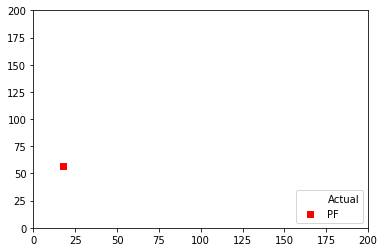

1615
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


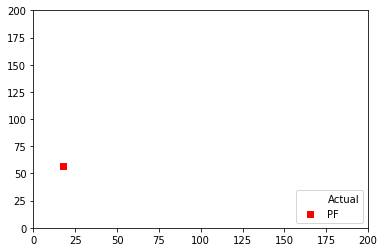

1616
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


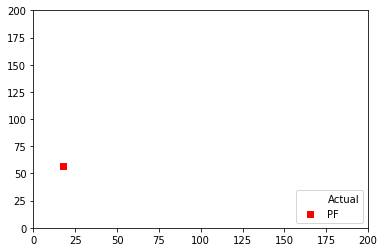

1617
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


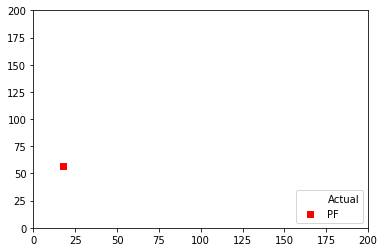

1618
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


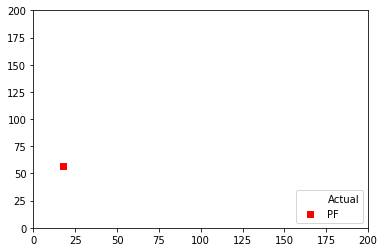

1619
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


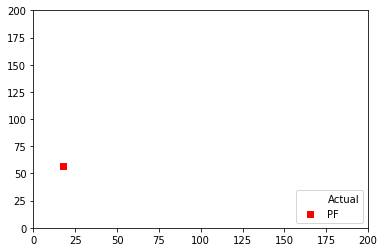

1620
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


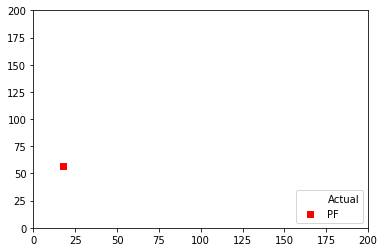

1621
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


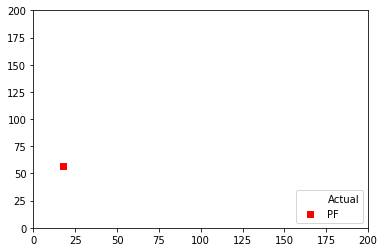

1622
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


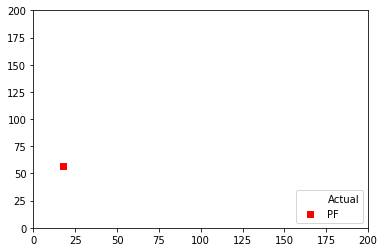

1623
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


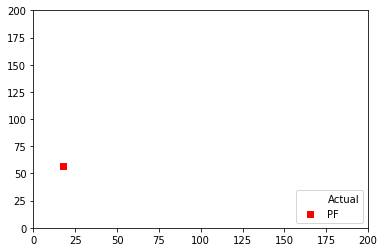

1624
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


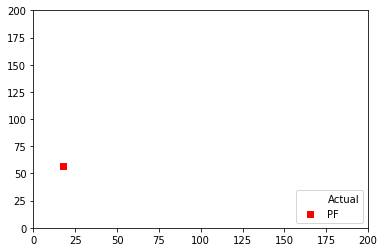

1625
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


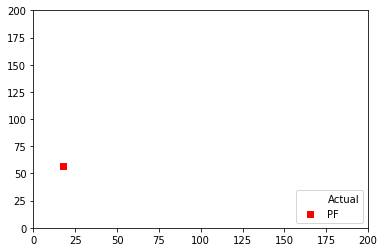

1626
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


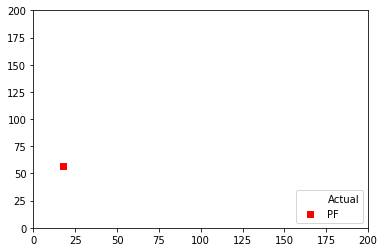

1627
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


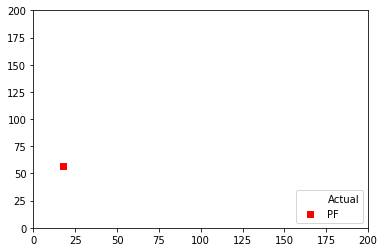

1628
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


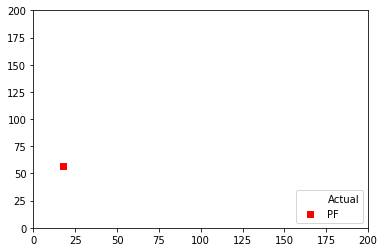

1629
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


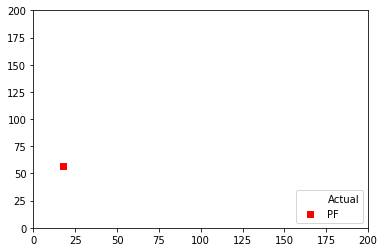

1630
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


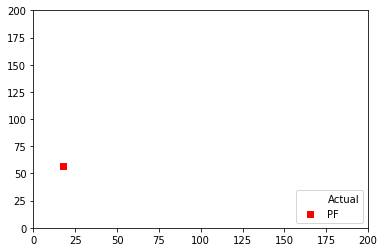

1631
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


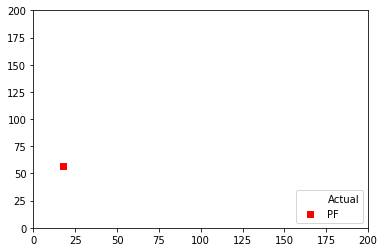

1632
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


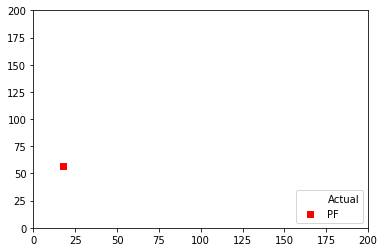

1633
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


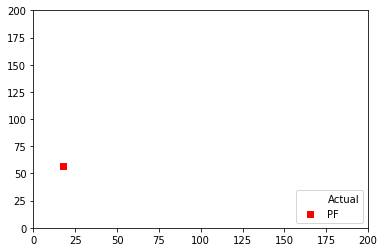

1634
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


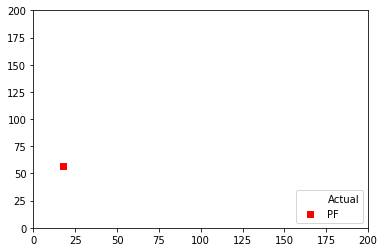

1635
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


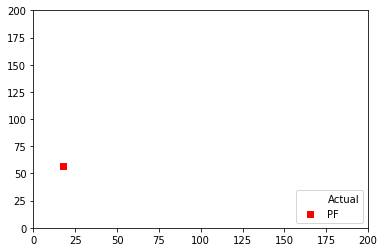

1636
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


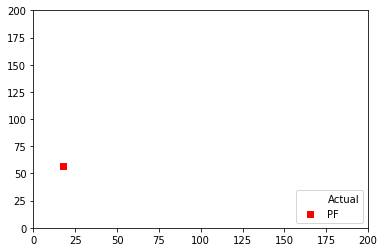

1637
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


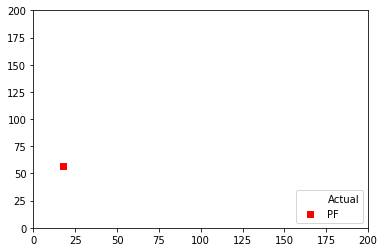

1638
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


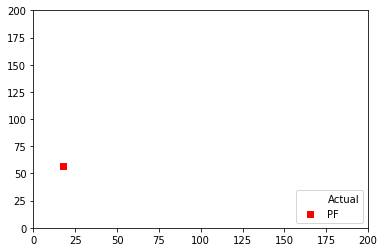

1639
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


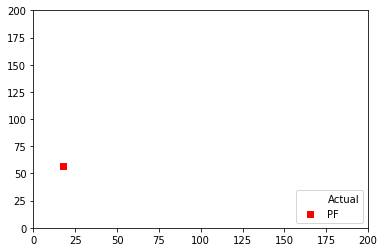

1640
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


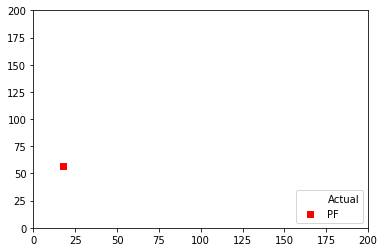

1641
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


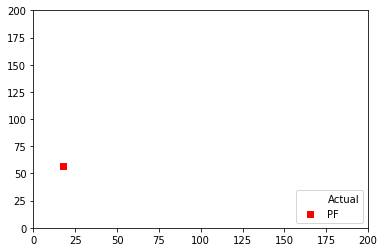

1642
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


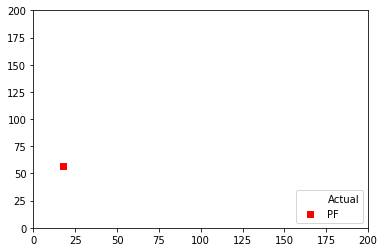

1643
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


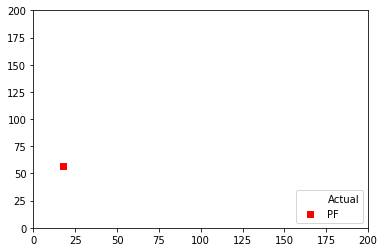

1644
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


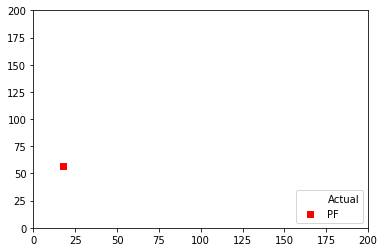

1645
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


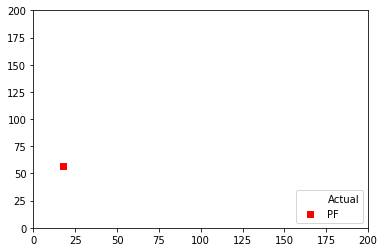

1646
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


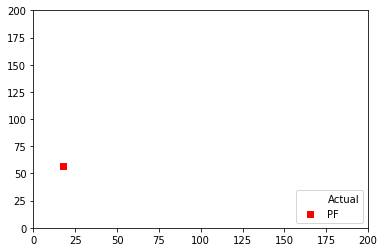

1647
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


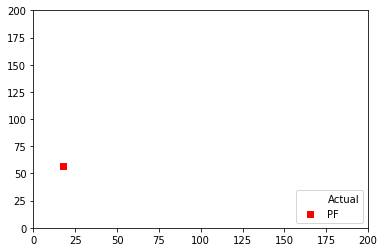

1648
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


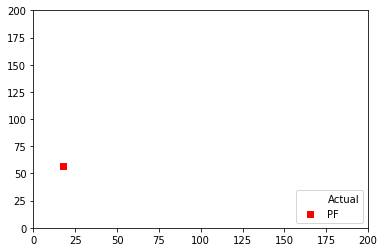

1649
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


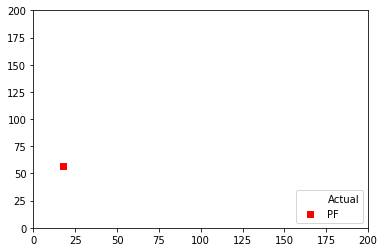

1650
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


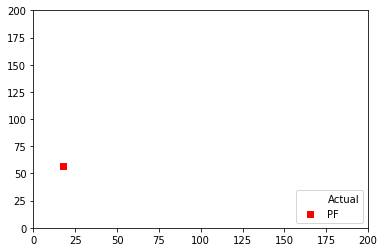

1651
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


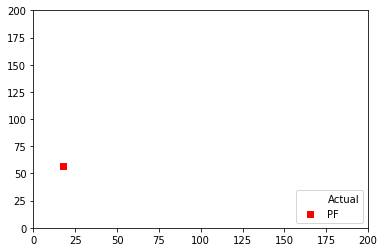

1652
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


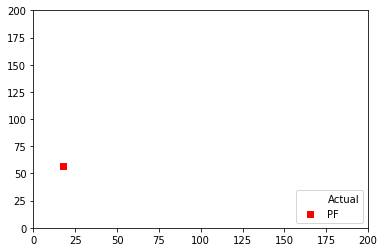

1653
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


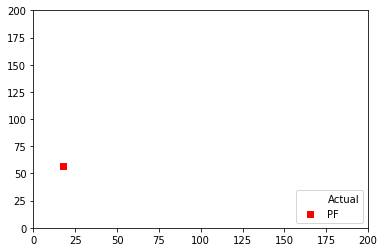

1654
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


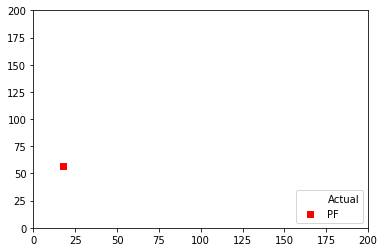

1655
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


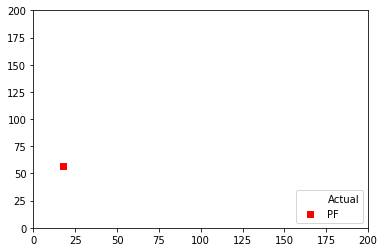

1656
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


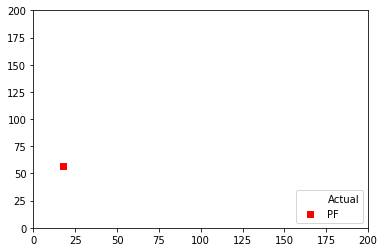

1657
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


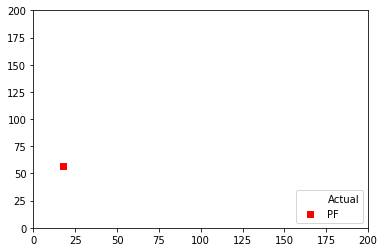

1658
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


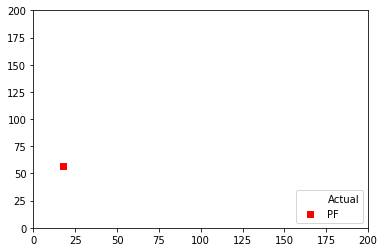

1659
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


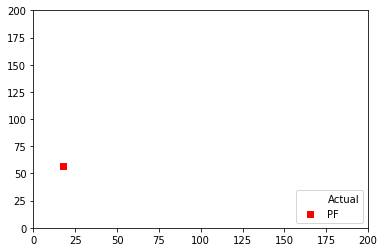

1660
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


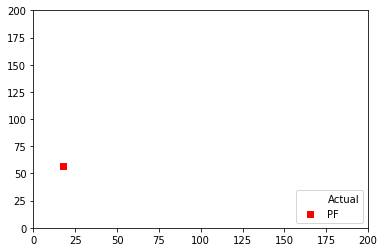

1661
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


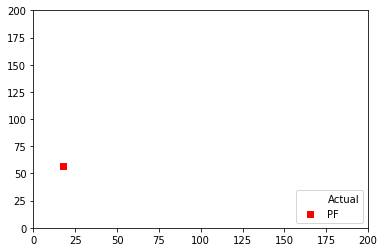

1662
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


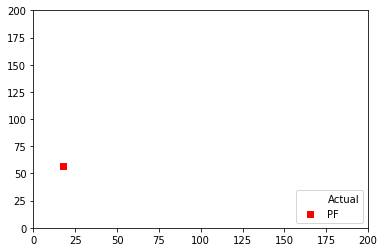

1663
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


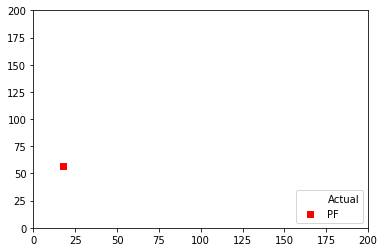

1664
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


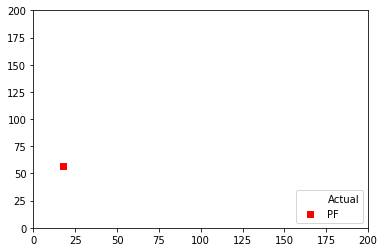

1665
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


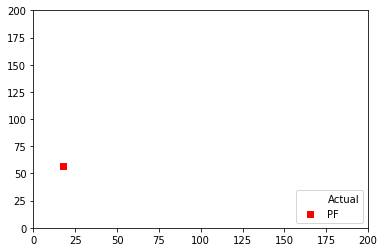

1666
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


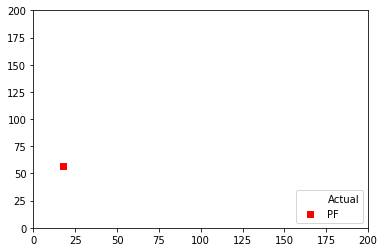

1667
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


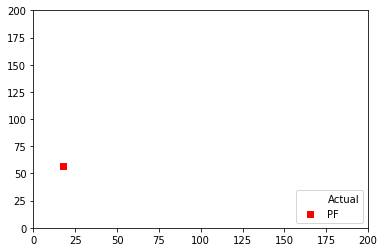

1668
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


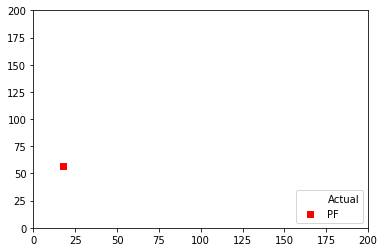

1669
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


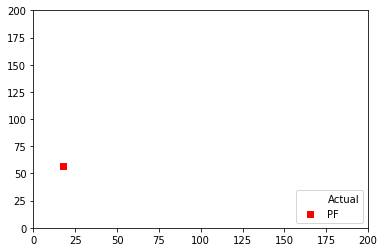

1670
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


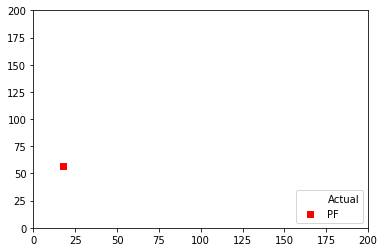

1671
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


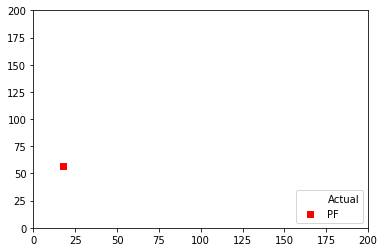

1672
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


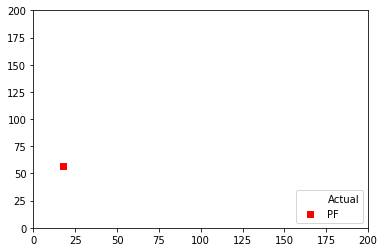

1673
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


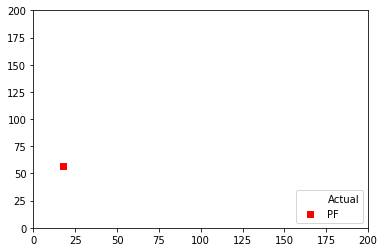

1674
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


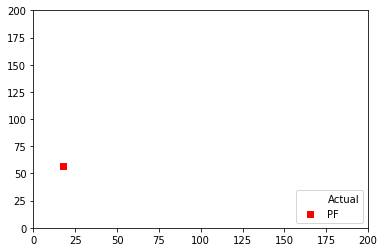

1675
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


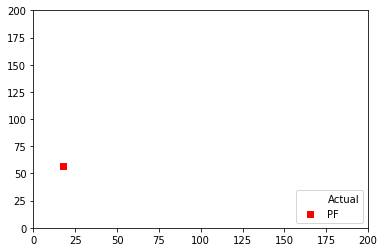

1676
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


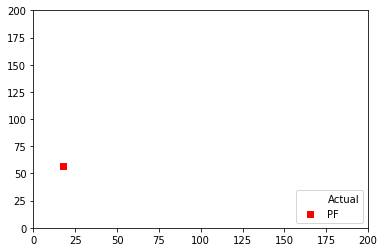

1677
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


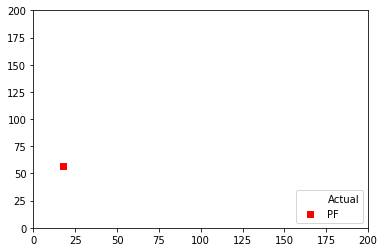

1678
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


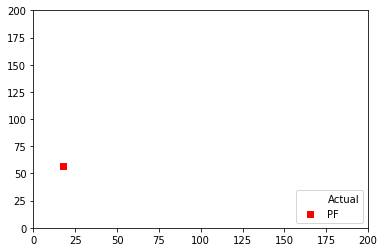

1679
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


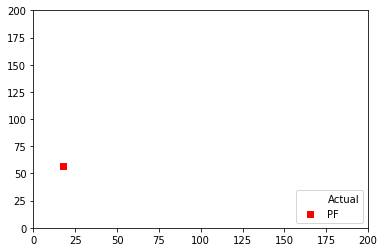

1680
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


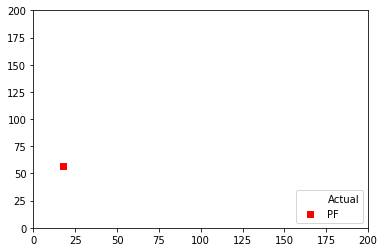

1681
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


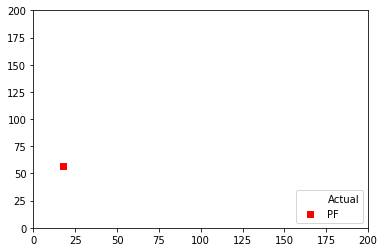

1682
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


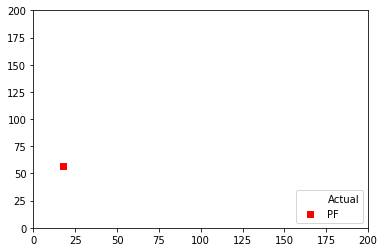

1683
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


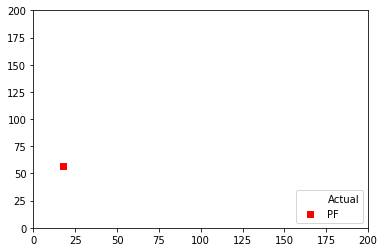

1684
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


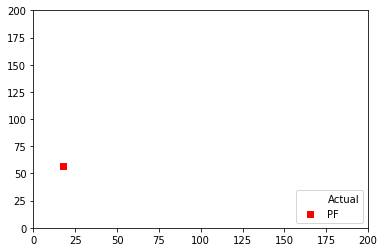

1685
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


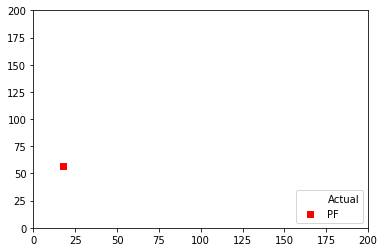

1686
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


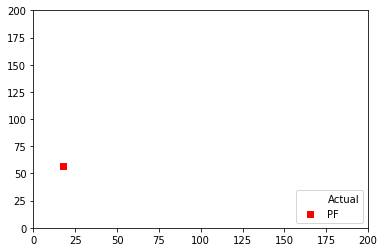

1687
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


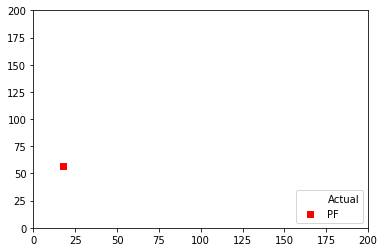

1688
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


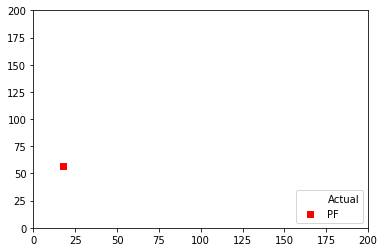

1689
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


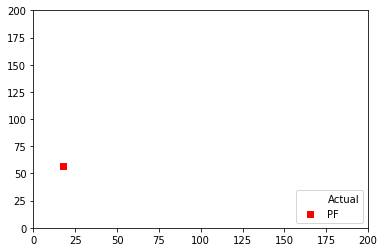

1690
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


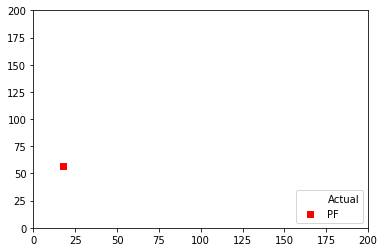

1691
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


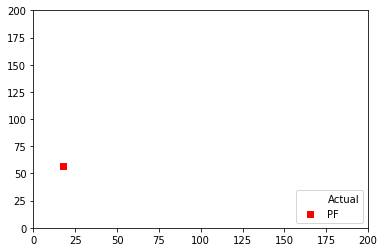

1692
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


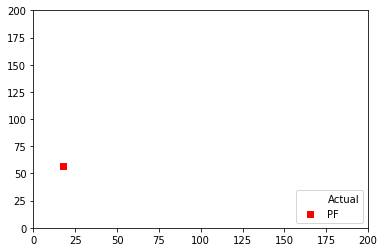

1693
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


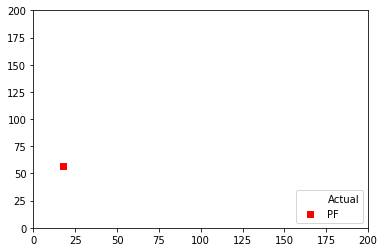

1694
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


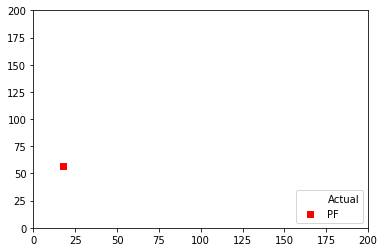

1695
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


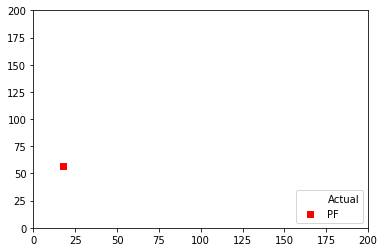

1696
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


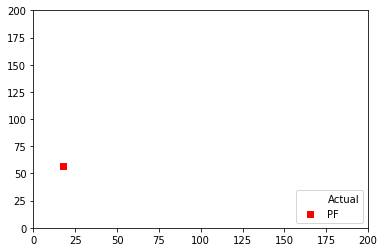

1697
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


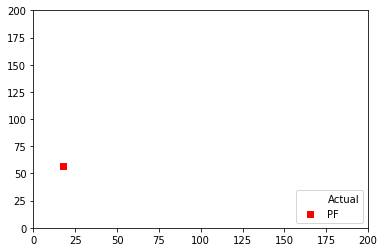

1698
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


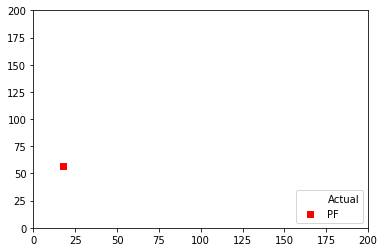

1699
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


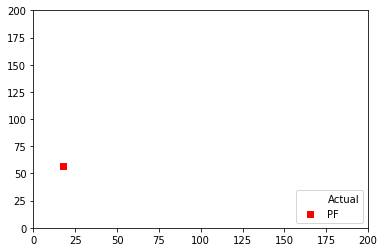

1700
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


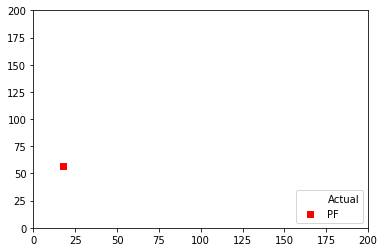

1701
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


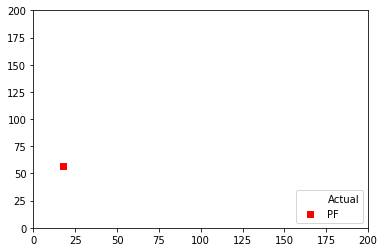

1702
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


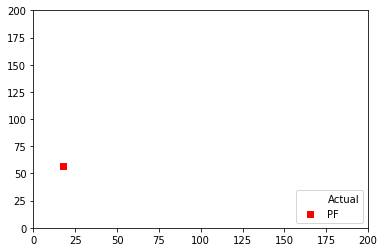

1703
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


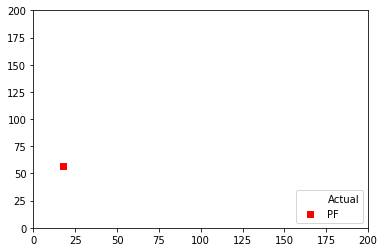

1704
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


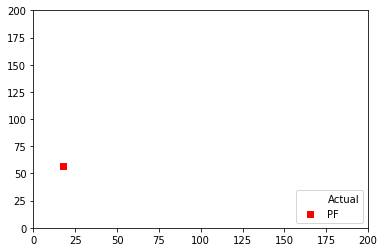

1705
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


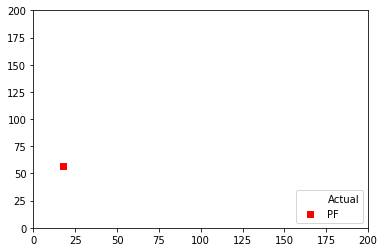

1706
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


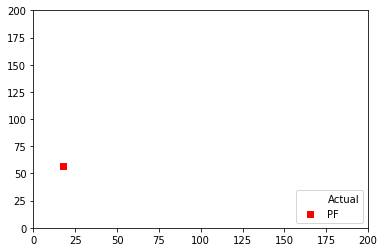

1707
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


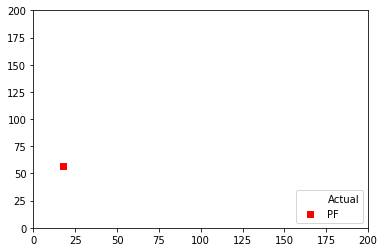

1708
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


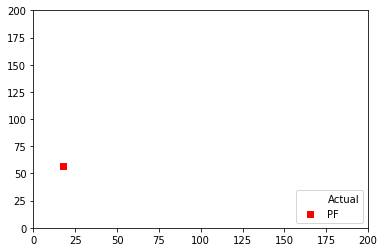

1709
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


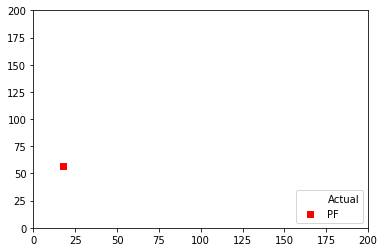

1710
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


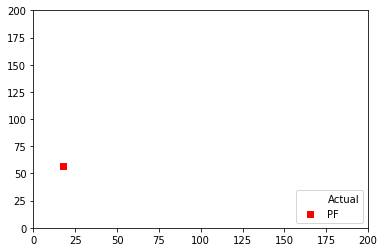

1711
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


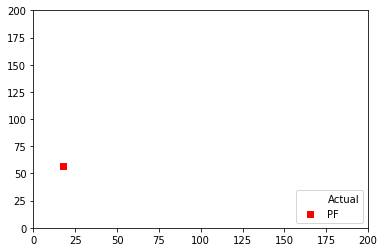

1712
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


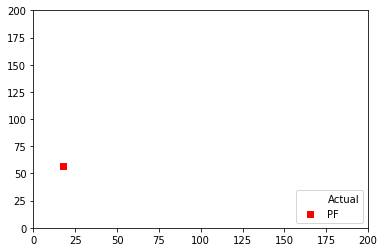

1713
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


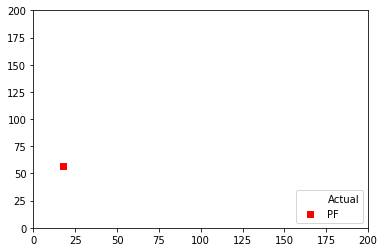

1714
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


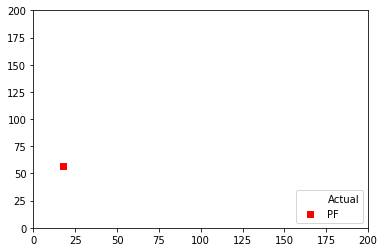

1715
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


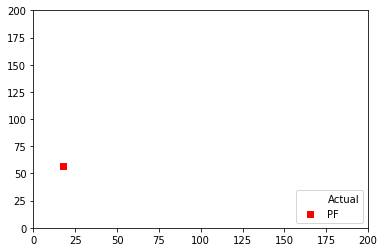

1716
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


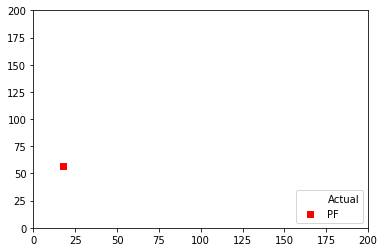

1717
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


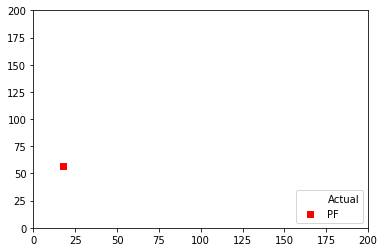

1718
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


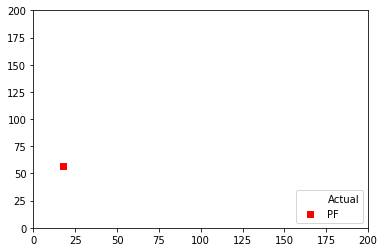

1719
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


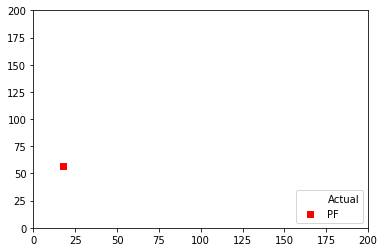

1720
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


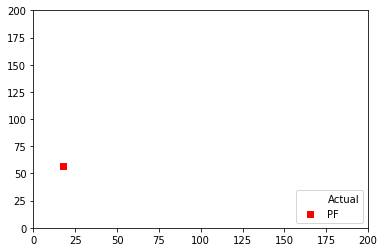

1721
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


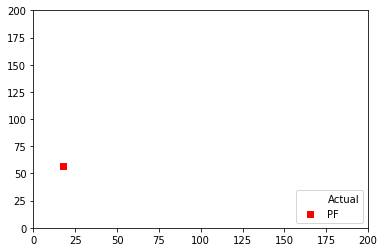

1722
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


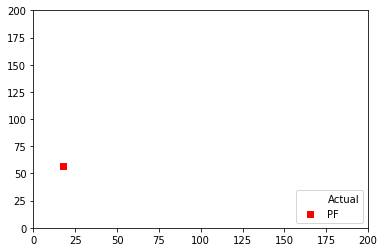

1723
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


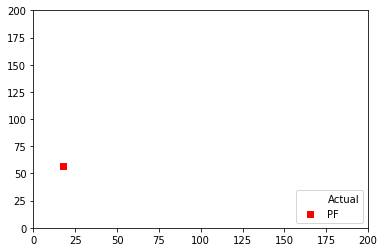

1724
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


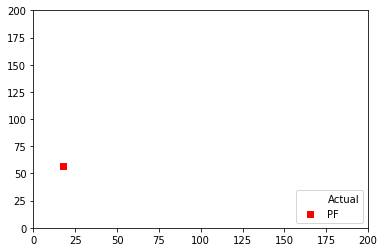

1725
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


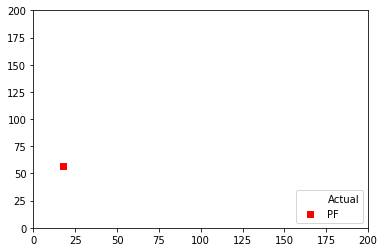

1726
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


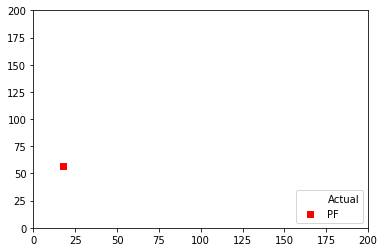

1727
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


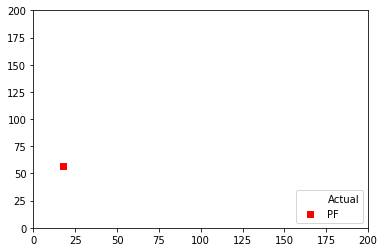

1728
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


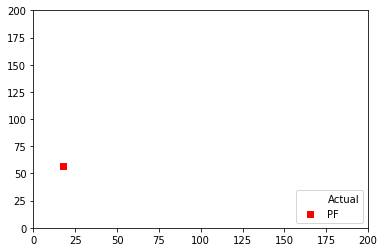

1729
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


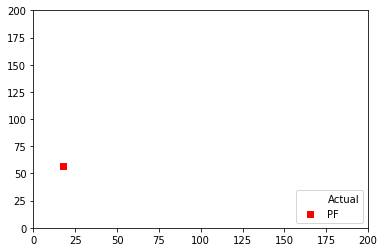

1730
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


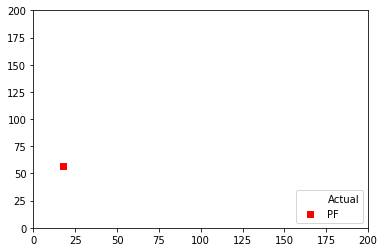

1731
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


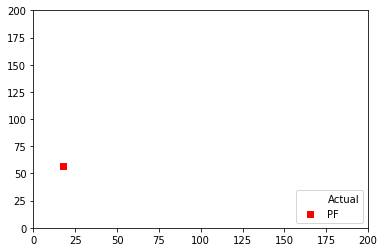

1732
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


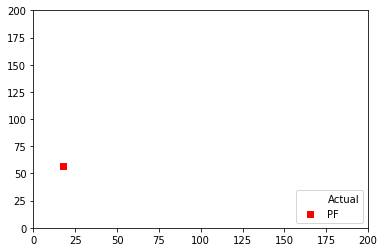

1733
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


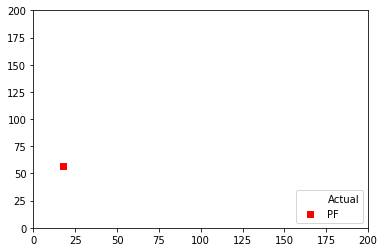

1734
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


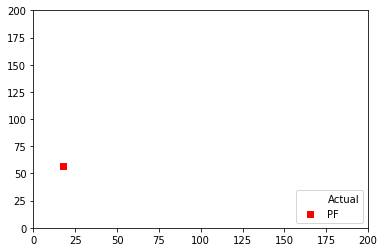

1735
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


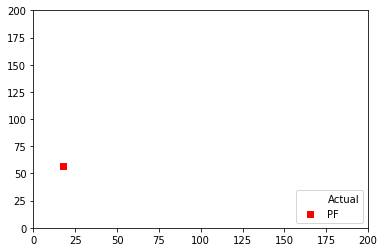

1736
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


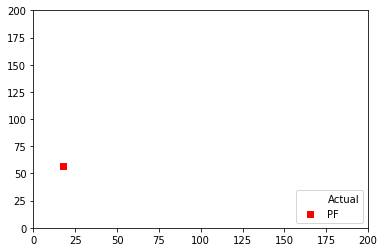

1737
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


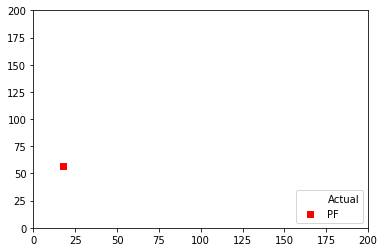

1738
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


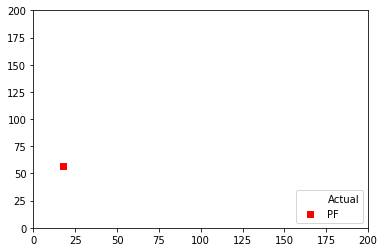

1739
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


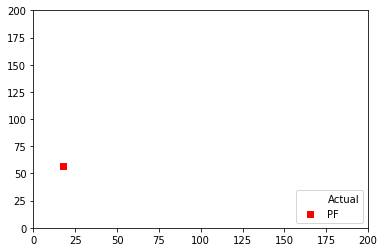

1740
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


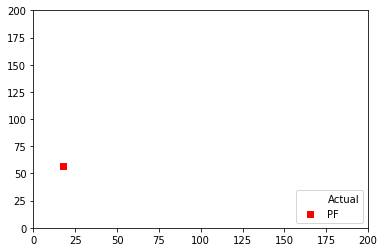

1741
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


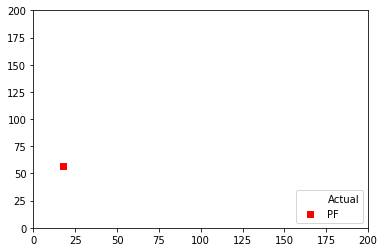

1742
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


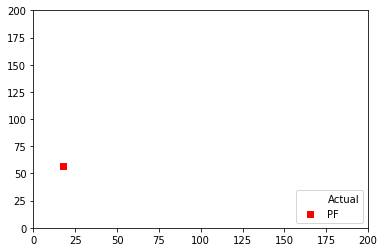

1743
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


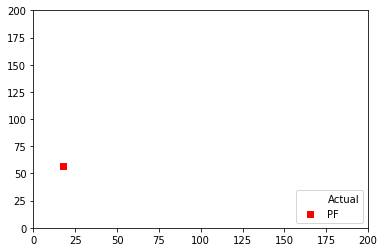

1744
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


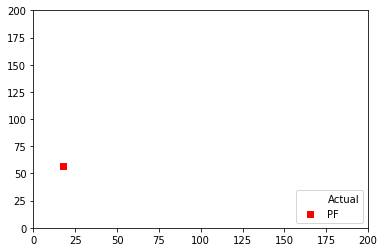

1745
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


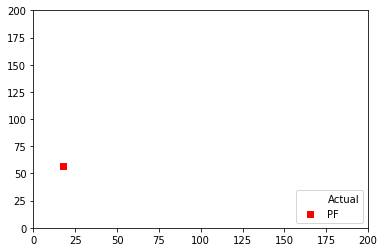

1746
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


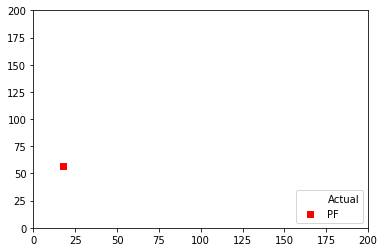

1747
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


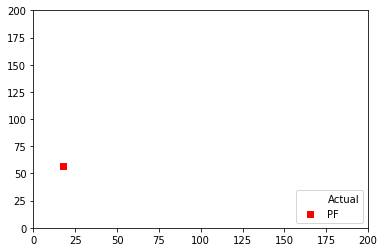

1748
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


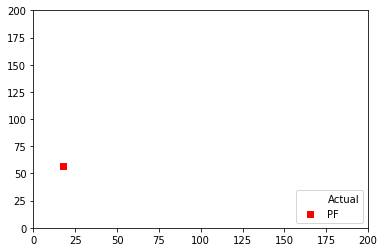

1749
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


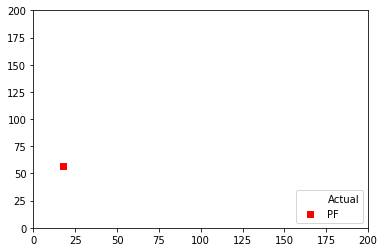

1750
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


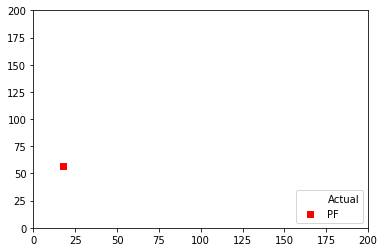

1751
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


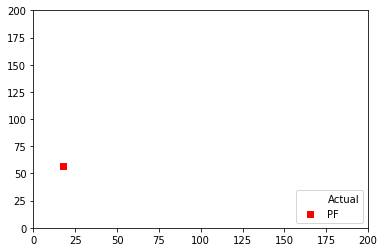

1752
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


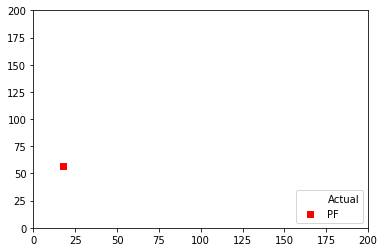

1753
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


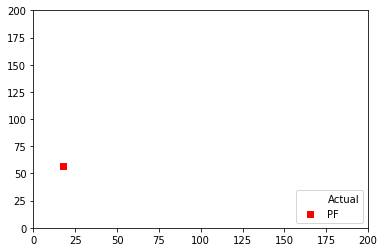

1754
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


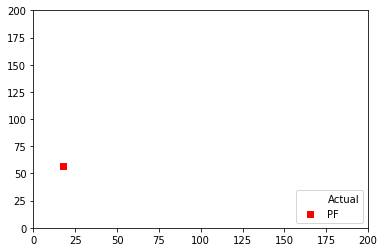

1755
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


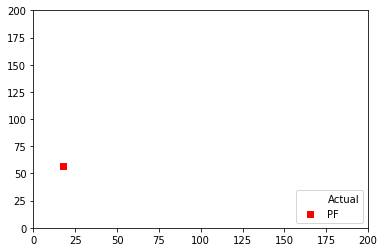

1756
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


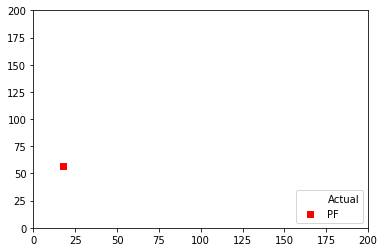

1757
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


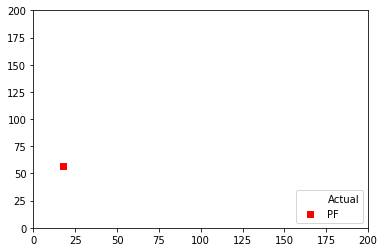

1758
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


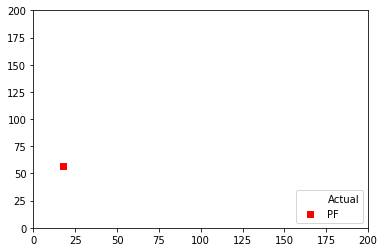

1759
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


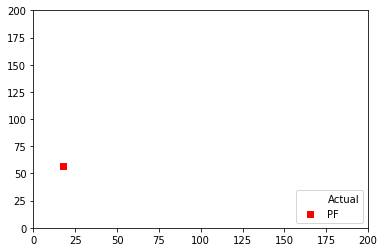

1760
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


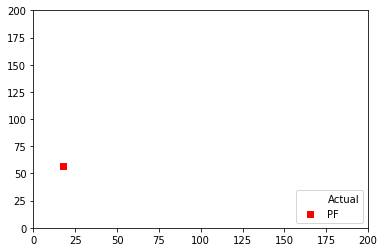

1761
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


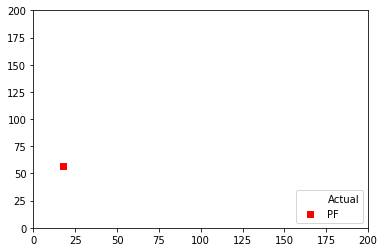

1762
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


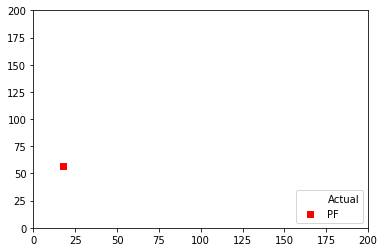

1763
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


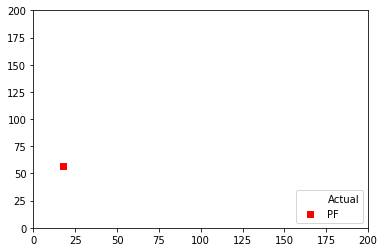

1764
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


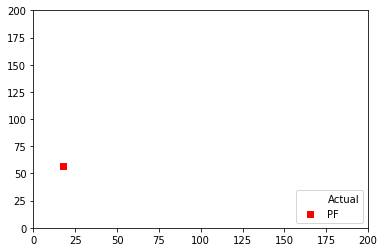

1765
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


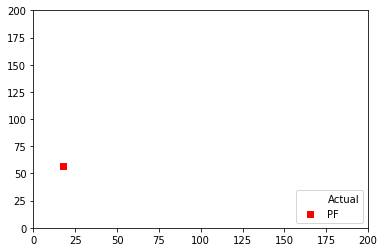

1766
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


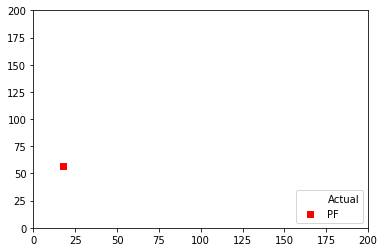

1767
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


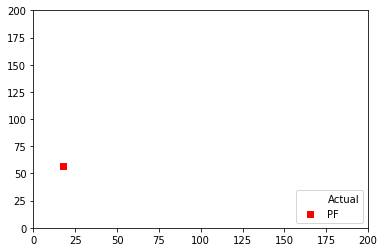

1768
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


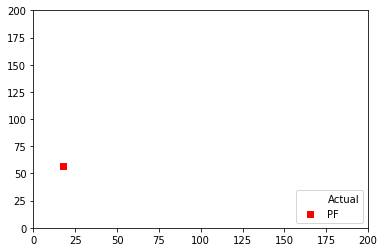

1769
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


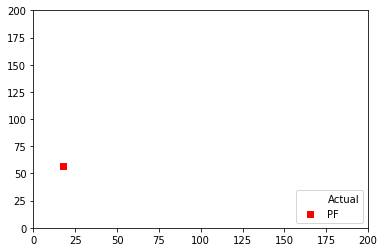

1770
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


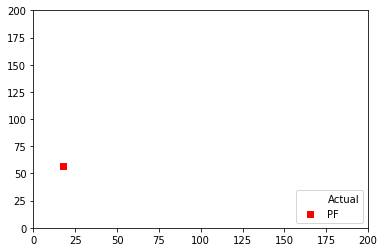

1771
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


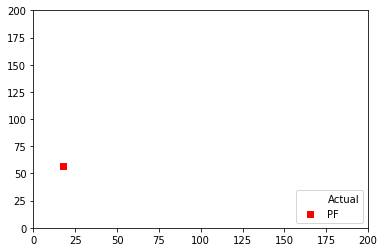

1772
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


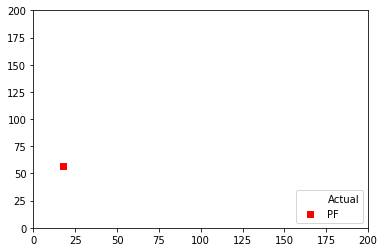

1773
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


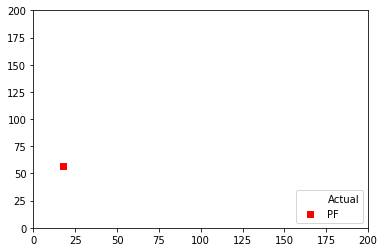

1774
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


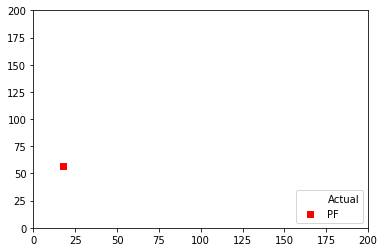

1775
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


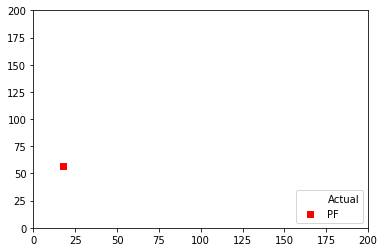

1776
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


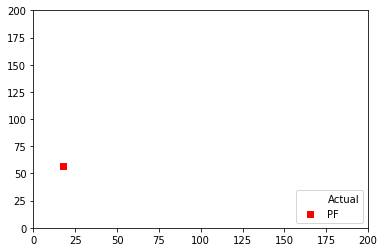

1777
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


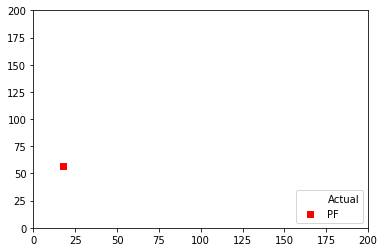

1778
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


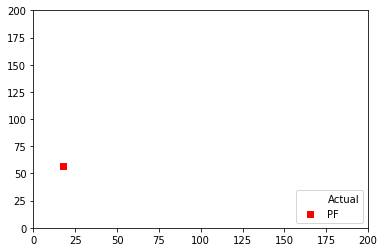

1779
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


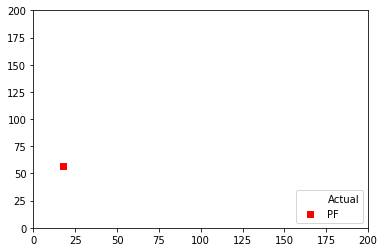

1780
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


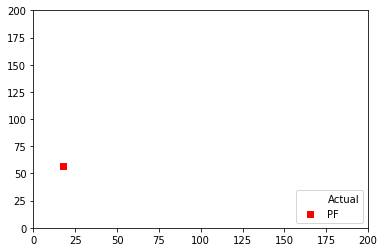

1781
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


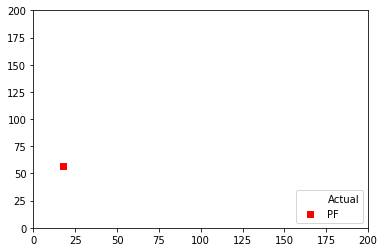

1782
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


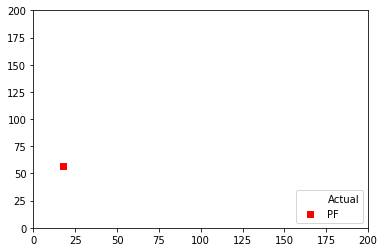

1783
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


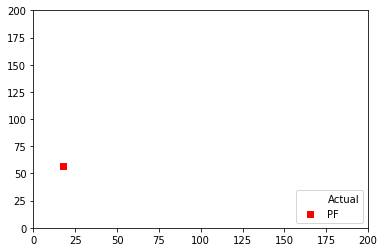

1784
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


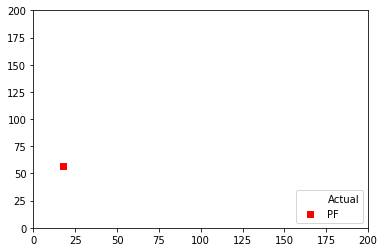

1785
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


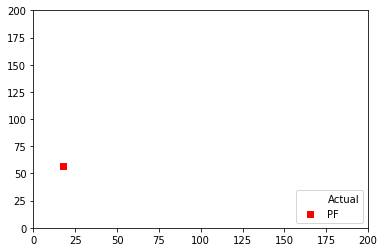

1786
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


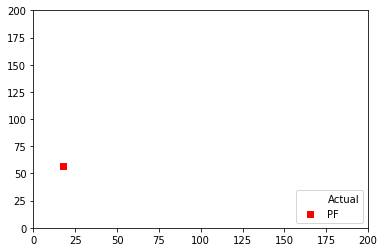

1787
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


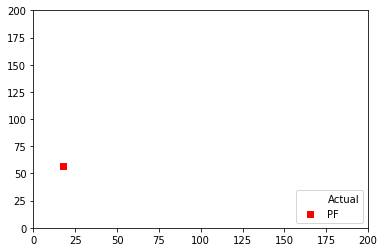

1788
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


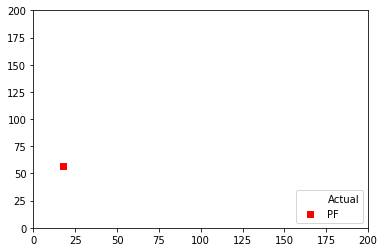

1789
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


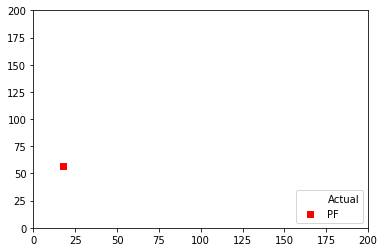

1790
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


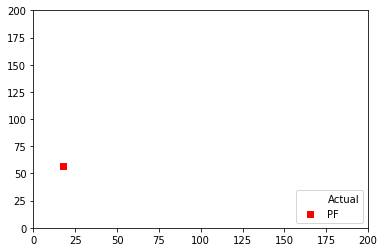

1791
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


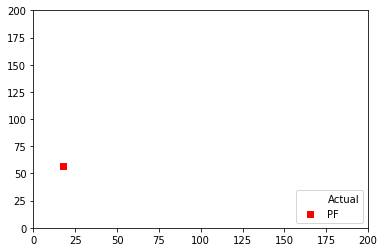

1792
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


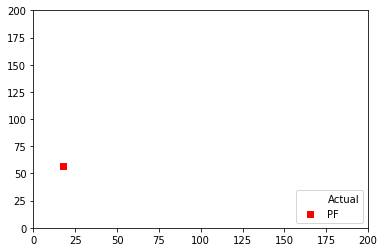

1793
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


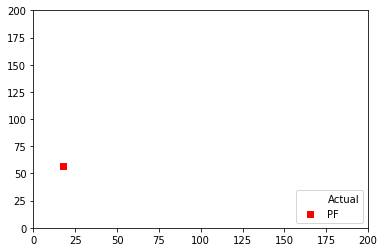

1794
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


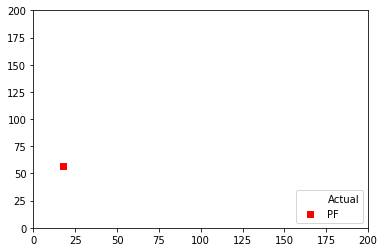

1795
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


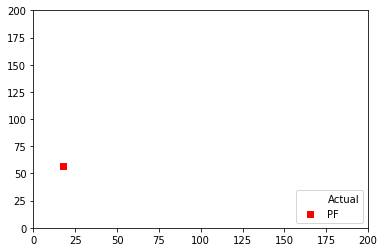

1796
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


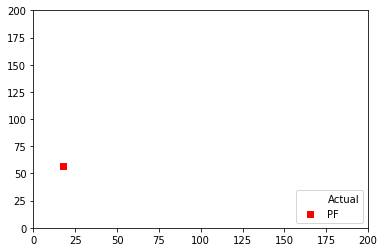

1797
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


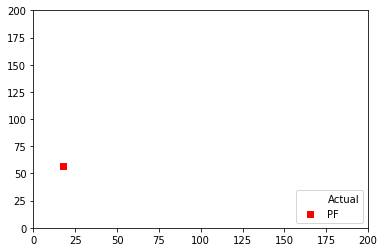

1798
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


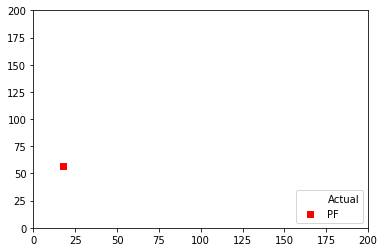

1799
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


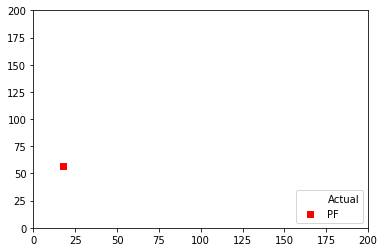

1800
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


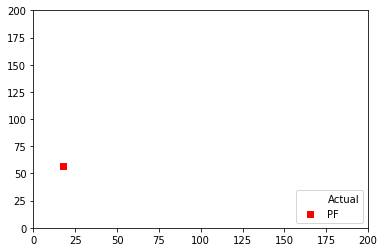

1801
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


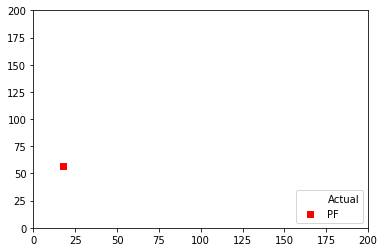

1802
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


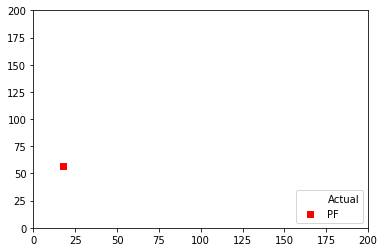

1803
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


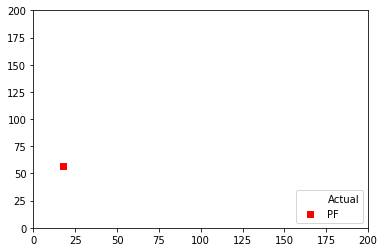

1804
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


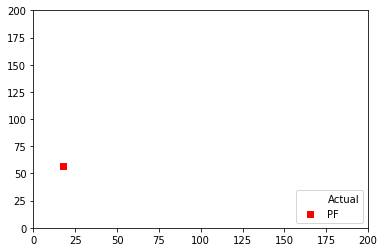

1805
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


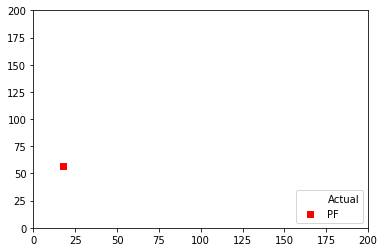

1806
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


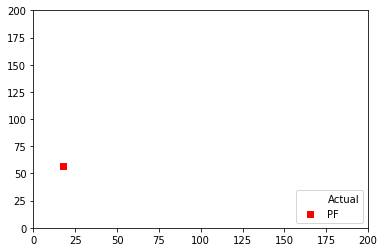

1807
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


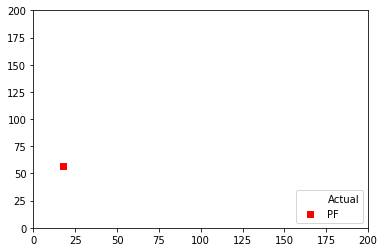

1808
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


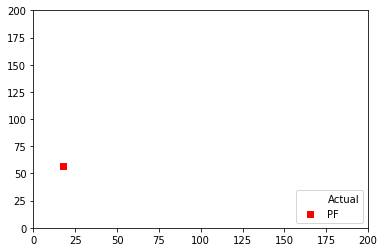

1809
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


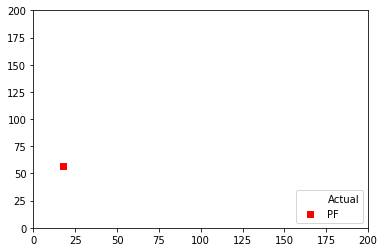

1810
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


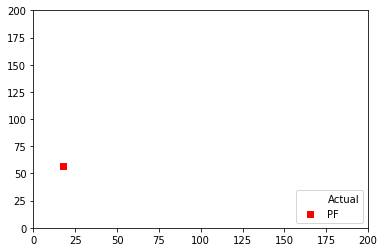

1811
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


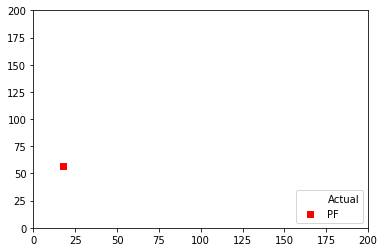

1812
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


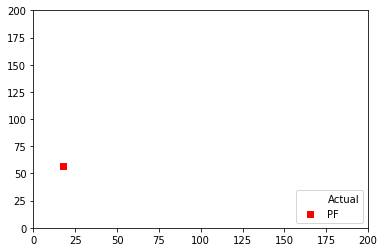

1813
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


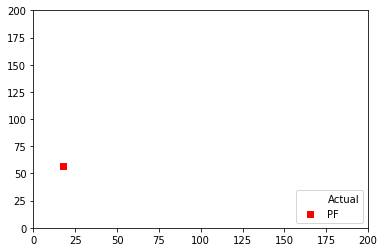

1814
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


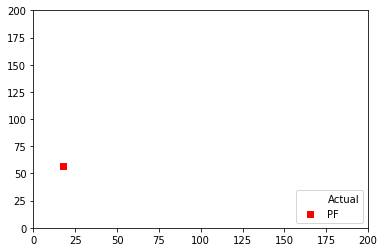

1815
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


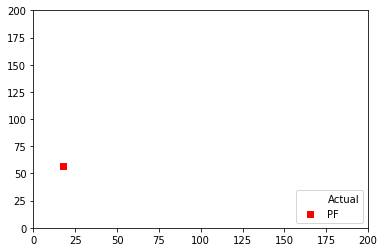

1816
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


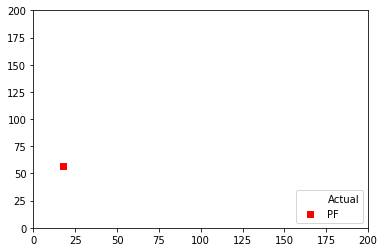

1817
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


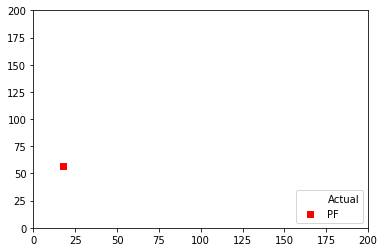

1818
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


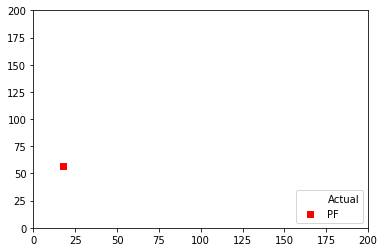

1819
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


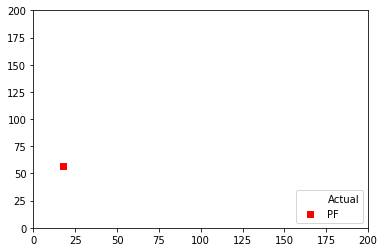

1820
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


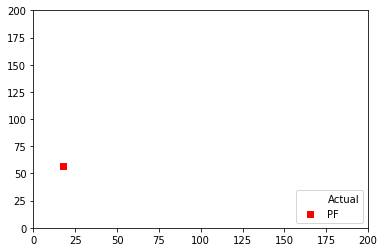

1821
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


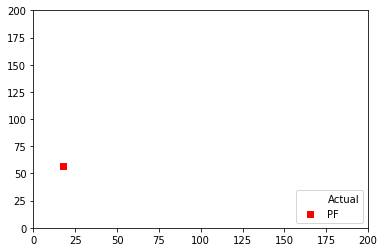

1822
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


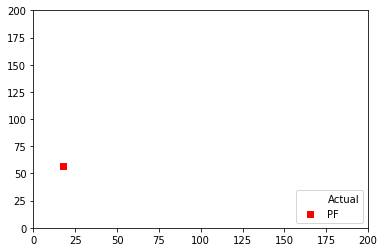

1823
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


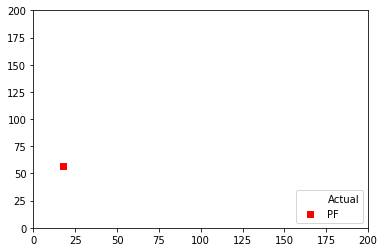

1824
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


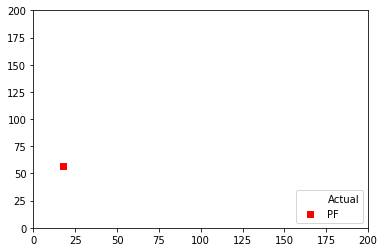

1825
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


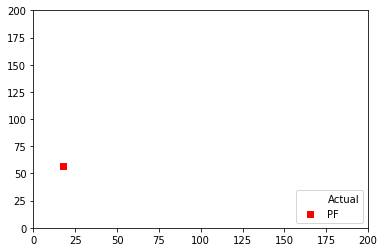

1826
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


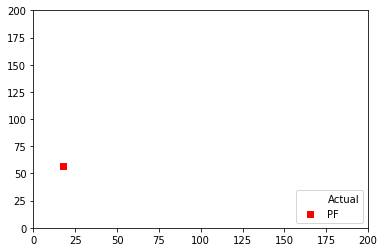

1827
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


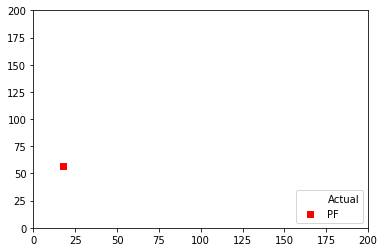

1828
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


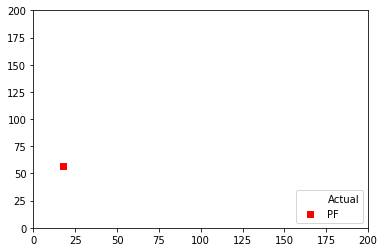

1829
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


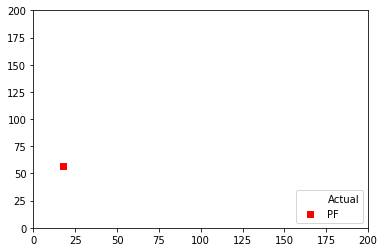

1830
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


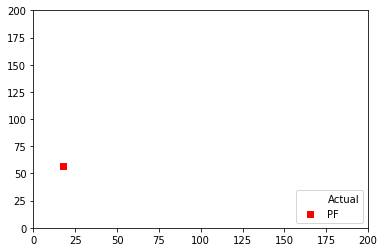

1831
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


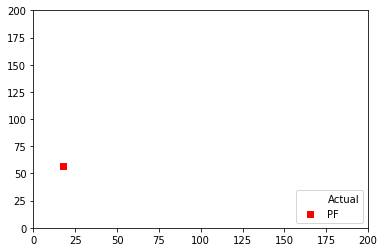

1832
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


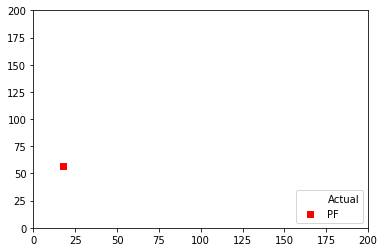

1833
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


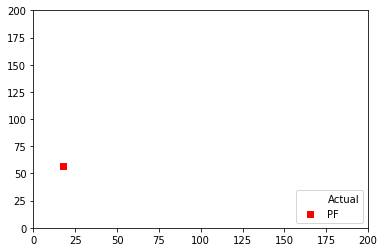

1834
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


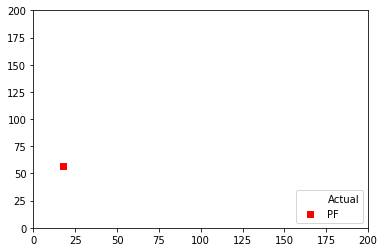

1835
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


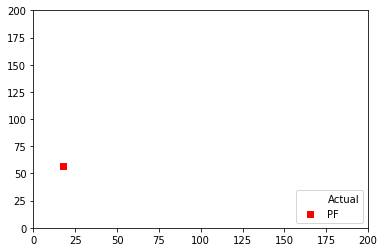

1836
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


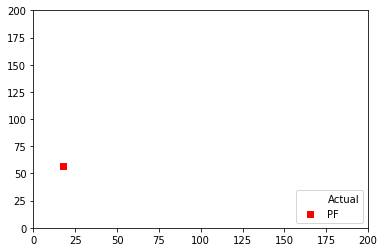

1837
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


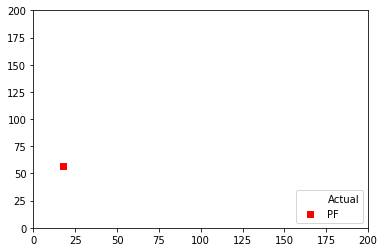

1838
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


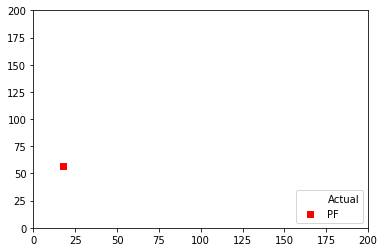

1839
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


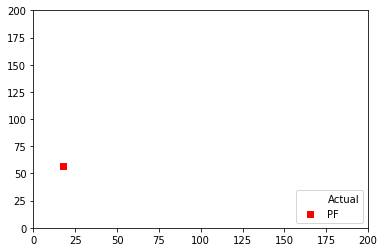

1840
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


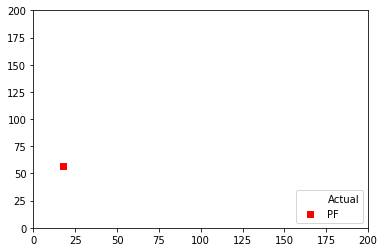

1841
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


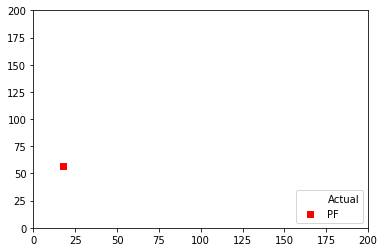

1842
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


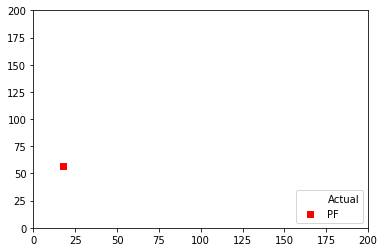

1843
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


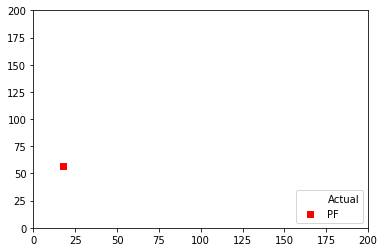

1844
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


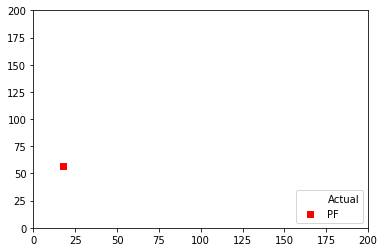

1845
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


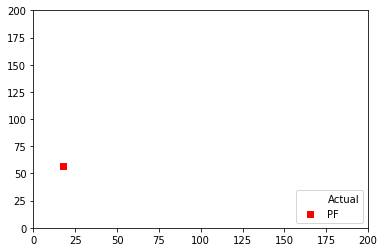

1846
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


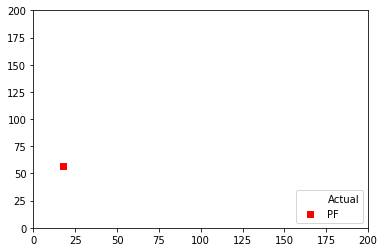

1847
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


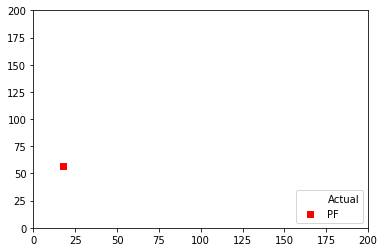

1848
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


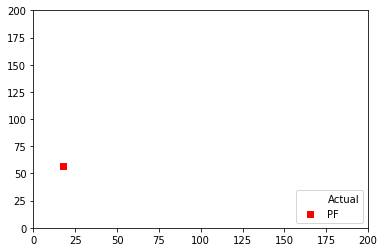

1849
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


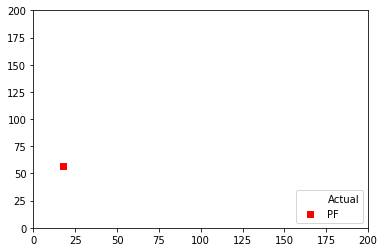

1850
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


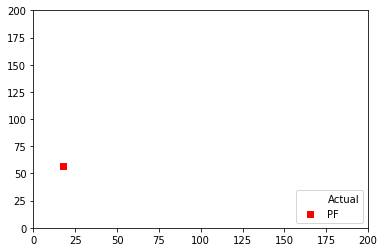

1851
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


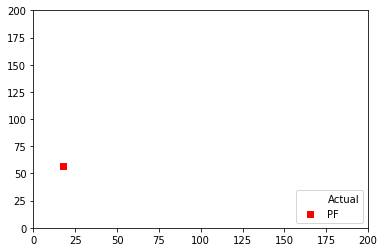

1852
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


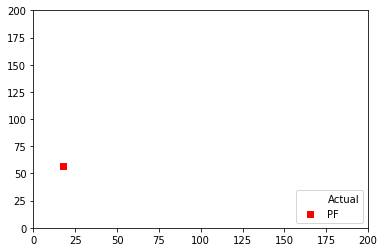

1853
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


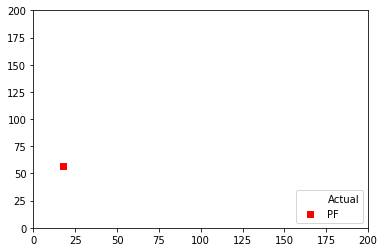

1854
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


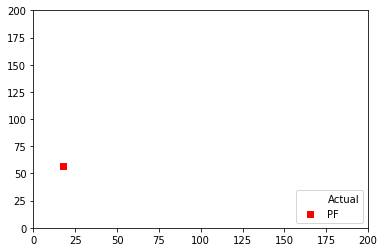

1855
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


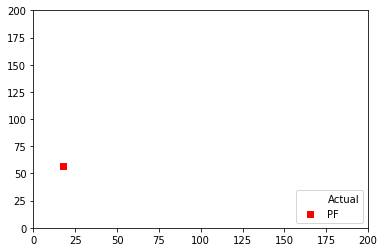

1856
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


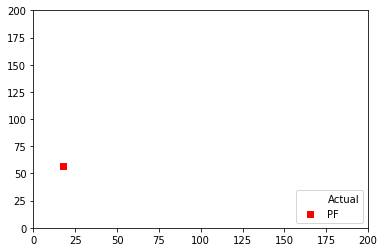

1857
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


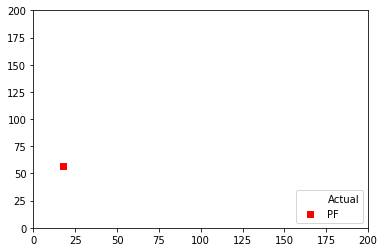

1858
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


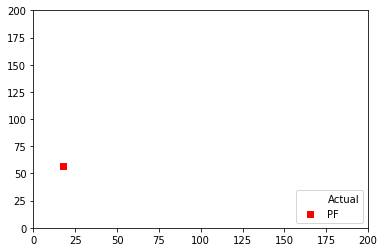

1859
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


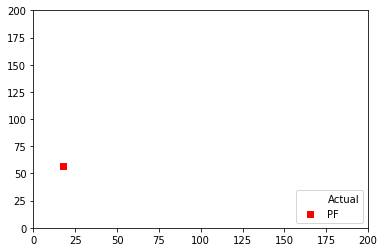

1860
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


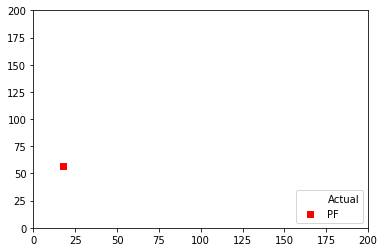

1861
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


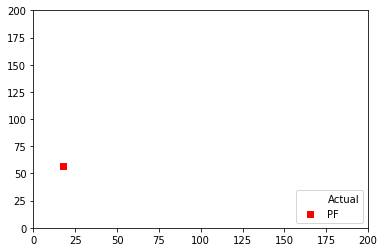

1862
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


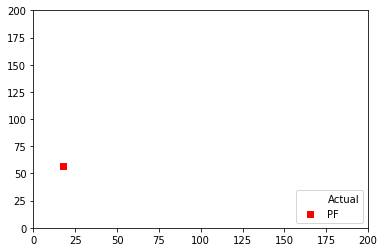

1863
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


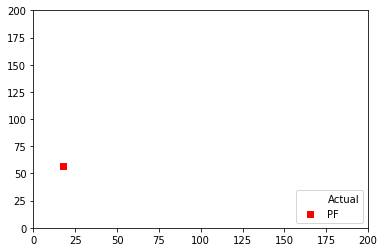

1864
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


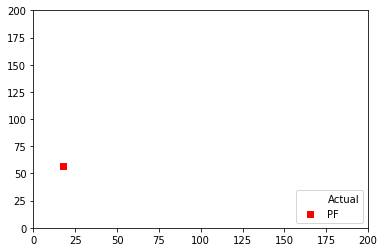

1865
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


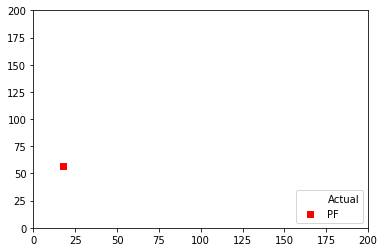

1866
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


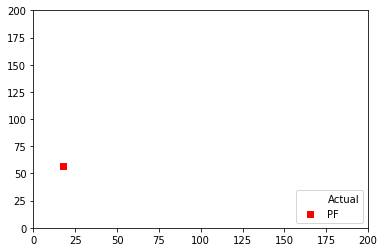

1867
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


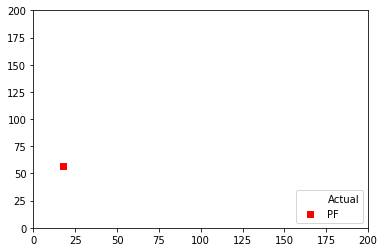

1868
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


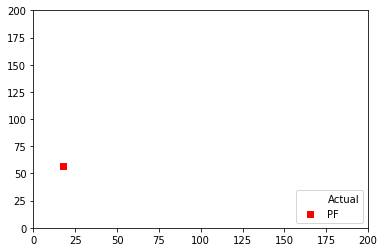

1869
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


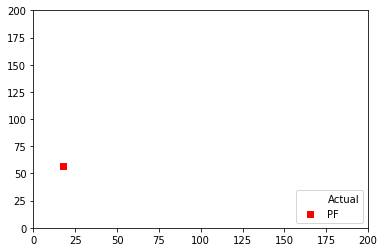

1870
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


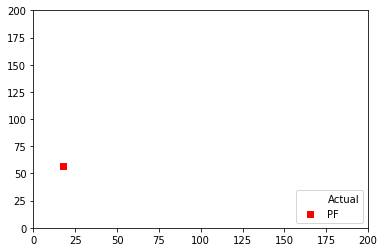

1871
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


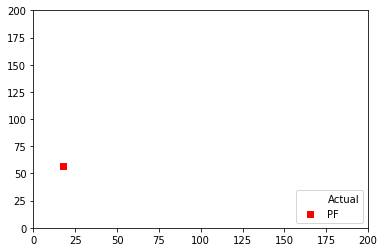

1872
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


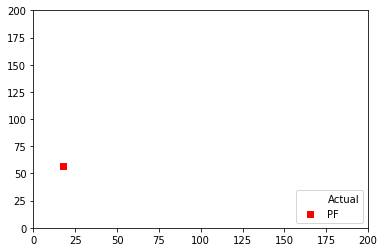

1873
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


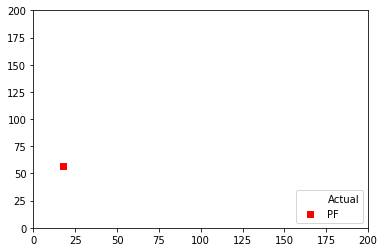

1874
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


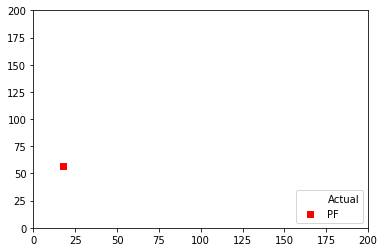

1875
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


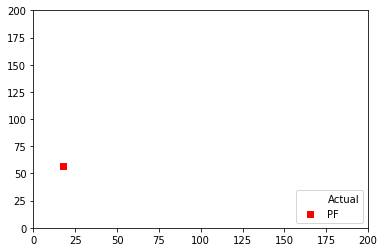

1876
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


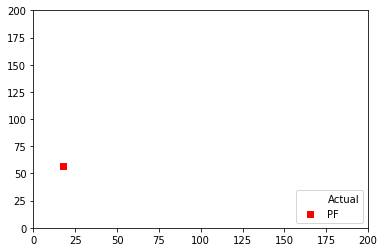

1877
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


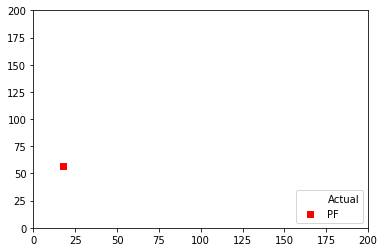

1878
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


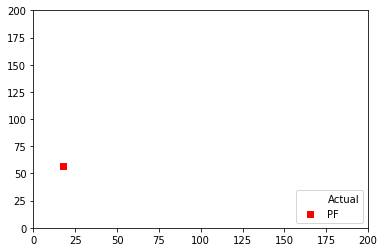

1879
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


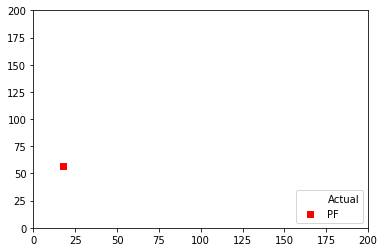

1880
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


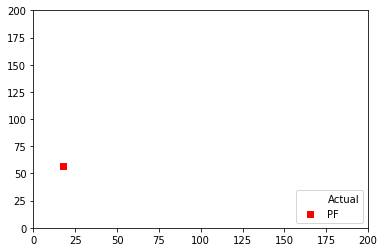

1881
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


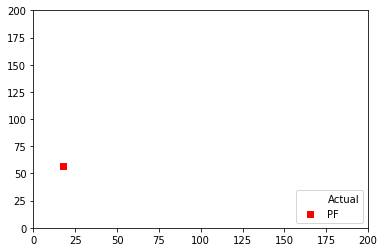

1882
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


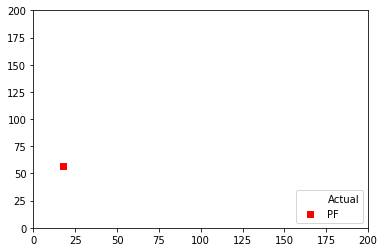

1883
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


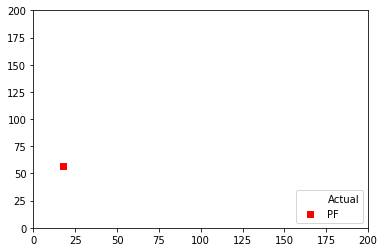

1884
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


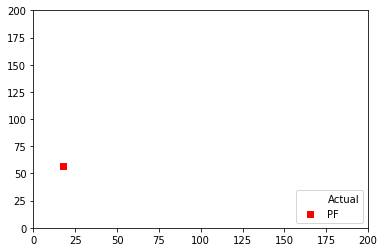

1885
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


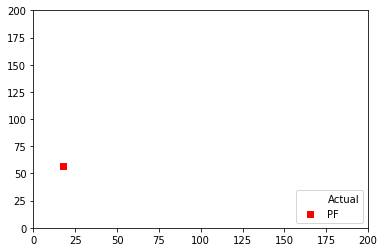

1886
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


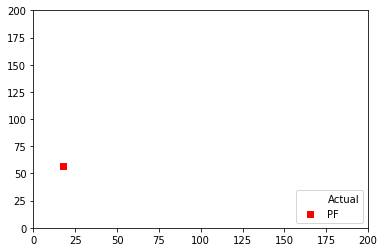

1887
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


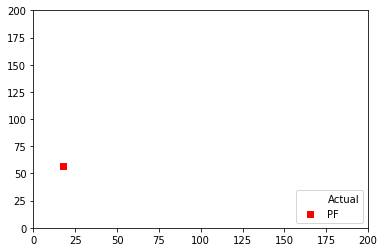

1888
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


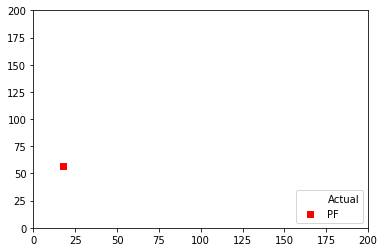

1889
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


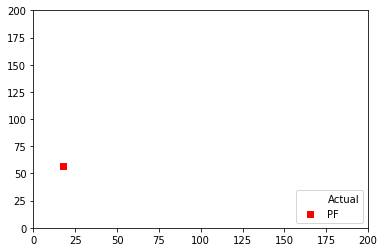

1890
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


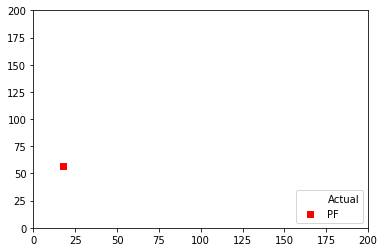

1891
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


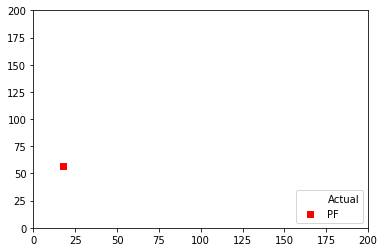

1892
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


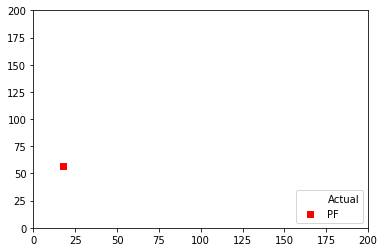

1893
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


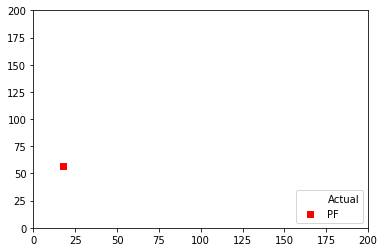

1894
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


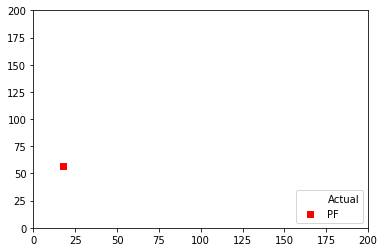

1895
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


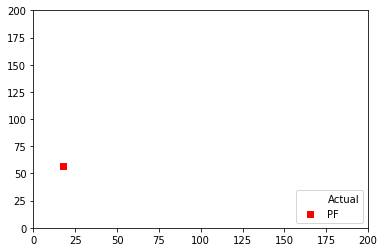

1896
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


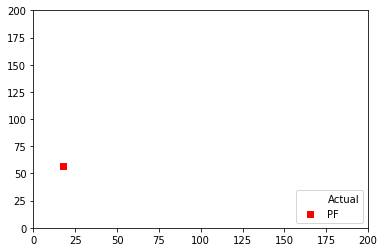

1897
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


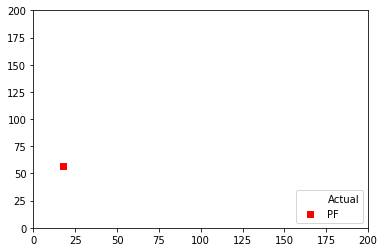

1898
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


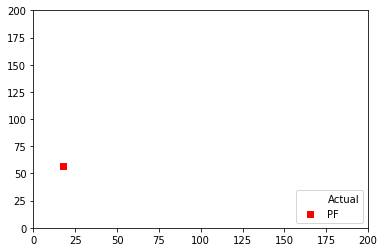

1899
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


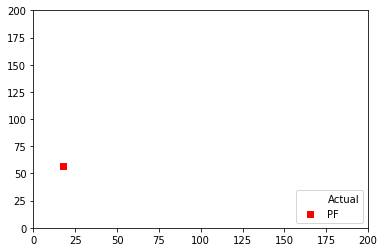

1900
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


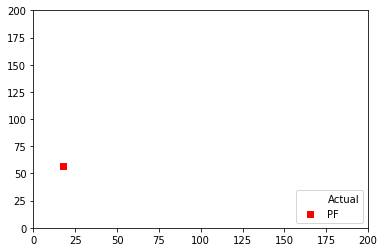

1901
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


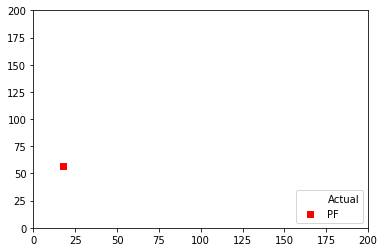

1902
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


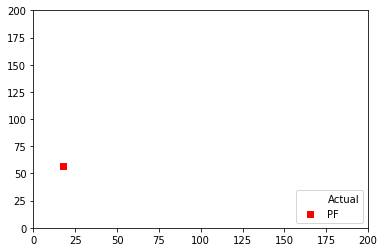

1903
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


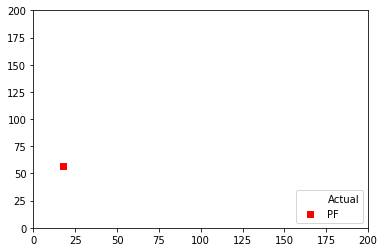

1904
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


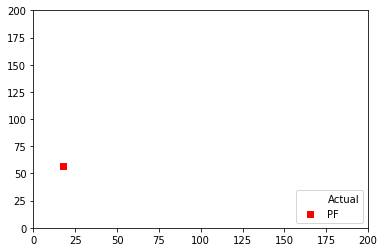

1905
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


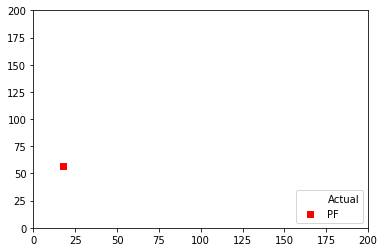

1906
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


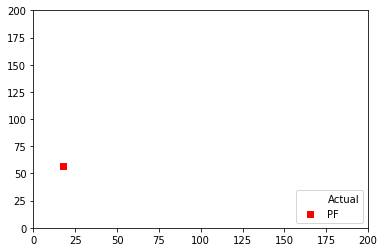

1907
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


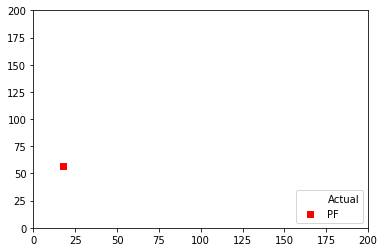

1908
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


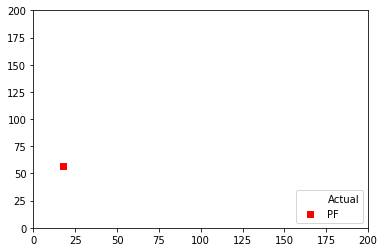

1909
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


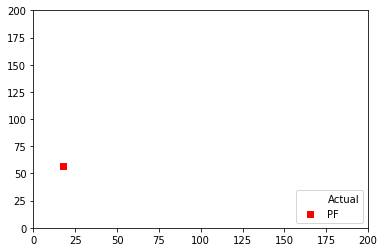

1910
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


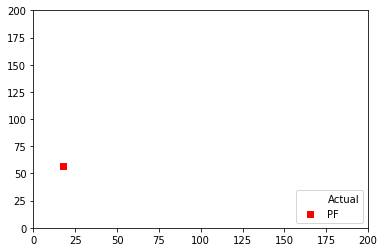

1911
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


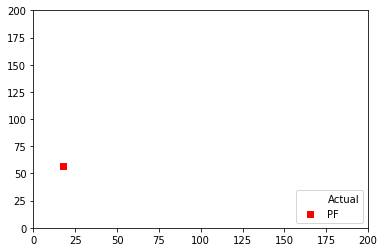

1912
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


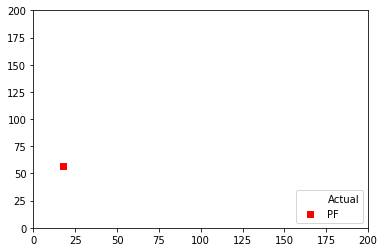

1913
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


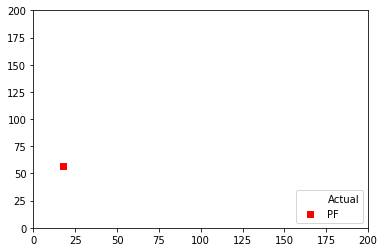

1914
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


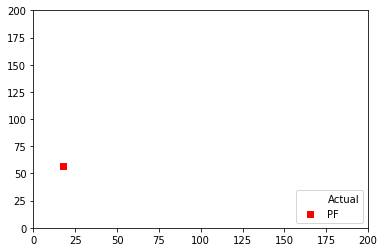

1915
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


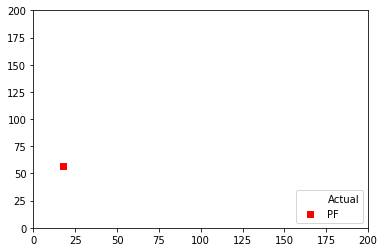

1916
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


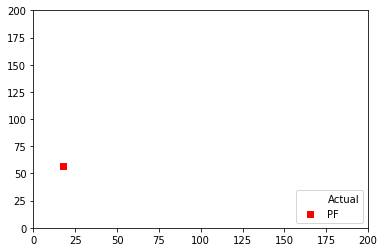

1917
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


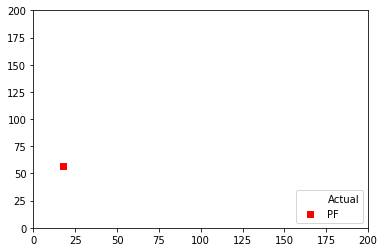

1918
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


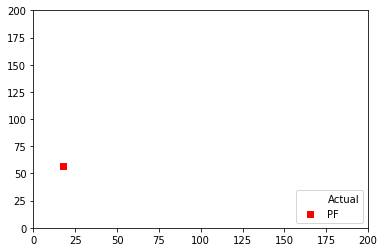

1919
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


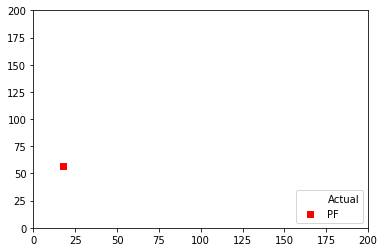

1920
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


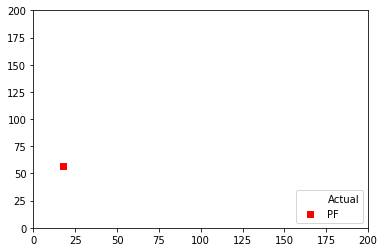

1921
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


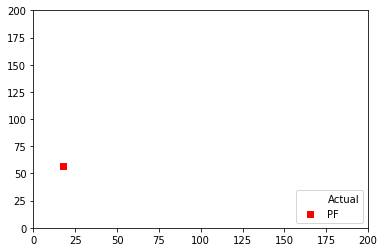

1922
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


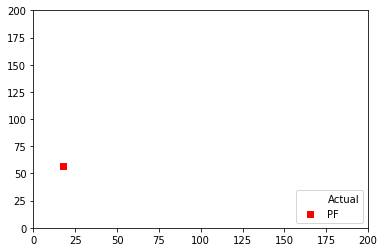

1923
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


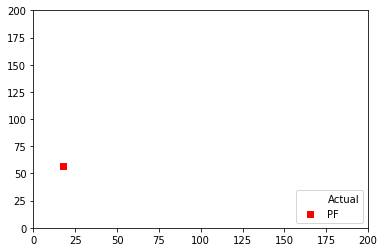

1924
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


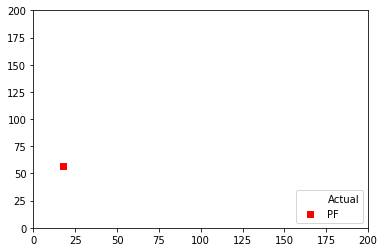

1925
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


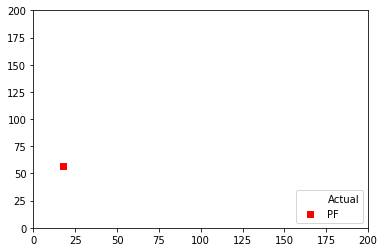

1926
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


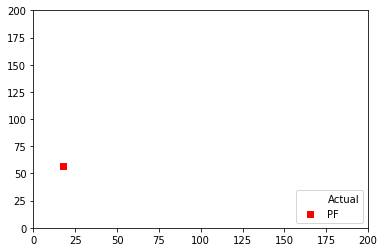

1927
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


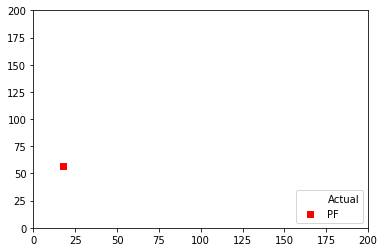

1928
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


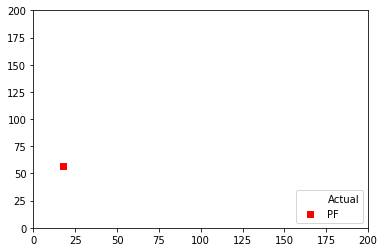

1929
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


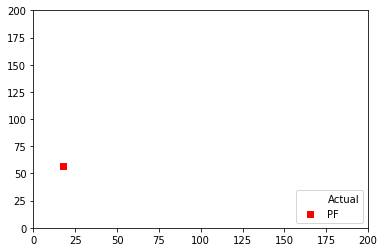

1930
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


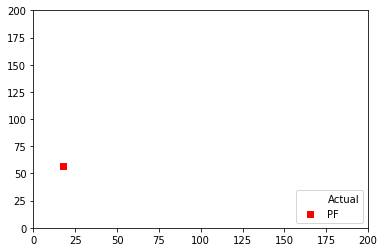

1931
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


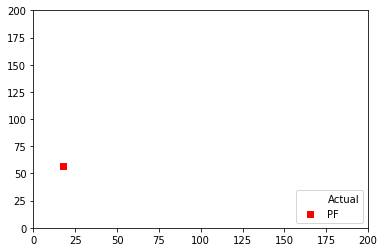

1932
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


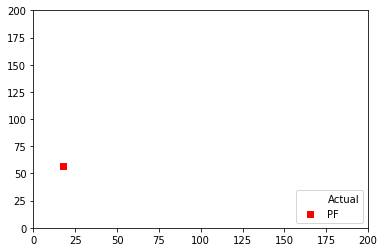

1933
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


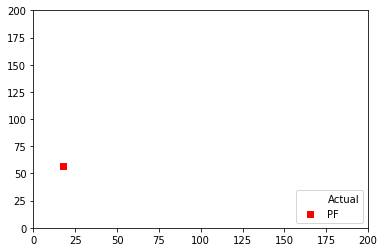

1934
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


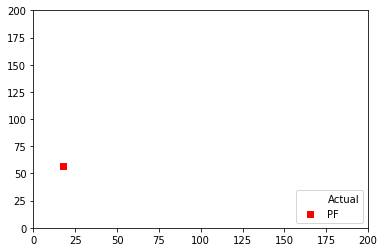

1935
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


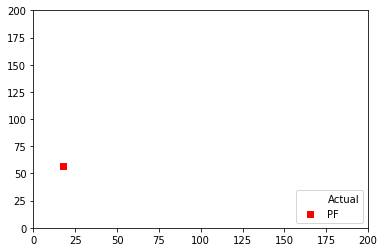

1936
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


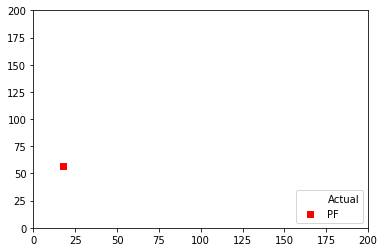

1937
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


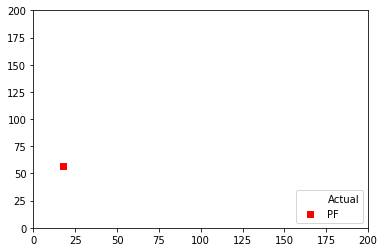

1938
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


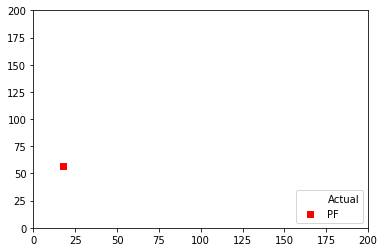

1939
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


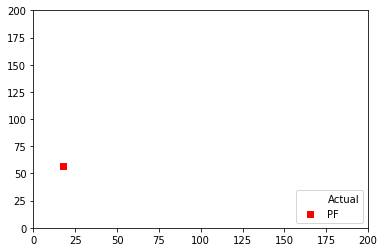

1940
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


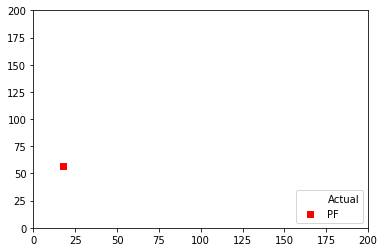

1941
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


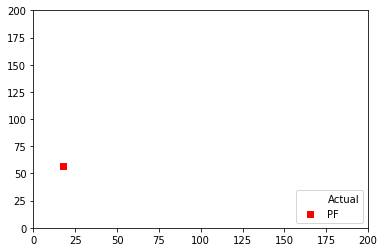

1942
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


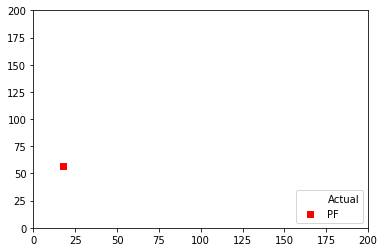

1943
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


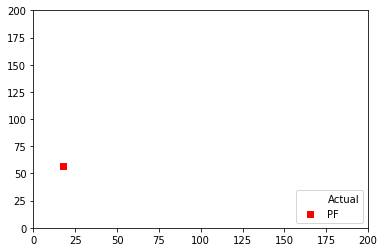

1944
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


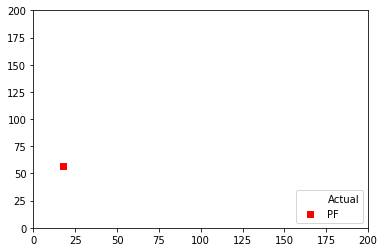

1945
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


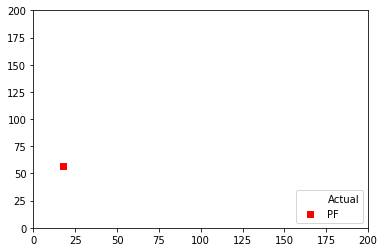

1946
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


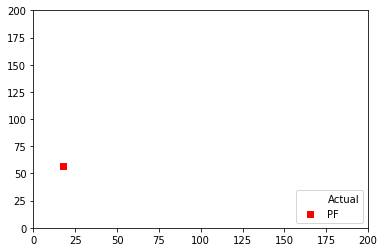

1947
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


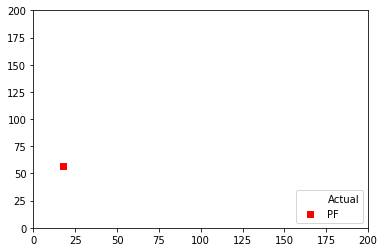

1948
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


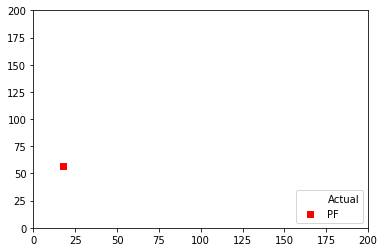

1949
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


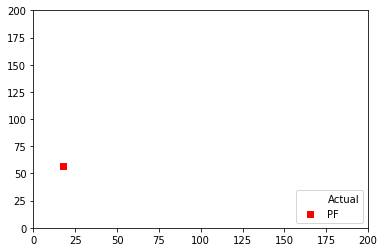

1950
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


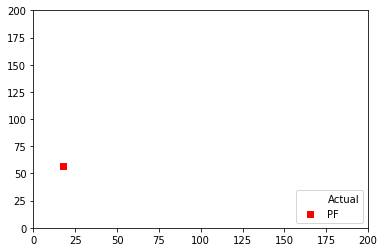

1951
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


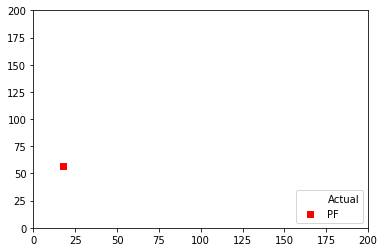

1952
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


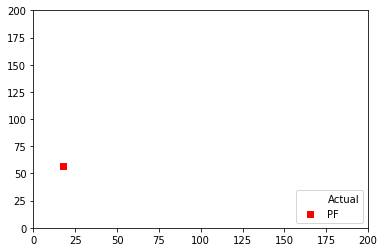

1953
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


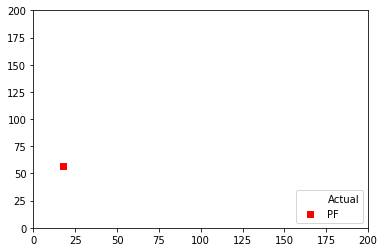

1954
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


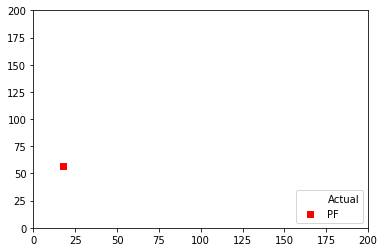

1955
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


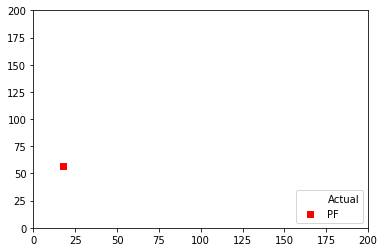

1956
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


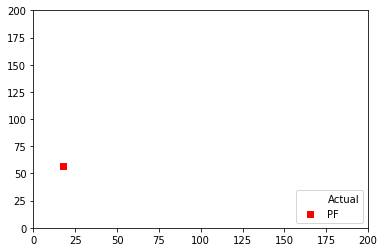

1957
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


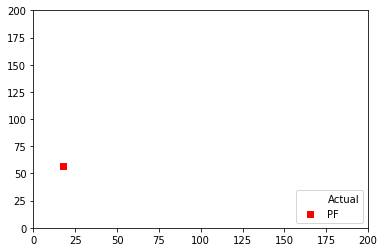

1958
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


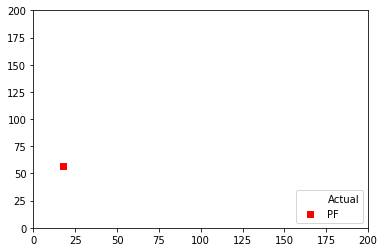

1959
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


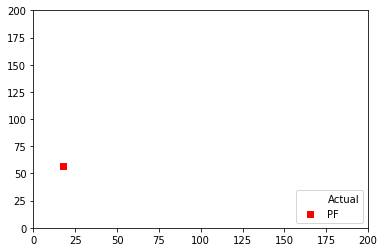

1960
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


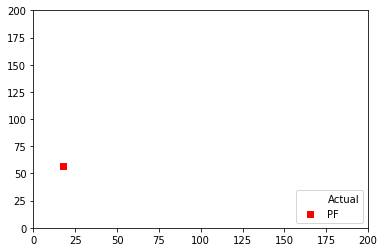

1961
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


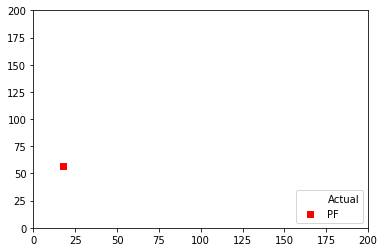

1962
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


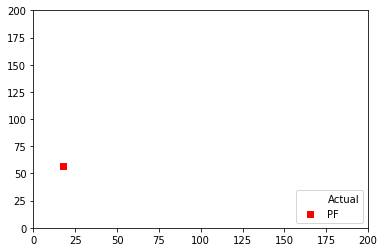

1963
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


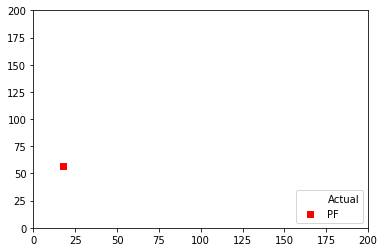

1964
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


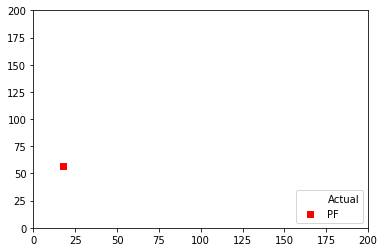

1965
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


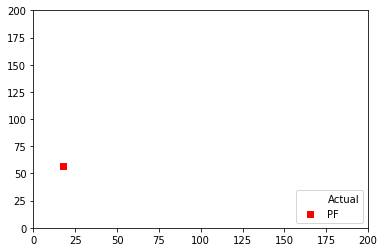

1966
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


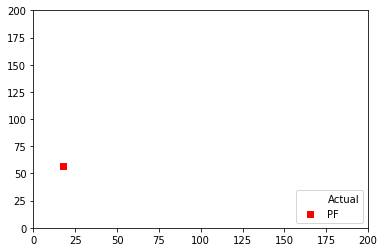

1967
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


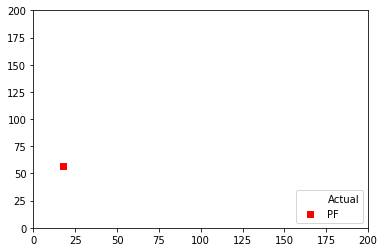

1968
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


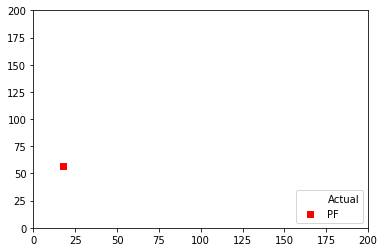

1969
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


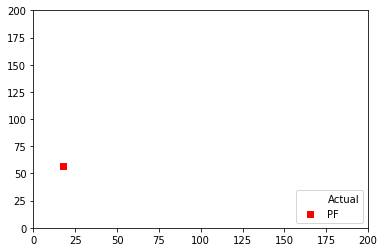

1970
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


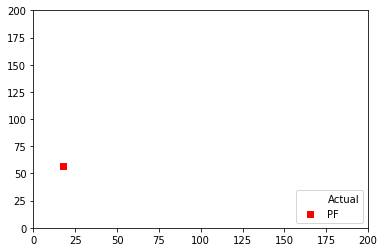

1971
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


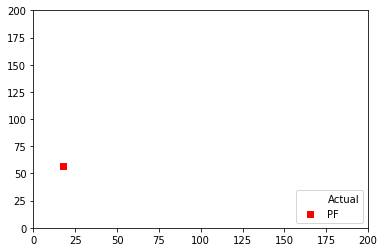

1972
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


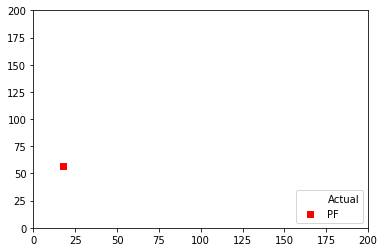

1973
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


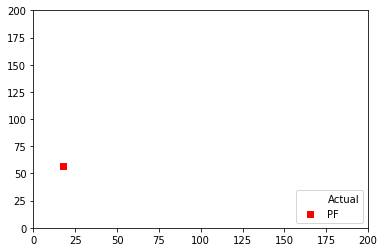

1974
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


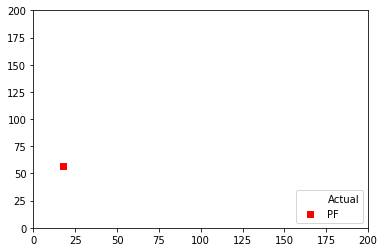

1975
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


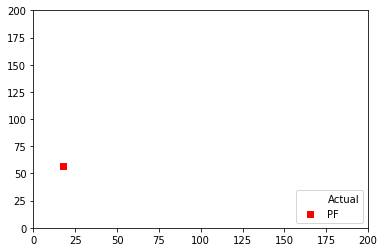

1976
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


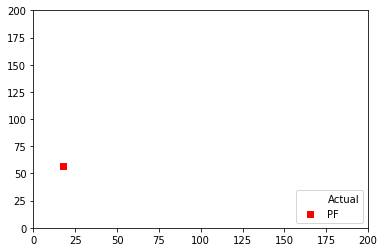

1977
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


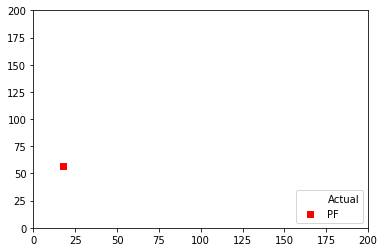

1978
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


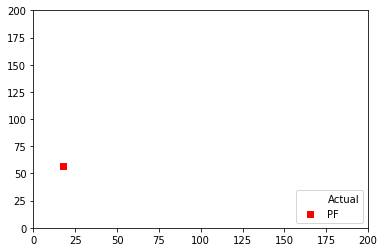

1979
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


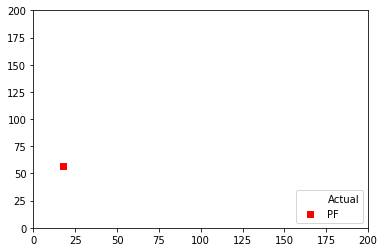

1980
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


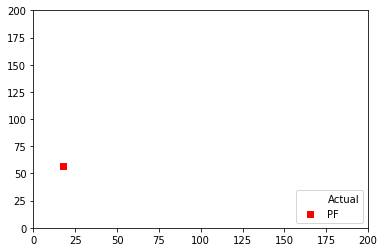

1981
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


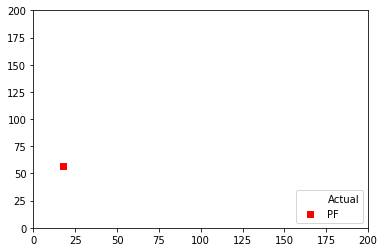

1982
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


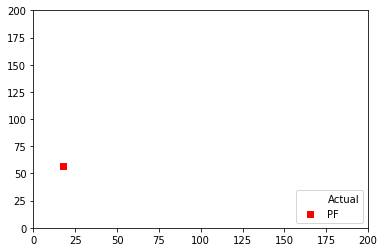

1983
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


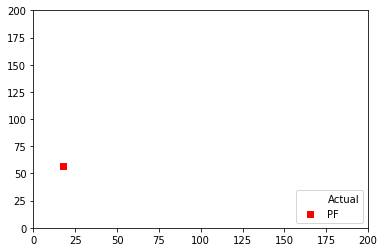

1984
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


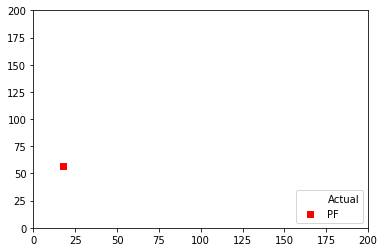

1985
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


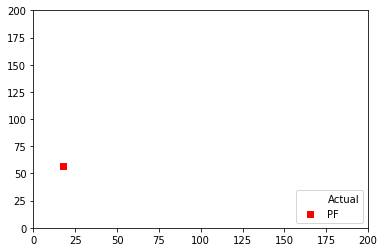

1986
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


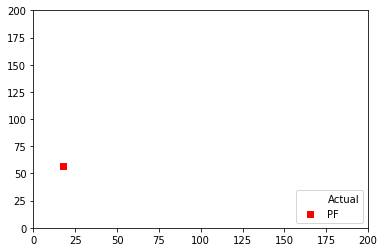

1987
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


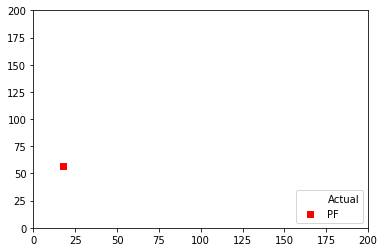

1988
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


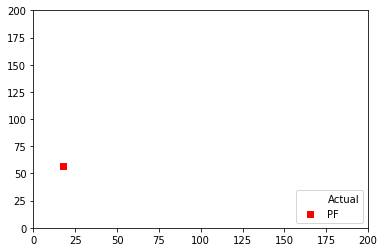

1989
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


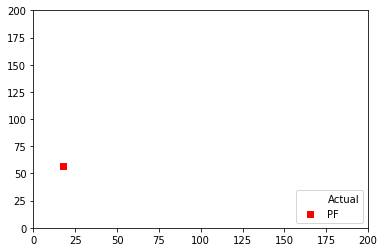

1990
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


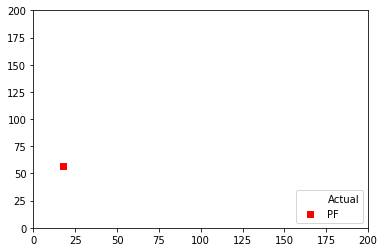

1991
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


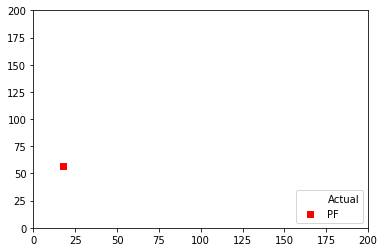

1992
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


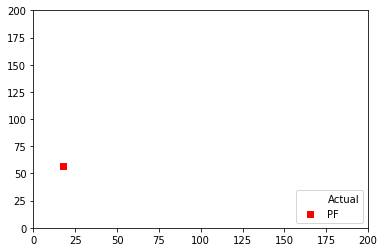

1993
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


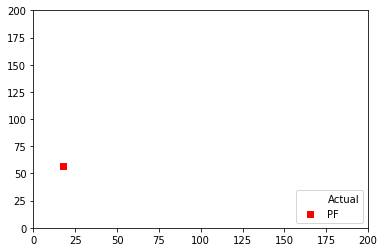

1994
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


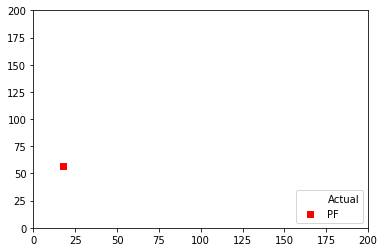

1995
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


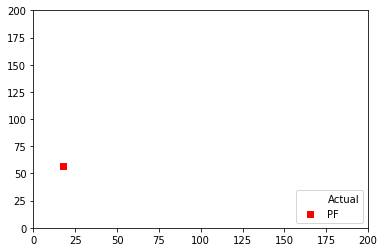

1996
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


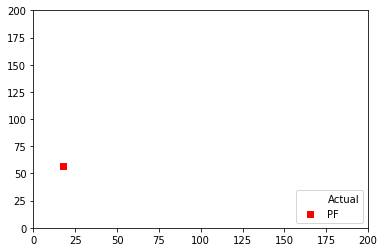

1997
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


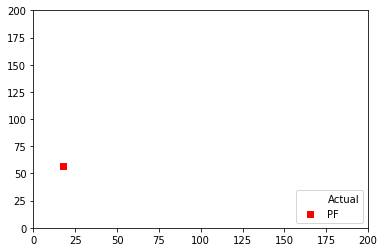

1998
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


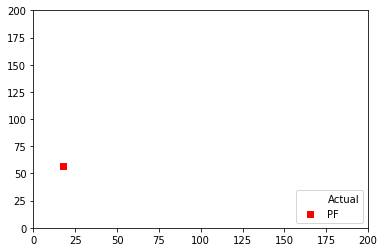

1999
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


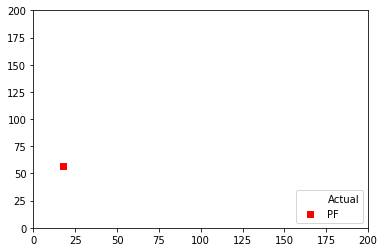

2000
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


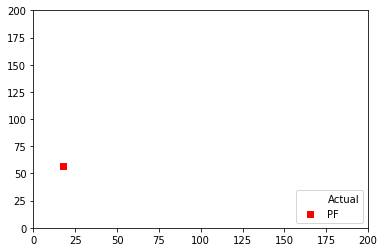

2001
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


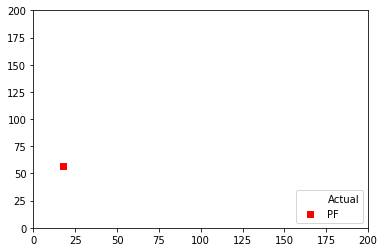

2002
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


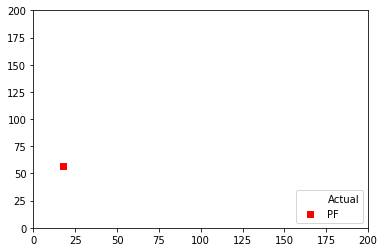

2003
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


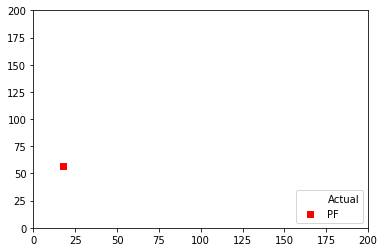

2004
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


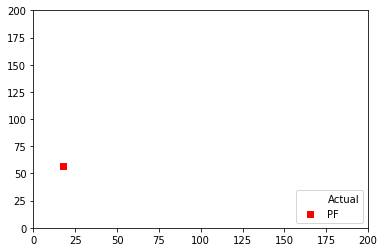

2005
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


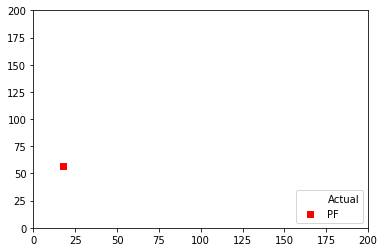

2006
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


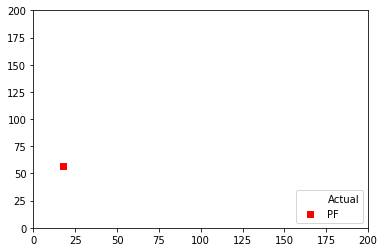

2007
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


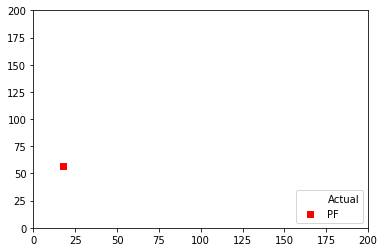

2008
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


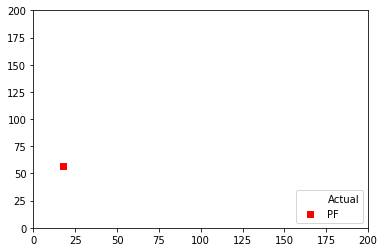

2009
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


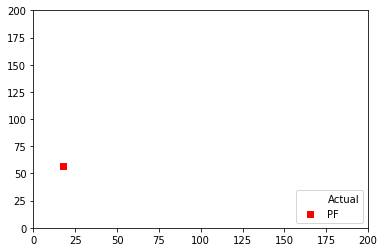

2010
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


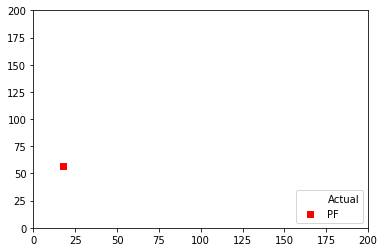

2011
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


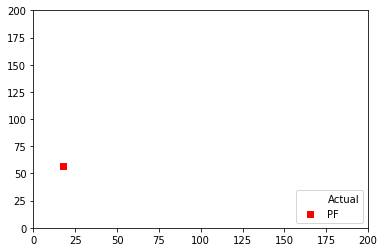

2012
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


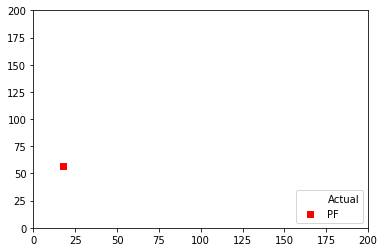

2013
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


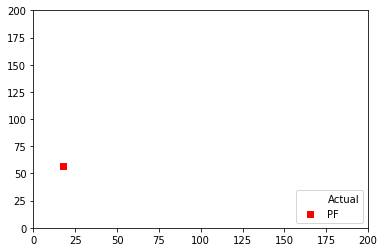

2014
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


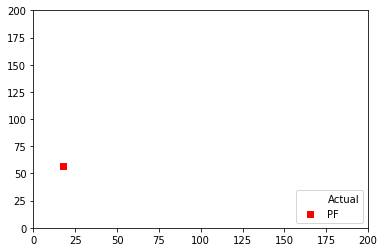

2015
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


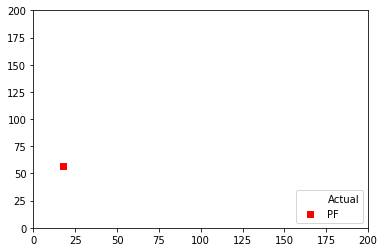

2016
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


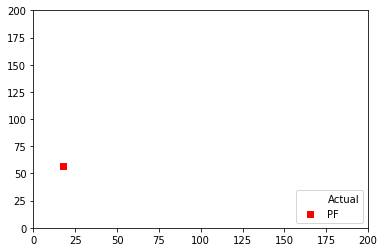

2017
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


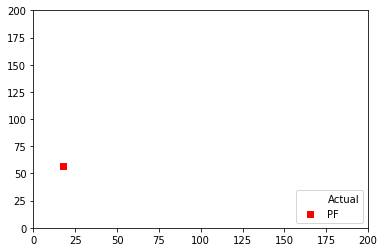

2018
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


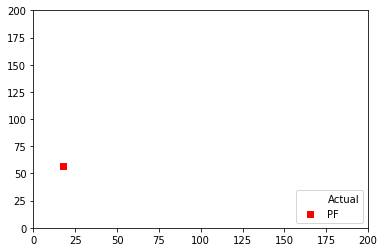

2019
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


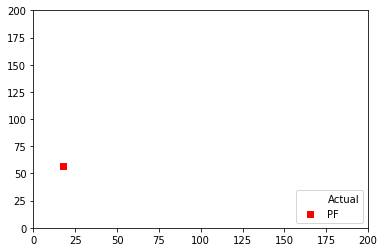

2020
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


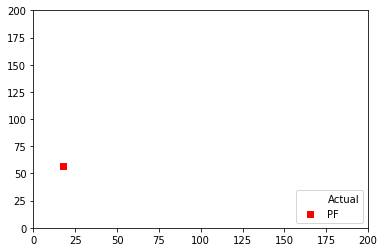

2021
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


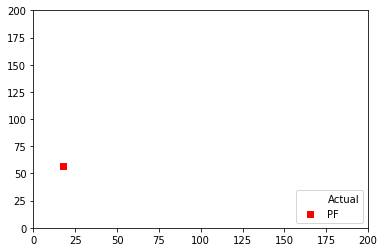

2022
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


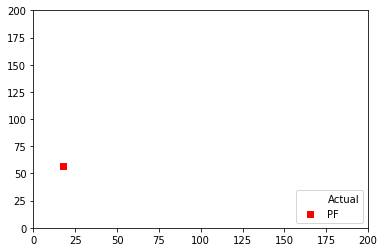

2023
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


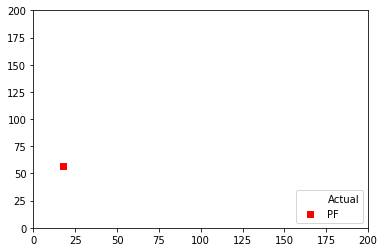

2024
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


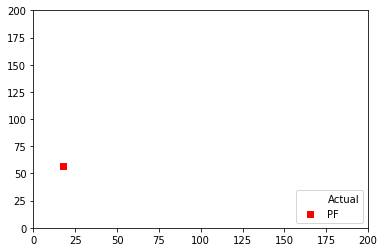

2025
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


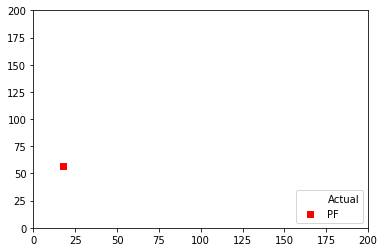

2026
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


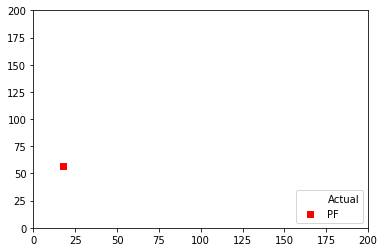

2027
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


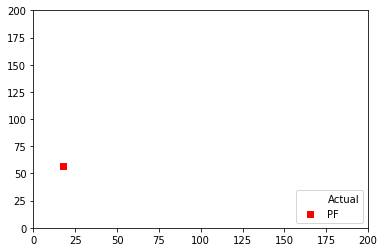

2028
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


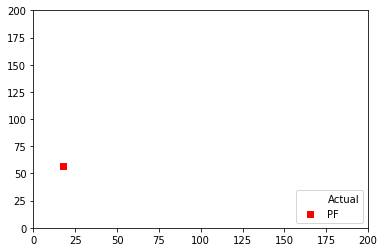

2029
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


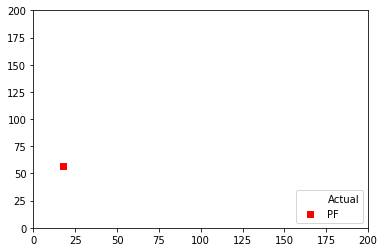

2030
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


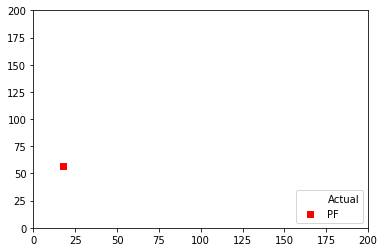

2031
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


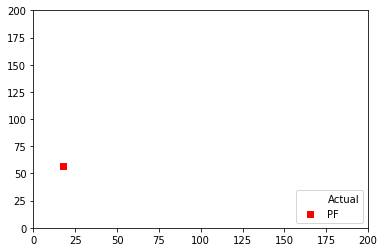

2032
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


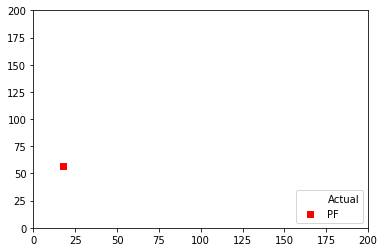

2033
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


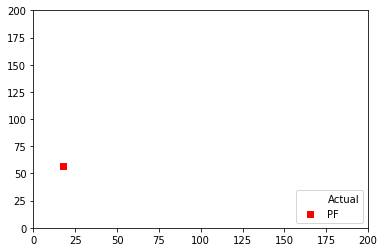

2034
infered loc:
[18.         57.05357143]
real loc:
[nan nan]


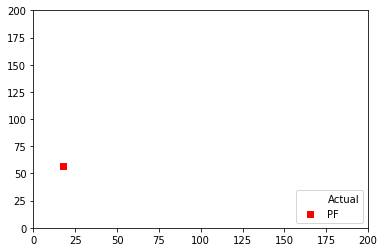

In [15]:
%matplotlib inline
plt.figure()
readFileCSV()

In [18]:
len(simulated_sensor_readings)

2056

In [19]:
completed_dataset = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
for i in range(0, len(simulated_sensor_readings)):
    completed_dataset.append((dataset[i + 1], simulated_sensor_readings[i]))

In [53]:
import pandas as pd

indices_to_keep = [0, 1, 2, 3, 4, 5, 11, 15, 16, 17, 18, 19, 20, 21]

templist = [[0] * 14]
for i in range(0, len(dataset[1:, 3])):
    numlist = [int(s) for s in dataset[1:, 3][i] if s.isdigit()]
    numlist = [numlist[j] for j in range(0, len(numlist)) if j in indices_to_keep]
    templist.append(numlist)
    
templist_modified = [[0] * 14]
for row in range(1, len(templist)):
    history = templist_modified[row - 1]
    row_modified = [0] * 14
    for i in range(len(history)):    
        if (templist[row][i] == 0 and history[i] == 1):
            row_modified[i] = 1
        
        elif (templist[row][i] == 0 and history[i] == 0):
            row_modified[i] = 0
        
        elif (templist[row][i] == 1 and history[i] == 1):
            row_modified[i] = 0
            
        elif (templist[row][i] == 1 and history[i] == 0):
            row_modified[i] = 1
        
    templist_modified.append(row_modified)

del templist_modified[0]    

    
columns = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
index = range(0, len(simulated_sensor_readings))

df = pd.DataFrame(index = index, columns = columns)

datadict = {'time' : dataset[1:, 0], 'gt(x)' : dataset[1:, 1], 'gt(y)' : dataset[1:, 2], 
            'gt_motion_readings' : templist_modified, 'sim_motion_readings' : simulated_sensor_readings}

df = pd.DataFrame(datadict)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [54]:
templist

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [49]:
df

time     gt(x)     gt(y)  \
0     1498670641.0  1.197742  5.402001   
1     1498670642.0  1.198065  5.401716   
2     1498670643.0  1.198387   5.40143   
3     1498670644.0   1.19871  5.401144   
4     1498670645.0  1.199032  5.400858   
5     1498670646.0  1.199355  5.400572   
6     1498670688.0       1.2       5.4   
7     1498670691.0       1.2       5.4   
8     1498670694.0       1.2       5.4   
9     1498670697.0       1.2       5.4   
10    1498670700.0       1.2       5.4   
11    1498670703.0       1.2       5.4   
12    1498670706.0       1.2       5.4   
13    1498670709.0       1.2       5.4   
14    1498670712.0       1.2       5.4   
15    1498670715.0       1.2       5.4   
16    1498670718.0       1.2       5.4   
17    1498670721.0  1.566667      5.05   
18    1498670724.0  2.666667       4.0   
19    1498670727.0       3.4       3.3   
20    1498670730.0       3.4       3.3   
21    1498670733.0       3.4       3.3   
22    1498670736.0       3.4       3.3   
23    1498670739.0       3.4       3.3   
24    1498670742.0       3.4       3.3   
25    1498670745.0       3.4       3.3   
26    1498670748.0       3.4       3.3   
27    1498670751.0       3.4       3.3   
28    1498670754.0       3.4       3.3   
29    1498670757.0       3.4       3.3   
...            ...       ...       ...   
2026  1498677243.0       2.3       5.4   
2027  1498677246.0       2.3       5.4   
2028  1498677249.0       2.3       5.4   
2029  1498677252.0       2.3       5.4   
2030  1498677254.0       2.3       5.4   
2031  1498677255.0       2.3       5.4   
2032  1498677256.0       2.3       5.4   
2033  1498677257.0       2.3       5.4   
2034  1498677258.0      2.52      5.01   
2035  1498677261.0      3.18      3.84   
2036  1498677264.0       3.4      3.45   
2037  1498677267.0       3.4      3.45   
2038  1498677269.0       3.4      3.45   
2039  1498677270.0       3.4      3.45   
2040  1498677271.0       3.4      3.45   
2041  1498677272.0       3.4      3.45   
2042  1498677273.0       3.4      3.45   
2043  1498677274.0       3.4      3.45   
2044  1498677275.0       3.4      3.45   
2045  1498677276.0       3.4      3.45   
2046  1498677279.0       3.4      3.45   
2047  1498677282.0       3.4      3.45   
2048  1498677285.0       3.4      3.45   
2049  1498677288.0       3.4      3.45   
2050  1498677291.0       3.4      3.45   
2051  1498677294.0       3.4      3.45   
2052  1498677297.0       3.4      3.45   
2053  1498677300.0       3.4      3.45   
2054  1498677303.0       3.4      3.45   
2055  1498677318.0       3.4      3.45   

                              gt_motion_readings  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
5     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   
6     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
7     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
8     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
9     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
10    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
11    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
12    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
13    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
14    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
15    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
16    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
17    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
18    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
19    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
20    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
21    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
22    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
23    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
24    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
25    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]   
26   

In [46]:
row

2

In [50]:
gt_readings = {}

for sensor in range(0, 14):
    gt_readings[sensor] = []
    for i in range(0, len(df['gt_motion_readings'])):
        gt_readings[sensor].append(df['gt_motion_readings'][i][sensor])
        
        
sim_readings = {}

for sensor in range(0, 14):
    sim_readings[sensor] = []
    for i in range(0, len(df['sim_motion_readings'])):
        sim_readings[sensor].append(df['sim_motion_readings'][i][sensor])

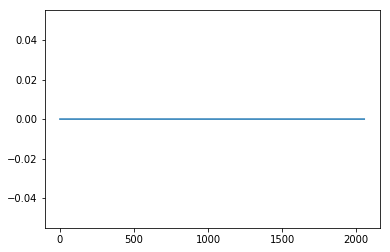

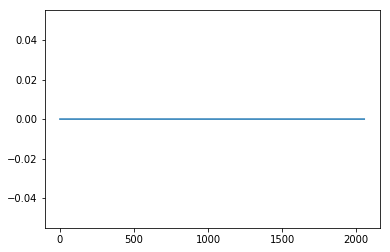

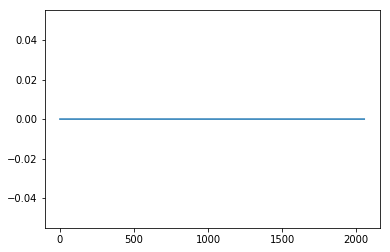

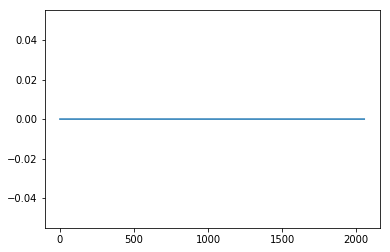

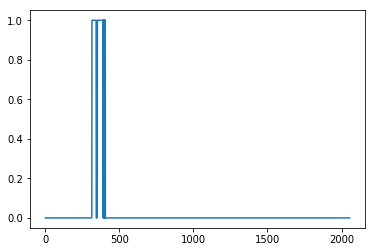

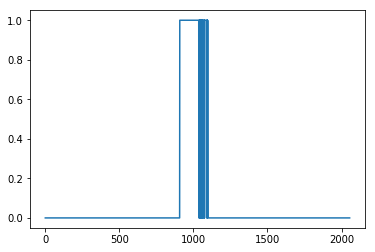

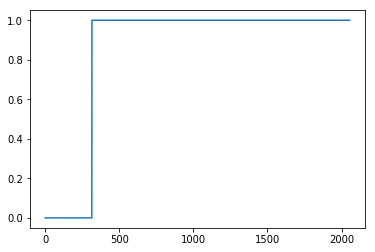

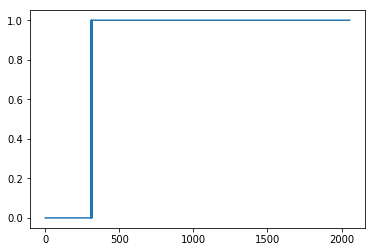

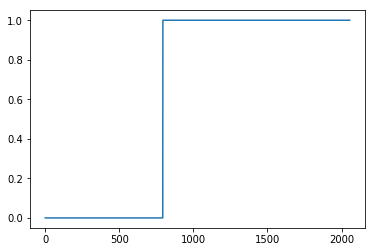

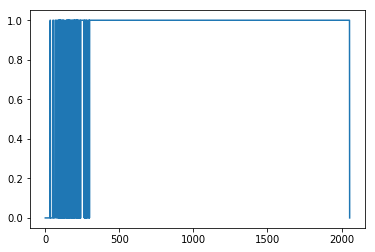

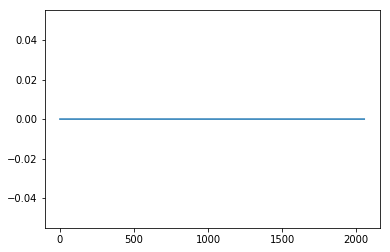

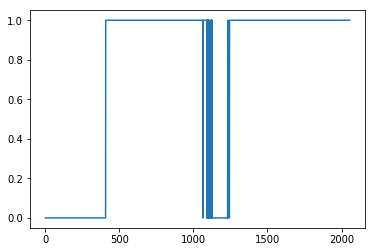

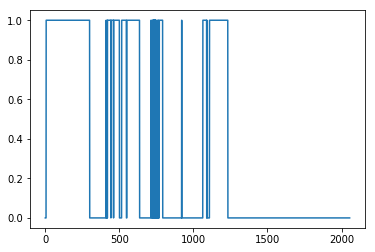

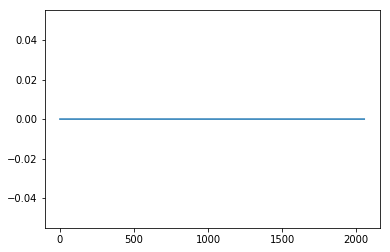

In [51]:
import matplotlib.pyplot as plt

for i in range(len(gt_readings)):
    plt.plot(list(range(0,len(gt_readings[i]))), gt_readings[i])
    plt.show()

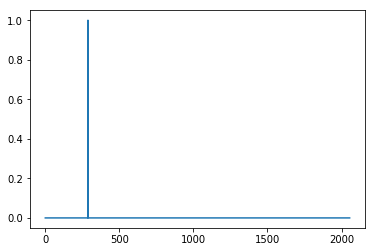

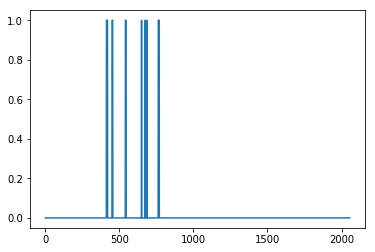

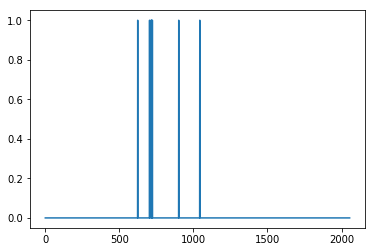

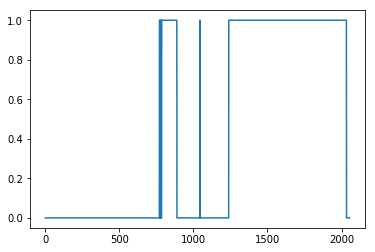

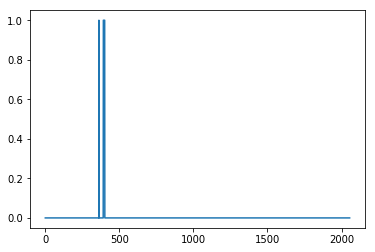

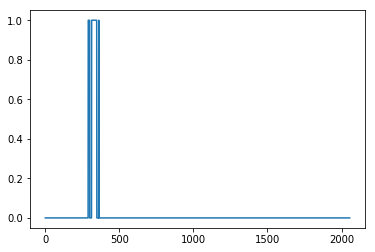

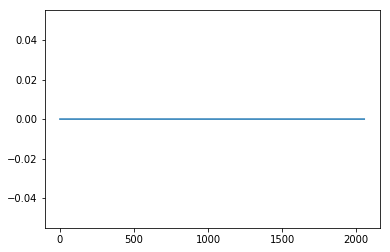

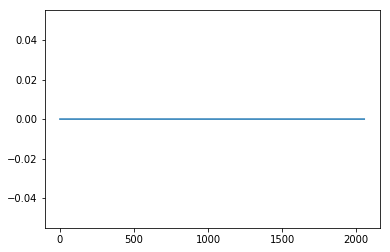

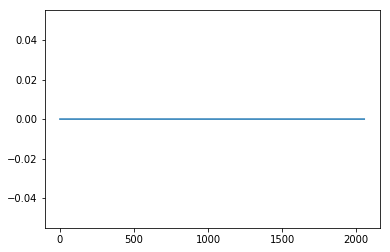

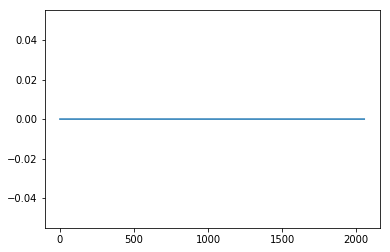

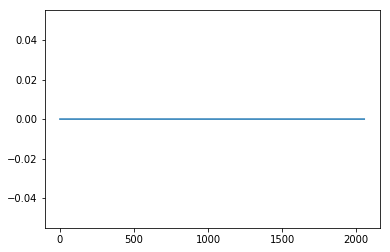

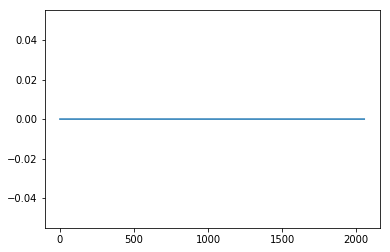

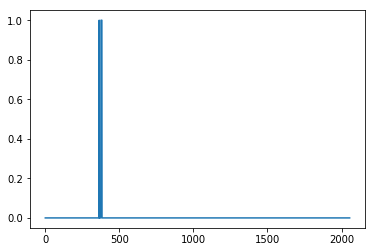

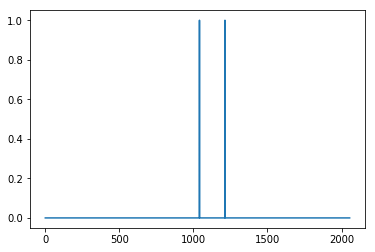

In [52]:
import matplotlib.pyplot as plt

for i in range(len(sim_readings)):
    plt.plot(list(range(0,len(sim_readings[i]))), sim_readings[i])
    plt.show()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)

In [ ]:
from random import shuffle
x = [i for i in range(8)]
shuffle(x)
print(x)

In [ ]:
x